# ImplÃ©mentation du modÃ¨le U-Net avec PyTorch pour la dÃ©tection des trouÃ©es forestiÃ¨res

Ce script dÃ©finit l'architecture du modÃ¨le U-Net en utilisant PyTorch pour la
dÃ©tection des trouÃ©es forestiÃ¨res Ã  partir de modÃ¨les numÃ©riques de surface (DSM).

**Auteur :** VANDER LINDEN Arthur
**Date :** 28-02-2025



# PARTIE 1: CONFIGURATION

In [82]:
import time
import threading
from google.colab import output

def keep_alive():
    while True:
        output.eval_js('google.colab.kernel.invokeFunction("notebook", "ExecuteTime", {})')
        time.sleep(60)  # Attendre 60 secondes avant de renvoyer une requÃªte

# DÃ©marrer dans un thread sÃ©parÃ© pour ne pas bloquer l'exÃ©cution
keep_alive_thread = threading.Thread(target=keep_alive)
keep_alive_thread.daemon = True  # Le thread s'arrÃªtera quand le programme principal se termine
keep_alive_thread.start()

print("Session keep-alive activÃ©. Votre session Colab restera active.")

Session keep-alive activÃ©. Votre session Colab restera active.


## SECTION 1: IMPORTATIONS ET CONFIGURATION

In [83]:
# =====================================================================
# SECTION 1: IMPORTATIONS ET CONFIGURATION
# =====================================================================

!pip install rasterio geopandas

import os
import glob
import time
import copy
import sys
import json
import pickle
import random
import datetime
import warnings
import traceback
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from scipy import ndimage
import cv2

# Importation des bibliothÃ¨ques pour le traitement de donnÃ©es gÃ©ospatiales
import rasterio
from rasterio.windows import Window
import geopandas as gpd

# Importations PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision.transforms as T
import torchvision.transforms.functional as TF

from torch.amp import GradScaler, autocast

# Ignorer les avertissements de FutureWarning de torch.load
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.serialization")

# Configuration PyTorch
# Fixer le seed pour la reproductibilitÃ©
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# DÃ©terminer le pÃ©riphÃ©rique Ã  utiliser (CPU ou GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

# Optimisation des opÃ©rations CUDA
def optimize_cuda_operations():
    """
    Configure les opÃ©rations CUDA pour de meilleures performances.
    Ã€ appeler au dÃ©but du script.
    """
    if torch.cuda.is_available():
        # Activer l'auto-tuning pour trouver les algorithmes CUDA les plus rapides
        torch.backends.cudnn.benchmark = True

        # Si votre batch size et tailles d'entrÃ©e sont fixes, ceci peut amÃ©liorer les performances
        # torch.backends.cudnn.deterministic = False

        # Permet Ã  PyTorch d'allouer plus de mÃ©moire si nÃ©cessaire
        torch.cuda.empty_cache()

        # Configurer les allocateurs de mÃ©moire CUDA pour de meilleures performances
        # avec les GPUs rÃ©cents
        # torch.cuda.set_per_process_memory_fraction(0.95)  # Utiliser 95% de la mÃ©moire GPU

        print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
        print(f"MÃ©moire GPU totale: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    else:
        print("CUDA n'est pas disponible. Utilisation du CPU.")

# Appeler la fonction d'optimisation CUDA
optimize_cuda_operations()

# Montage de Google Drive
from google.colab import drive
drive.mount('/content/drive')



Utilisation de: cuda
PyTorch version: 2.5.1+cu124
GPU disponible: NVIDIA L4
MÃ©moire GPU totale: 23.80 GB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## SECTION 2: DÃ‰FINITIONS DES CHEMINS ET CONFIGURATION


In [84]:
# =====================================================================
# SECTION 2: DÃ‰FINITIONS DES CHEMINS ET CONFIGURATION
# =====================================================================

class Config:
    """Classe de configuration centralisÃ©e pour le projet"""

    def __init__(self):
        # RÃ©pertoire de base
        self.BASE_DIR = '/content/drive/MyDrive/ForestGaps_DeepLearning_Workflow'

        # Sous-rÃ©pertoires principaux
        self.DATA_DIR = os.path.join(self.BASE_DIR, 'data')
        self.DATA_EXTERNAL_TEST_DIR = os.path.join(self.BASE_DIR, 'data_external_test')
        self.PROCESSED_DIR = os.path.join(self.BASE_DIR, 'processed')
        self.TILES_DIR = os.path.join(self.PROCESSED_DIR, 'tiles')

        # Sous-rÃ©pertoires pour les tuiles
        self.TRAIN_TILES_DIR = os.path.join(self.TILES_DIR, 'train')
        self.VAL_TILES_DIR = os.path.join(self.TILES_DIR, 'val')
        self.TEST_TILES_DIR = os.path.join(self.TILES_DIR, 'test')

        # Dossiers spÃ©cifiques au modÃ¨le U-Net
        self.MODELS_DIR = os.path.join(self.BASE_DIR, 'models')
        self.UNET_DIR = os.path.join(self.MODELS_DIR, 'unet')

        # Sous-rÃ©pertoires pour les rÃ©sultats et les checkpoints
        self.CHECKPOINTS_DIR = os.path.join(self.UNET_DIR, 'checkpoints')
        self.LOGS_DIR = os.path.join(self.UNET_DIR, 'logs')
        self.RESULTS_DIR = os.path.join(self.UNET_DIR, 'results')
        self.VISUALIZATIONS_DIR = os.path.join(self.UNET_DIR, 'visualizations')

        # Type de modÃ¨le ('basic', 'film', 'cbam', 'droppath', 'film_cbam', 'all')
        self.MODEL_TYPE = 'film_cbam'

        # ParamÃ¨tres spÃ©cifiques aux modÃ¨les avancÃ©s
        self.IN_CHANNELS = 1
        self.DROP_PATH_RATE = 0.1  # Taux de DropPath (pour 'droppath' et 'all')

        # CrÃ©ation des rÃ©pertoires s'ils n'existent pas
        for dir_path in [
            self.CHECKPOINTS_DIR, self.LOGS_DIR,
            self.RESULTS_DIR, self.VISUALIZATIONS_DIR
        ]:
            os.makedirs(dir_path, exist_ok=True)

        # ParamÃ¨tres du modÃ¨le et de l'entraÃ®nement
        self.TILE_SIZE = 256  # Taille des tuiles en pixels
        self.BATCH_SIZE = 64  # Taille des batchs pour l'entraÃ®nement
        self.THRESHOLDS = [10, 15, 20, 25, 30]  # Seuils de hauteur en mÃ¨tres
        self.EPOCHS = 50  # Nombre maximal d'Ã©poques
        self.LEARNING_RATE = 0.001  # Taux d'apprentissage initial
        self.DROPOUT_RATE = 0.2  # Taux de dropout pour la rÃ©gularisation
        self.TEST_SPLIT = 0.15  # Proportion de donnÃ©es pour le test
        self.VAL_SPLIT = 0.15  # Proportion de donnÃ©es pour la validation

        # ParamÃ¨tres pour l'optimisation de l'entraÃ®nement
        self.NUM_WORKERS = 8  # Nombre de workers pour le DataLoader
        self.PIN_MEMORY = True  # Utiliser pin_memory pour accÃ©lÃ©rer le transfert vers GPU
        self.PREFETCH_FACTOR = 50

        # ParamÃ¨tres pour le mixup et l'augmentation des donnÃ©es
        self.AUGMENTATION = True  # Activer l'augmentation des donnÃ©es
        self.MIXUP_ALPHA = 0.2  # ParamÃ¨tre alpha pour mixup (0 = dÃ©sactivÃ©)

        # Optimisations pour le modÃ¨le
        self.USE_AMP = True  # Utiliser la prÃ©cision mixte automatique
        self.USE_GRADIENT_CHECKPOINTING = False  # Ã‰conomiser de la mÃ©moire GPU

    def save_config(self, filepath=None):
        """Sauvegarde la configuration actuelle dans un fichier JSON"""
        if filepath is None:
            filepath = os.path.join(self.LOGS_DIR, 'config.json')

        # CrÃ©ation d'un dictionnaire de configuration
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('__') and not callable(v)}

        # Conversion des chemins en chaÃ®nes de caractÃ¨res
        for k, v in config_dict.items():
            if isinstance(v, Path):
                config_dict[k] = str(v)

        # Sauvegarde dans un fichier JSON
        with open(filepath, 'w') as f:
            json.dump(config_dict, f, indent=4)

        print(f"Configuration sauvegardÃ©e dans {filepath}")

    def load_config(self, filepath):
        """Charge une configuration Ã  partir d'un fichier JSON"""
        with open(filepath, 'r') as f:
            config_dict = json.load(f)

        # Mise Ã  jour des attributs
        for k, v in config_dict.items():
            setattr(self, k, v)

        print(f"Configuration chargÃ©e depuis {filepath}")

# Initialisation de la configuration
config = Config()

## SECTION 3: DÃ‰FINITION DES MÃ‰TRIQUES ET UTILITAIRES

In [85]:
# =====================================================================
# SECTION 3: DÃ‰FINITION DES MÃ‰TRIQUES ET UTILITAIRES
# =====================================================================

class SegmentationMetrics:
    """
    Classe pour calculer diverses mÃ©triques d'Ã©valuation pour la segmentation sÃ©mantique.
    Inclut: Accuracy, Precision, Recall, F1-score, IoU, mIoU, Kappa, etc.
    """
    def __init__(self, device=None):
        """
        Initialise l'objet de mÃ©triques.

        Args:
            device: PÃ©riphÃ©rique (CPU ou GPU) pour les calculs
        """
        self.device = device
        self.reset()

    def reset(self):
        """RÃ©initialise tous les compteurs."""
        self.tp = 0  # True Positives
        self.fp = 0  # False Positives
        self.tn = 0  # True Negatives
        self.fn = 0  # False Negatives

        # Pour les moyennes par image
        self.precision_sum = 0.0
        self.recall_sum = 0.0
        self.f1_sum = 0.0
        self.iou_sum = 0.0
        self.image_count = 0

        # Pour les mÃ©triques par seuil
        self.metrics_by_threshold = {}

    def update(self, pred, target, threshold=0.5):
        """
        Met Ã  jour les compteurs avec les nouvelles prÃ©dictions.

        Args:
            pred: PrÃ©dictions du modÃ¨le (aprÃ¨s sigmoid) (B, 1, H, W)
            target: VÃ©ritÃ© terrain (0 ou 1) (B, 1, H, W)
            threshold: Seuil pour binariser les prÃ©dictions
        """
        # S'assurer que les tenseurs sont au bon format
        if pred.dim() == 3:
            pred = pred.unsqueeze(1)
        if target.dim() == 3:
            target = target.unsqueeze(1)

        # Binariser les prÃ©dictions
        pred_binary = (torch.sigmoid(pred) > threshold).float()

        # Calculer les mÃ©triques pour le batch actuel
        batch_tp = (pred_binary * target).sum().item()
        batch_fp = (pred_binary * (1 - target)).sum().item()
        batch_tn = ((1 - pred_binary) * (1 - target)).sum().item()
        batch_fn = ((1 - pred_binary) * target).sum().item()

        # Mettre Ã  jour les compteurs globaux
        self.tp += batch_tp
        self.fp += batch_fp
        self.tn += batch_tn
        self.fn += batch_fn

        # Calculer les mÃ©triques pour chaque image du batch
        for i in range(pred.size(0)):
            img_pred = pred_binary[i]
            img_target = target[i]

            img_tp = (img_pred * img_target).sum().item()
            img_fp = (img_pred * (1 - img_target)).sum().item()
            img_tn = ((1 - img_pred) * (1 - img_target)).sum().item()
            img_fn = ((1 - img_pred) * img_target).sum().item()

            # Calculer precision, recall, F1, IoU pour cette image
            img_precision = img_tp / (img_tp + img_fp + 1e-7)
            img_recall = img_tp / (img_tp + img_fn + 1e-7)
            img_f1 = 2 * img_precision * img_recall / (img_precision + img_recall + 1e-7)
            img_iou = img_tp / (img_tp + img_fp + img_fn + 1e-7)

            # Ajouter aux sommes pour calculer les moyennes plus tard
            self.precision_sum += img_precision
            self.recall_sum += img_recall
            self.f1_sum += img_f1
            self.iou_sum += img_iou
            self.image_count += 1

    def update_by_threshold(self, pred, target, threshold_value):
        """
        Met Ã  jour les mÃ©triques spÃ©cifiques Ã  un seuil de hauteur.

        Args:
            pred: PrÃ©dictions du modÃ¨le
            target: VÃ©ritÃ© terrain
            threshold_value: Valeur du seuil de hauteur (en mÃ¨tres)
        """
        # Initialiser les compteurs pour ce seuil s'ils n'existent pas
        if threshold_value not in self.metrics_by_threshold:
            self.metrics_by_threshold[threshold_value] = {
                'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0,
                'precision_sum': 0, 'recall_sum': 0,
                'f1_sum': 0, 'iou_sum': 0, 'image_count': 0
            }

        # Binariser les prÃ©dictions
        pred_binary = (torch.sigmoid(pred) > 0.5).float()

        # Calculer les mÃ©triques
        batch_tp = (pred_binary * target).sum().item()
        batch_fp = (pred_binary * (1 - target)).sum().item()
        batch_tn = ((1 - pred_binary) * (1 - target)).sum().item()
        batch_fn = ((1 - pred_binary) * target).sum().item()

        # Mettre Ã  jour les compteurs pour ce seuil
        metrics = self.metrics_by_threshold[threshold_value]
        metrics['tp'] += batch_tp
        metrics['fp'] += batch_fp
        metrics['tn'] += batch_tn
        metrics['fn'] += batch_fn

        # Calculer les mÃ©triques pour chaque image du batch
        for i in range(pred.size(0)):
            img_pred = pred_binary[i]
            img_target = target[i]

            img_tp = (img_pred * img_target).sum().item()
            img_fp = (img_pred * (1 - img_target)).sum().item()
            img_tn = ((1 - img_pred) * (1 - img_target)).sum().item()
            img_fn = ((1 - img_pred) * img_target).sum().item()

            # Calculer precision, recall, F1, IoU pour cette image
            img_precision = img_tp / (img_tp + img_fp + 1e-7)
            img_recall = img_tp / (img_tp + img_fn + 1e-7)
            img_f1 = 2 * img_precision * img_recall / (img_precision + img_recall + 1e-7)
            img_iou = img_tp / (img_tp + img_fp + img_fn + 1e-7)

            # Ajouter aux sommes
            metrics['precision_sum'] += img_precision
            metrics['recall_sum'] += img_recall
            metrics['f1_sum'] += img_f1
            metrics['iou_sum'] += img_iou
            metrics['image_count'] += 1

    def compute(self):
        """
        Calcule toutes les mÃ©triques Ã  partir des compteurs.

        Returns:
            Dictionnaire de mÃ©triques
        """
        # Ã‰viter division par zÃ©ro
        smooth = 1e-7

        # MÃ©triques globales
        accuracy = (self.tp + self.tn) / (self.tp + self.fp + self.tn + self.fn + smooth)
        precision = self.tp / (self.tp + self.fp + smooth)
        recall = self.tp / (self.tp + self.fn + smooth)
        f1_score = 2 * precision * recall / (precision + recall + smooth)
        iou = self.tp / (self.tp + self.fp + self.fn + smooth)

        # Balanced Accuracy (moyenne de la sensibilitÃ© et spÃ©cificitÃ©)
        sensitivity = recall  # TPR = TP / (TP + FN)
        specificity = self.tn / (self.tn + self.fp + smooth)
        balanced_accuracy = (sensitivity + specificity) / 2

        # Coefficient Kappa
        p_o = accuracy
        p_e = (((self.tp + self.fn) * (self.tp + self.fp)) +
               ((self.tn + self.fp) * (self.tn + self.fn))) / ((self.tp + self.fp + self.tn + self.fn) ** 2 + smooth)
        kappa = (p_o - p_e) / (1 - p_e + smooth)

        # Moyennes par image
        precision_mean = self.precision_sum / (self.image_count + smooth)
        recall_mean = self.recall_sum / (self.image_count + smooth)
        f1_mean = self.f1_sum / (self.image_count + smooth)
        iou_mean = self.iou_sum / (self.image_count + smooth)

        # MÃ©triques par seuil
        threshold_metrics = {}
        for threshold, metrics in self.metrics_by_threshold.items():
            tp, fp, tn, fn = metrics['tp'], metrics['fp'], metrics['tn'], metrics['fn']
            total = tp + fp + tn + fn + smooth

            t_accuracy = (tp + tn) / total
            t_precision = tp / (tp + fp + smooth)
            t_recall = tp / (tp + fn + smooth)
            t_f1_score = 2 * t_precision * t_recall / (t_precision + t_recall + smooth)
            t_iou = tp / (tp + fp + fn + smooth)

            # Moyennes par image pour ce seuil
            img_count = metrics['image_count'] + smooth
            t_precision_mean = metrics['precision_sum'] / img_count
            t_recall_mean = metrics['recall_sum'] / img_count
            t_f1_mean = metrics['f1_sum'] / img_count
            t_iou_mean = metrics['iou_sum'] / img_count

            threshold_metrics[threshold] = {
                'accuracy': t_accuracy,
                'precision': t_precision,
                'recall': t_recall,
                'f1_score': t_f1_score,
                'iou': t_iou,
                'precision_mean': t_precision_mean,
                'recall_mean': t_recall_mean,
                'f1_mean': t_f1_mean,
                'iou_mean': t_iou_mean
            }

        # RÃ©sultats finaux
        return {
            # MÃ©triques globales
            'accuracy': accuracy,
            'balanced_accuracy': balanced_accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'iou': iou,
            'kappa': kappa,

            # Moyennes par image
            'precision_mean': precision_mean,
            'recall_mean': recall_mean,
            'f1_mean': f1_mean,
            'iou_mean': iou_mean,

            # MÃ©triques par seuil
            'threshold_metrics': threshold_metrics
        }

    def compute_confusion_matrix(self):
        """
        Construit la matrice de confusion.

        Returns:
            Dictionnaire avec la matrice de confusion et les mÃ©triques dÃ©rivÃ©es
        """
        confusion_matrix = {
            'tp': self.tp,
            'fp': self.fp,
            'tn': self.tn,
            'fn': self.fn
        }

        # Totaliser les pixels
        total_pixels = self.tp + self.fp + self.tn + self.fn

        # Calculer les pourcentages
        confusion_percentages = {
            'tp_percent': self.tp / total_pixels * 100 if total_pixels > 0 else 0,
            'fp_percent': self.fp / total_pixels * 100 if total_pixels > 0 else 0,
            'tn_percent': self.tn / total_pixels * 100 if total_pixels > 0 else 0,
            'fn_percent': self.fn / total_pixels * 100 if total_pixels > 0 else 0
        }

        return {
            'matrix': confusion_matrix,
            'percentages': confusion_percentages,
            'total_pixels': total_pixels
        }


def add_metrics_to_tensorboard(writer, metrics, epoch, prefix=''):
    """
    Ajoute toutes les mÃ©triques Ã  TensorBoard.

    Args:
        writer: SummaryWriter de TensorBoard
        metrics: Dictionnaire de mÃ©triques retournÃ© par SegmentationMetrics.compute()
        epoch: Ã‰poque courante
        prefix: PrÃ©fixe pour les noms des mÃ©triques (ex: 'val/')
    """
    # MÃ©triques globales
    for metric_name in ['accuracy', 'balanced_accuracy', 'precision', 'recall',
                        'f1_score', 'iou', 'kappa']:
        if metric_name in metrics:
            writer.add_scalar(f'{prefix}{metric_name}', metrics[metric_name], epoch)

    # Moyennes par image
    for metric_name in ['precision_mean', 'recall_mean', 'f1_mean', 'iou_mean']:
        if metric_name in metrics:
            writer.add_scalar(f'{prefix}{metric_name}', metrics[metric_name], epoch)

    # MÃ©triques par seuil
    if 'threshold_metrics' in metrics:
        for threshold, t_metrics in metrics['threshold_metrics'].items():
            for t_metric_name, t_metric_value in t_metrics.items():
                writer.add_scalar(
                    f'{prefix}threshold_{threshold}/{t_metric_name}',
                    t_metric_value,
                    epoch
                )

def iou_metric(pred, target, smooth=1e-6):
    """
    Calcule l'Intersection over Union (IoU) entre deux masques binaires.
    Version robuste qui gÃ¨re diffÃ©rentes dimensions de tenseurs.

    Args:
        pred: Tensor des prÃ©dictions (B, 1, H, W) ou (1, H, W)
        target: Tensor des cibles (B, 1, H, W) ou (1, H, W)
        smooth: Valeur pour Ã©viter la division par zÃ©ro

    Returns:
        Valeur IoU moyenne sur le batch
    """
    # VÃ©rifier les dimensions et les adapter si nÃ©cessaire
    if pred.dim() == 3:
        pred = pred.unsqueeze(0)  # Ajouter dimension batch
    if target.dim() == 3:
        target = target.unsqueeze(0)  # Ajouter dimension batch

    # Assurons-nous que les deux tenseurs ont la mÃªme forme
    if pred.shape != target.shape:
        print(f"Avertissement: Les formes des tenseurs ne correspondent pas: pred {pred.shape}, target {target.shape}")

        # Tentative d'adaptation des dimensions
        if pred.dim() == 4 and target.dim() == 4:
            if pred.shape[0] != target.shape[0]:
                # Si les tailles de batch diffÃ¨rent, utiliser la plus petite
                min_batch_size = min(pred.shape[0], target.shape[0])
                pred = pred[:min_batch_size]
                target = target[:min_batch_size]

    # Binariser les prÃ©dictions
    pred_binary = (torch.sigmoid(pred) > 0.5).float()

    # Calculer l'intersection et l'union en fonction du nombre de dimensions
    if pred.dim() == 4:
        # Pour tenseurs 4D (avec batch)
        # DÃ©terminer les dimensions sur lesquelles sommer
        sum_dims = tuple(range(1, pred.dim()))

        intersection = (pred_binary * target).sum(dim=sum_dims)
        union = pred_binary.sum(dim=sum_dims) + target.sum(dim=sum_dims) - intersection
    else:
        # Pour tenseurs 3D (sans batch)
        intersection = (pred_binary * target).sum()
        union = pred_binary.sum() + target.sum() - intersection

    # Calculer IoU pour chaque Ã©lÃ©ment du batch
    iou = (intersection + smooth) / (union + smooth)

    # Moyenne sur le batch
    return iou.mean()

class CombinedFocalDiceLoss(nn.Module):
    """
    Fonction de perte combinant BCE-Focal Loss et Dice Loss, adaptative au seuil de hauteur.
    - BCE-Focal: Donne moins de poids aux exemples faciles Ã  classifier
    - Dice Loss: Se concentre sur le recouvrement entre prÃ©dictions et masques
    - Adaptation au seuil: Ajuste la pondÃ©ration selon le dÃ©sÃ©quilibre des classes par seuil
    """
    def __init__(self, alpha=0.5, gamma=2.0, smooth=1e-6, threshold_weights=None):
        """
        Args:
            alpha: Ã‰quilibre entre BCE et Dice (0.5 = poids Ã©gal)
            gamma: Facteur focal pour rÃ©duire l'impact des exemples faciles
            smooth: Valeur pour Ã©viter division par zÃ©ro
            threshold_weights: Dictionnaire {seuil normalisÃ©: poids} (calculÃ© automatiquement si None)
        """
        super(CombinedFocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        self.threshold_weights = threshold_weights

    def forward(self, pred, target, threshold=None):
        # VÃ©rifier les entrÃ©es
        if torch.isnan(pred).any():
            print("NaN dÃ©tectÃ© dans les prÃ©dictions")
            return torch.tensor(1.0, requires_grad=True, device=pred.device)

        # Application de sigmoid avec protection numÃ©rique renforcÃ©e
        pred_sigmoid = torch.sigmoid(pred)
        epsilon = 1e-7
        pred_sigmoid = torch.clamp(pred_sigmoid, epsilon, 1.0 - epsilon)

        # Calcul de BCE standard avec meilleure stabilitÃ© numÃ©rique
        bce = -target * torch.log(pred_sigmoid) - (1 - target) * torch.log(1 - pred_sigmoid)

        # Protection renforcÃ©e contre les valeurs extrÃªmes
        bce = torch.clamp(bce, 0, 50)  # Limiter les valeurs extrÃªmes

        # Terme focal
        pt = target * pred_sigmoid + (1 - target) * (1 - pred_sigmoid)
        focal_weight = (1 - pt) ** self.gamma

        # Utiliser une normalisation plus stable
        focal_bce = focal_weight * bce
        focal_bce_mean = torch.mean(focal_bce)

        # VÃ©rification avant de multiplier par threshold_weight
        if torch.isnan(focal_bce_mean) or torch.isinf(focal_bce_mean):
            print("NaN ou Inf dÃ©tectÃ© dans focal_bce_mean, utilisation du dice_loss uniquement")
            focal_bce_mean = 0.0  # Utiliser 0 pour ignorer cette composante
        else:
            # Appliquer le poids du seuil si nÃ©cessaire
            if threshold is not None and self.threshold_weights is not None:
                t_value = threshold[0].item()
                closest_t = min(self.threshold_weights.keys(), key=lambda x: abs(x - t_value))
                threshold_weight = self.threshold_weights[closest_t]
                # Limiter les poids extrÃªmes qui pourraient causer des NaN
                threshold_weight = min(max(threshold_weight, 0.1), 10.0)
                focal_bce_mean = focal_bce_mean * threshold_weight

        # Calcul de Dice Loss avec protection numÃ©rique renforcÃ©e
        pred_flat = pred_sigmoid.view(-1)
        target_flat = target.view(-1)

        intersection = (pred_flat * target_flat).sum() + self.smooth
        union = pred_flat.sum() + target_flat.sum() + self.smooth * 2

        dice_loss = 1 - (2. * intersection) / union

        # Appliquer threshold_weight au dice_loss
        if threshold is not None and self.threshold_weights is not None:
            t_value = threshold[0].item()
            closest_t = min(self.threshold_weights.keys(), key=lambda x: abs(x - t_value))
            threshold_weight = self.threshold_weights[closest_t]
            threshold_weight = min(max(threshold_weight, 0.1), 10.0)
            dice_loss = dice_loss * threshold_weight

        # Combinaison pondÃ©rÃ©e avec vÃ©rification
        combined_loss = self.alpha * focal_bce_mean + (1 - self.alpha) * dice_loss

        if torch.isnan(combined_loss):
            print(f"NaN dÃ©tectÃ© dans la perte - focal_bce: {focal_bce_mean.item() if not isinstance(focal_bce_mean, float) else focal_bce_mean}, dice_loss: {dice_loss.item()}")
            # Utiliser seulement dice_loss si combined_loss est NaN
            return dice_loss

        return combined_loss

def create_threshold_weights(config, threshold_stats=None):
    """
    Calcule les poids pour chaque seuil en fonction du dÃ©sÃ©quilibre des classes.

    Args:
        config: Configuration avec les seuils
        threshold_stats: Optionnel - statistiques {seuil: {pixels_trouees, total_pixels}}
                        Si None, utilise des valeurs approximatives basÃ©es sur les donnÃ©es

    Returns:
        Dictionnaire {seuil_normalisÃ©: poids}
    """
    max_threshold = max(config.THRESHOLDS)
    weights = {}

    # Si aucune statistique n'est fournie, utiliser des valeurs approximatives
    # basÃ©es sur les donnÃ©es prÃ©sentÃ©es dans le prompt
    if threshold_stats is None:
        threshold_stats = {
            10: {'pixels_trouees': 0.15, 'total_pixels': 1.0},  # ~15% trouÃ©es
            15: {'pixels_trouees': 0.30, 'total_pixels': 1.0},  # ~30% trouÃ©es
            20: {'pixels_trouees': 0.50, 'total_pixels': 1.0},  # ~50% trouÃ©es
            25: {'pixels_trouees': 0.70, 'total_pixels': 1.0},  # ~70% trouÃ©es
            30: {'pixels_trouees': 0.85, 'total_pixels': 1.0}   # ~85% trouÃ©es
        }

    for threshold, stats in threshold_stats.items():
        if isinstance(stats, dict) and 'pixels_trouees' in stats and 'total_pixels' in stats:
            ratio_trouees = stats['pixels_trouees'] / stats['total_pixels']
        else:
            # Cas oÃ¹ stats est directement le ratio
            ratio_trouees = stats

        # Calcul du poids pour Ã©quilibrer les classes
        # Plus une classe est rare, plus son poids est Ã©levÃ©
        if ratio_trouees > 0.5:
            # Favoriser les pixels non-trouÃ©es (minoritaires)
            weight = ratio_trouees / (1 - ratio_trouees + 1e-6)
        else:
            # Favoriser les pixels trouÃ©es (minoritaires)
            weight = (1 - ratio_trouees) / (ratio_trouees + 1e-6)

        # Normaliser pour Ã©viter des poids extrÃªmes
        weight = min(weight, 10.0)

        # Stocker avec le seuil normalisÃ©
        weights[threshold / max_threshold] = weight

    return weights

class LossTracker:
    """
    Classe pour suivre et enregistrer les pertes et mÃ©triques pendant l'entraÃ®nement.
    Version amÃ©liorÃ©e avec intÃ©gration TensorBoard et gestion de mÃ©triques multiples.
    """
    def __init__(self, log_dir=None):
        # MÃ©triques de base
        self.train_losses = []
        self.val_losses = []
        self.train_iou = []
        self.val_iou = []
        self.lr_history = []

        # MÃ©triques supplÃ©mentaires (initialisÃ©es dynamiquement)
        self.metric_names = ['iou']  # IoU est toujours prÃ©sent

        # Meilleures performances
        self.best_val_loss = float('inf')
        self.best_val_iou = 0.0
        self.best_metrics = {}  # Pour stocker les meilleures valeurs de chaque mÃ©trique

        # Compteur pour l'early stopping
        self.epochs_without_improvement = 0
        self.log_file = None

        # Initialisation du writer TensorBoard
        self.writer = SummaryWriter(log_dir=log_dir if log_dir else os.path.join(config.LOGS_DIR, 'tensorboard'))
        print(f"TensorBoard initialisÃ© dans: {self.writer.log_dir}. Pour visualiser, exÃ©cutez: tensorboard --logdir={log_dir}")

        # Dictionnaire pour stocker les mÃ©triques par seuil
        self.threshold_metrics = {}

        # Historique des mÃ©triques complÃ¨tes
        self.metrics_history = {
            'train': {},
            'val': {}
        }

    def set_log_file(self, filepath):
        """DÃ©finit le fichier de log textuel"""
        self.log_file = filepath

        # CrÃ©er l'en-tÃªte du fichier de log avec toutes les mÃ©triques
        header = "Epoch,Train_Loss,Val_Loss"

        # Ajouter toutes les mÃ©triques au header
        for metric in self.metric_names:
            header += f",Train_{metric},Val_{metric}"

        header += ",Learning_Rate\n"

        with open(self.log_file, 'w') as f:
            f.write(header)

    def add_metric(self, metric_name):
        """
        Ajoute une nouvelle mÃ©trique Ã  suivre.

        Args:
            metric_name: Nom de la mÃ©trique
        """
        if metric_name not in self.metric_names:
            self.metric_names.append(metric_name)

            # Initialiser les listes pour cette mÃ©trique
            setattr(self, f'train_{metric_name}', [])
            setattr(self, f'val_{metric_name}', [])

            # Initialiser la meilleure valeur (supposer que plus grand est meilleur)
            self.best_metrics[metric_name] = 0.0

            # Initialiser l'historique
            self.metrics_history['train'][metric_name] = []
            self.metrics_history['val'][metric_name] = []

    def update(self, train_metrics, val_metrics, lr):
        """
        Met Ã  jour les mÃ©triques aprÃ¨s une Ã©poque.

        Args:
            train_metrics: Dictionnaire de mÃ©triques d'entraÃ®nement
            val_metrics: Dictionnaire de mÃ©triques de validation
            lr: Taux d'apprentissage actuel

        Returns:
            Boolean indiquant si une amÃ©lioration a Ã©tÃ© observÃ©e
        """
        # Mettre Ã  jour les pertes (toujours prÃ©sentes)
        self.train_losses.append(train_metrics['loss'])
        self.val_losses.append(val_metrics['loss'])
        self.lr_history.append(lr)

        # Mettre Ã  jour les autres mÃ©triques
        for metric_name in self.metric_names:
            if metric_name in train_metrics and metric_name in val_metrics:
                train_list = getattr(self, f'train_{metric_name}')
                val_list = getattr(self, f'val_{metric_name}')

                train_list.append(train_metrics[metric_name])
                val_list.append(val_metrics[metric_name])

                # Mettre Ã  jour l'historique
                self.metrics_history['train'].setdefault(metric_name, []).append(train_metrics[metric_name])
                self.metrics_history['val'].setdefault(metric_name, []).append(val_metrics[metric_name])

        # Mettre Ã  jour les mÃ©triques par seuil
        if 'threshold_metrics' in val_metrics:
            self.threshold_metrics = val_metrics['threshold_metrics']

        # Ã‰poque actuelle (0-indexed, donc +1 pour l'affichage)
        epoch = len(self.train_losses)

        # Enregistrer dans TensorBoard
        self.writer.add_scalar('Loss/train', train_metrics['loss'], epoch)
        self.writer.add_scalar('Loss/val', val_metrics['loss'], epoch)

        for metric_name in self.metric_names:
            if metric_name in train_metrics and metric_name in val_metrics:
                self.writer.add_scalar(f'{metric_name.capitalize()}/train', train_metrics[metric_name], epoch)
                self.writer.add_scalar(f'{metric_name.capitalize()}/val', val_metrics[metric_name], epoch)

                # Enregistrer la diffÃ©rence entre entraÃ®nement et validation
                if train_metrics[metric_name] is not None and val_metrics[metric_name] is not None:
                    self.writer.add_scalar(
                        f'{metric_name.capitalize()}/train_val_gap',
                        train_metrics[metric_name] - val_metrics[metric_name],
                        epoch
                    )

        self.writer.add_scalar('LearningRate', lr, epoch)

        # VÃ©rifier si c'est la meilleure performance
        improved = False

        # VÃ©rifier la perte
        if val_metrics['loss'] < self.best_val_loss:
            self.writer.add_scalar('BestMetrics/val_loss', val_metrics['loss'], epoch)
            self.best_val_loss = val_metrics['loss']
            improved = True

        # VÃ©rifier les autres mÃ©triques
        for metric_name in self.metric_names:
            if metric_name in val_metrics:
                val_value = val_metrics[metric_name]
                best_value = self.best_metrics.get(metric_name, 0.0)

                # Supposer que plus grand est meilleur
                if val_value > best_value:
                    self.writer.add_scalar(f'BestMetrics/val_{metric_name}', val_value, epoch)
                    self.best_metrics[metric_name] = val_value

                    # Cas particulier pour l'IoU
                    if metric_name == 'iou':
                        self.best_val_iou = val_value

                    improved = True

        # Mettre Ã  jour le compteur pour early stopping
        if improved:
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        # Ajouter l'Ã©criture dans le fichier de log
        if self.log_file:
            with open(self.log_file, 'a') as f:
                log_line = f"{epoch},{train_metrics['loss']:.6f},{val_metrics['loss']:.6f}"

                for metric_name in self.metric_names:
                    if metric_name in train_metrics and metric_name in val_metrics:
                        log_line += f",{train_metrics[metric_name]:.6f},{val_metrics[metric_name]:.6f}"
                    else:
                        log_line += ",N/A,N/A"

                log_line += f",{lr:.6f}\n"
                f.write(log_line)

        # Enregistrer les mÃ©triques par seuil
        if 'threshold_metrics' in val_metrics:
            for threshold, t_metrics in val_metrics['threshold_metrics'].items():
                for metric_name, value in t_metrics.items():
                    self.writer.add_scalar(
                        f'Threshold_{threshold}/{metric_name}',
                        value,
                        epoch
                    )

        return improved

    def save(self, filepath):
        """Sauvegarde les mÃ©triques dans un fichier"""
        metrics = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'lr_history': self.lr_history,
            'best_val_loss': self.best_val_loss,
            'metrics_history': self.metrics_history,
            'best_metrics': self.best_metrics,
            'threshold_metrics': self.threshold_metrics,
            'metric_names': self.metric_names
        }

        # Ajouter toutes les listes de mÃ©triques
        for metric_name in self.metric_names:
            train_key = f'train_{metric_name}'
            val_key = f'val_{metric_name}'

            if hasattr(self, train_key) and hasattr(self, val_key):
                metrics[train_key] = getattr(self, train_key)
                metrics[val_key] = getattr(self, val_key)

        with open(filepath, 'wb') as f:
            pickle.dump(metrics, f)

        # Fermer proprement le writer TensorBoard
        self.writer.close()

        print(f"MÃ©triques sauvegardÃ©es dans {filepath}")

    def load(self, filepath):
        """Charge les mÃ©triques depuis un fichier"""
        with open(filepath, 'rb') as f:
            metrics = pickle.load(f)

        # Charger les mÃ©triques de base
        self.train_losses = metrics['train_losses']
        self.val_losses = metrics['val_losses']
        self.lr_history = metrics['lr_history']
        self.best_val_loss = metrics['best_val_loss']

        # Charger les mÃ©triques additionnelles
        if 'metric_names' in metrics:
            self.metric_names = metrics['metric_names']

        if 'metrics_history' in metrics:
            self.metrics_history = metrics['metrics_history']

        if 'best_metrics' in metrics:
            self.best_metrics = metrics['best_metrics']

        if 'threshold_metrics' in metrics:
            self.threshold_metrics = metrics['threshold_metrics']

        # Charger toutes les listes de mÃ©triques
        for metric_name in self.metric_names:
            train_key = f'train_{metric_name}'
            val_key = f'val_{metric_name}'

            if train_key in metrics and val_key in metrics:
                setattr(self, train_key, metrics[train_key])
                setattr(self, val_key, metrics[val_key])

                # Cas particulier pour l'IoU
                if metric_name == 'iou' and 'best_val_iou' in metrics:
                    self.best_val_iou = metrics['best_val_iou']
                elif metric_name == 'iou' and 'iou' in self.best_metrics:
                    self.best_val_iou = self.best_metrics['iou']

        # Re-enregistrer les mÃ©triques chargÃ©es dans TensorBoard
        for epoch, (tl, vl, lr) in enumerate(zip(
            self.train_losses, self.val_losses, self.lr_history
        ), 1):
            self.writer.add_scalar('Loss/train', tl, epoch)
            self.writer.add_scalar('Loss/val', vl, epoch)
            self.writer.add_scalar('LearningRate', lr, epoch)

            for metric_name in self.metric_names:
                train_key = f'train_{metric_name}'
                val_key = f'val_{metric_name}'

                if hasattr(self, train_key) and hasattr(self, val_key):
                    train_values = getattr(self, train_key)
                    val_values = getattr(self, val_key)

                    if epoch-1 < len(train_values) and epoch-1 < len(val_values):
                        self.writer.add_scalar(f'{metric_name.capitalize()}/train', train_values[epoch-1], epoch)
                        self.writer.add_scalar(f'{metric_name.capitalize()}/val', val_values[epoch-1], epoch)

        print(f"MÃ©triques chargÃ©es depuis {filepath}")

    def plot(self, save_path=None):
        """
        MÃ©thode pour visualiser l'Ã©volution des mÃ©triques.
        """
        plt.figure(figsize=(15, 10))

        # Graphique des pertes
        plt.subplot(2, 2, 1)
        plt.plot(self.train_losses, label='Train')
        plt.plot(self.val_losses, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Evolution de la fonction de perte')
        plt.legend()
        plt.grid(True)

        # Graphique de l'IoU (et autres mÃ©triques si disponibles)
        available_metrics = [m for m in self.metric_names if hasattr(self, f'train_{m}')]

        if available_metrics:
            metric_name = available_metrics[0]  # Prendre la premiÃ¨re mÃ©trique disponible (habituellement IoU)
            train_values = getattr(self, f'train_{metric_name}')
            val_values = getattr(self, f'val_{metric_name}')

            plt.subplot(2, 2, 2)
            plt.plot(train_values, label='Train')
            plt.plot(val_values, label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric_name.upper())
            plt.title(f'Evolution de la mÃ©trique {metric_name.upper()}')
            plt.legend()
            plt.grid(True)

        # Graphique du taux d'apprentissage
        plt.subplot(2, 2, 3)
        plt.plot(self.lr_history)
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Evolution du taux d\'apprentissage')
        plt.grid(True)
        plt.yscale('log')

        # RÃ©sumÃ© des meilleures performances
        plt.subplot(2, 2, 4)
        plt.axis('off')
        plt.text(0.1, 0.9, f"Meilleure perte de validation: {self.best_val_loss:.6f}")

        y_pos = 0.8
        for metric_name, best_value in self.best_metrics.items():
            plt.text(0.1, y_pos, f"Meilleur {metric_name.upper()} de validation: {best_value:.6f}")
            y_pos -= 0.1

        plt.text(0.1, 0.2, f"Nombre d'Ã©poques: {len(self.train_losses)}")
        plt.text(0.1, 0.1, f"Pour des visualisations dÃ©taillÃ©es, utilisez TensorBoard")

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300)
            print(f"Graphiques sauvegardÃ©s dans {save_path}")

        plt.show()

        print("\nPour des visualisations plus dÃ©taillÃ©es et interactives, utilisez TensorBoard:")
        print(f"tensorboard --logdir={self.writer.log_dir}")

        # Si nous avons plusieurs mÃ©triques, recommander l'utilisation de visualize_metrics_evolution
        if len(self.metric_names) > 1:
            print("\nPour visualiser toutes les mÃ©triques, utilisez la fonction visualize_metrics_evolution(tracker)")

class TrainingControl:
    """
    Classe pour contrÃ´ler l'exÃ©cution de l'entraÃ®nement (pause, arrÃªt, etc.).
    """
    def __init__(self):
        self.stop_requested = False
        self.pause_requested = False
        self.is_paused = False

    def request_stop(self):
        self.stop_requested = True

    def request_pause(self):
        self.pause_requested = True

    def resume(self):
        self.pause_requested = False
        self.is_paused = False

    def check_and_handle_pause(self):
        if self.pause_requested and not self.is_paused:
            self.is_paused = True
            print("EntraÃ®nement en pause. Cliquez sur 'Reprendre' pour continuer.")
            while self.pause_requested and not self.stop_requested:
                import time
                time.sleep(0.5)
            self.is_paused = False
            print("Reprise de l'entraÃ®nement...")

# CrÃ©er une instance globale
training_control = TrainingControl()

## SECTION 4: DÃ‰FINITION DU DATASET ET DU DATALOADER

In [86]:
# =====================================================================
# SECTION 4: DÃ‰FINITION DU DATASET ET DU DATALOADER
# =====================================================================

class ForestGapTransforms:
    """
    Classe amÃ©liorÃ©e pour les transformations des donnÃ©es DSM avec:
    - Plus d'angles de rotation
    - Support pour elastic deformation (externe)
    - Random crop and zoom
    """
    def __init__(self, prob=0.7, is_train=True, advanced_aug_prob=0.3, enable_elastic=False):
        """
        Initialise les transformations avec des probabilitÃ©s adaptÃ©es.

        Args:
            prob: ProbabilitÃ© d'appliquer chaque augmentation de base
            is_train: Si True, applique des augmentations alÃ©atoires
            advanced_aug_prob: ProbabilitÃ© d'appliquer les augmentations avancÃ©es
            enable_elastic: Si True, active la dÃ©formation Ã©lastique
        """
        self.prob = prob  # AugmentÃ© Ã  0.7 pour plus d'exposition aux augmentations
        self.is_train = is_train
        self.advanced_aug_prob = advanced_aug_prob
        self.enable_elastic = enable_elastic

        # Plus d'angles pour les rotations (multiples de 15Â° pour limiter les distorsions)
        self.rotation_angles = [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180,
                               195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345]

        # Facteurs de zoom pour random crop and zoom
        self.zoom_factors = [0.8, 0.9, 1.0, 1.1, 1.2]  # 0.8 = zoom in, 1.2 = zoom out

    def _random_crop_zoom(self, image, mask, zoom_factor):
        """
        Effectue un crop alÃ©atoire puis redimensionne Ã  la taille originale.
        """
        h, w = image.shape

        # Calculer la taille du crop
        crop_height = int(h * zoom_factor)
        crop_width = int(w * zoom_factor)

        # S'assurer que les dimensions sont valides
        crop_height = max(min(crop_height, h), h//2)
        crop_width = max(min(crop_width, w), w//2)

        # Calculer les offsets pour le crop
        top = random.randint(0, h - crop_height)
        left = random.randint(0, w - crop_width)

        # Extraire le crop
        image_crop = image[top:top + crop_height, left:left + crop_width]
        mask_crop = mask[top:top + crop_height, left:left + crop_width]

        # Redimensionner Ã  la taille originale
        image_resized = cv2.resize(image_crop, (w, h), interpolation=cv2.INTER_LINEAR)
        mask_resized = cv2.resize(mask_crop, (w, h), interpolation=cv2.INTER_NEAREST)

        return image_resized, mask_resized

    def __call__(self, dsm, mask):
        """
        Applique les transformations aux images DSM et aux masques.
        """
        # Normalisation des donnÃ©es DSM
        dsm_valid = ~np.isnan(dsm)
        if np.any(dsm_valid):
            dsm_min = np.nanmin(dsm)
            dsm_max = np.nanmax(dsm)
            dsm_range = dsm_max - dsm_min
            if dsm_range > 0:
                dsm = np.where(dsm_valid, (dsm - dsm_min) / dsm_range, 0)
            else:
                dsm = np.zeros_like(dsm)

        # PrÃ©parer le masque
        mask_valid = (mask != 255)
        mask_binary = np.where(mask_valid, (mask > 0).astype(np.float32), 0)

        # Appliquer les augmentations avancÃ©es avant la conversion en tenseurs
        if self.is_train:
            # 1. Elastic dÃ©formation (globale) - Ã  appliquer AVANT la conversion en tenseurs
            if self.enable_elastic and random.random() < self.advanced_aug_prob:
                try:
                    # Appel Ã  la fonction globale elastic_transform
                    dsm, mask_binary = elastic_transform(dsm, mask_binary)
                except Exception as e:
                    print(f"Attention: Erreur lors de la transformation Ã©lastique: {str(e)}")

            # 2. Random crop and zoom
            if random.random() < self.advanced_aug_prob:
                zoom_factor = random.choice(self.zoom_factors)
                dsm, mask_binary = self._random_crop_zoom(dsm, mask_binary, zoom_factor)

        # Conversion en tenseurs PyTorch (aprÃ¨s toutes les augmentations numpy)
        dsm_tensor = torch.from_numpy(dsm).float().unsqueeze(0)
        mask_tensor = torch.from_numpy(mask_binary).float().unsqueeze(0)

        # Appliquer les augmentations PyTorch seulement pendant l'entraÃ®nement
        if self.is_train:
            # 3. Rotation avec plus d'angles
            if random.random() < self.prob:
                angle = random.choice(self.rotation_angles)
                dsm_tensor = TF.rotate(dsm_tensor, angle)
                mask_tensor = TF.rotate(mask_tensor, angle)

            # 4. Miroir horizontal
            if random.random() < self.prob:
                dsm_tensor = TF.hflip(dsm_tensor)
                mask_tensor = TF.hflip(mask_tensor)

            # 5. Miroir vertical
            if random.random() < self.prob:
                dsm_tensor = TF.vflip(dsm_tensor)
                mask_tensor = TF.vflip(mask_tensor)

        return dsm_tensor, mask_tensor

def elastic_transform(image, mask, alpha=50, sigma=5):
    """
    Applique une dÃ©formation Ã©lastique aux images.
    Version globale pour compatibilitÃ© avec les worker processes.

    Args:
        image: Image d'entrÃ©e (numpy array 2D)
        mask: Masque d'entrÃ©e (numpy array 2D)
        alpha: IntensitÃ© de la dÃ©formation
        sigma: Lissage de la dÃ©formation

    Returns:
        Tuple (image dÃ©formÃ©e, masque dÃ©formÃ©)
    """
    shape = image.shape

    # GÃ©nÃ©rer la grille de dÃ©placement
    dx = np.random.rand(shape[0], shape[1]) * 2 - 1
    dy = np.random.rand(shape[0], shape[1]) * 2 - 1

    # Appliquer un filtre gaussien pour lisser les dÃ©placements
    dx = ndimage.gaussian_filter(dx, sigma) * alpha
    dy = ndimage.gaussian_filter(dy, sigma) * alpha

    # CrÃ©er la grille de coordonnÃ©es
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

    # Appliquer la dÃ©formation
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    # Appliquer la transformation aux deux images
    warped_image = ndimage.map_coordinates(image, indices, order=1).reshape(shape)
    warped_mask = ndimage.map_coordinates(mask, indices, order=0).reshape(shape)

    return warped_image, warped_mask

class GapDataset(Dataset):
    """
    Dataset pour les donnÃ©es de trouÃ©es forestiÃ¨res.
    """
    def __init__(self, tile_info, thresholds, transform=None):
        """
        Args:
            tile_info: Liste d'informations sur les tuiles
            thresholds: Liste des seuils de hauteur (en mÃ¨tres)
            transform: Transformations Ã  appliquer
        """
        self.tile_info = tile_info
        self.thresholds = thresholds
        self.transform = transform

        # CrÃ©er tous les indices (tuile_idx, seuil)
        self.indices = []
        for i in range(len(tile_info)):
            for threshold in thresholds:
                self.indices.append((i, threshold))

    def __len__(self):
        """Retourne la taille du dataset"""
        return len(self.indices)

    def __getitem__(self, idx):
        """
        Retourne un Ã©lÃ©ment Ã  l'indice spÃ©cifiÃ©.

        Args:
            idx: Indice dans la liste

        Returns:
            Tuple (dsm_tensor, threshold_tensor, mask_tensor)
        """
        # RÃ©cupÃ©rer l'indice et le seuil
        info_idx, threshold = self.indices[idx]
        info = self.tile_info[info_idx]

        # Charger la tuile DSM
        dsm_tile = np.load(info['dsm_path'])

        # Charger la tuile de masque
        mask_tile = np.load(info['mask_paths'][threshold])

        # Appliquer les transformations
        if self.transform:
            dsm_tensor, mask_tensor = self.transform(dsm_tile, mask_tile)
        else:
            # Normalisation simple si pas de transform
            dsm_valid = ~np.isnan(dsm_tile)
            if np.any(dsm_valid):
                dsm_min = np.nanmin(dsm_tile)
                dsm_max = np.nanmax(dsm_tile)
                dsm_range = dsm_max - dsm_min
                if dsm_range > 0:
                    dsm_tile = np.where(dsm_valid, (dsm_tile - dsm_min) / dsm_range, 0)
                else:
                    dsm_tile = np.where(dsm_valid, 0, 0)

            # Conversion en tenseurs
            dsm_tensor = torch.from_numpy(dsm_tile).float().unsqueeze(0)
            mask_tensor = torch.from_numpy(mask_tile).float().unsqueeze(0)

        # Normaliser le seuil
        threshold_tensor = torch.tensor([threshold / max(self.thresholds)], dtype=torch.float32)

        return dsm_tensor, threshold_tensor, mask_tensor

def calculate_sampling_weights(tile_info, thresholds, gap_ratios):
    """
    Calcule les poids d'Ã©chantillonnage pour chaque combinaison (tuile, seuil).

    Args:
        tile_info: Liste d'informations sur les tuiles
        thresholds: Liste des seuils de hauteur
        gap_ratios: Dictionnaire des ratios de trouÃ©es par seuil

    Returns:
        Liste des poids d'Ã©chantillonnage
    """
    # Initialiser la liste des poids
    weights = []

    # Calculer les poids pour chaque seuil (une seule fois)
    threshold_weights = {}
    for threshold in thresholds:
        ratio = gap_ratios.get(threshold, 0.5)  # Valeur par dÃ©faut si non disponible

        # Calculer le facteur de pondÃ©ration
        if ratio > 0.5:
            # Si plus de 50% des pixels sont des trouÃ©es, donner plus de poids aux non-trouÃ©es
            weight = ratio / (1 - ratio + 1e-6)
        else:
            # Sinon, donner plus de poids aux trouÃ©es
            weight = (1 - ratio) / (ratio + 1e-6)

        # Limiter les poids extrÃªmes
        threshold_weights[threshold] = min(weight, 5.0)

    # Attribuer un poids Ã  chaque combinaison (tuile, seuil)
    for i in range(len(tile_info)):
        for threshold in thresholds:
            weights.append(threshold_weights[threshold])

    return weights

def create_data_loaders(config, train_tile_info, val_tile_info, test_tile_info=None):
    """
    CrÃ©e les DataLoaders pour l'entraÃ®nement, la validation et le test.

    Args:
        config: Configuration du projet
        train_tile_info: Informations sur les tuiles d'entraÃ®nement
        val_tile_info: Informations sur les tuiles de validation
        test_tile_info: Informations sur les tuiles de test (optionnel)

    Returns:
        Tuple (train_loader, val_loader, test_loader)
    """
    # Charger les ratios de trouÃ©es
    gap_ratios_path = os.path.join(config.PROCESSED_DIR, 'gap_ratios.json')
    gap_ratios = {}

    if os.path.exists(gap_ratios_path):
        try:
            with open(gap_ratios_path, 'r') as f:
                gap_ratios_data = json.load(f)
                gap_ratios = {int(k): float(v) for k, v in gap_ratios_data.items()}
            print(f"Ratios de trouÃ©es chargÃ©s: {gap_ratios}")
        except Exception as e:
            print(f"âš ï¸ Erreur lors du chargement des ratios de trouÃ©es: {str(e)}")
            # Valeurs par dÃ©faut approximatives
            gap_ratios = {10: 0.15, 15: 0.30, 20: 0.50, 25: 0.70, 30: 0.85}
    else:
        # Valeurs par dÃ©faut approximatives
        gap_ratios = {10: 0.15, 15: 0.30, 20: 0.50, 25: 0.70, 30: 0.85}
        print("Utilisation de ratios de trouÃ©es par dÃ©faut.")

    # CrÃ©er les datasets
    train_dataset = GapDataset(
        train_tile_info,
        config.THRESHOLDS,
        transform=ForestGapTransforms(
            is_train=True,
            prob=0.7,
            advanced_aug_prob=0.3,
            enable_elastic=False  # DÃ©sactivÃ© par dÃ©faut pour Ã©viter les problÃ¨mes
        )
    )

    val_dataset = GapDataset(
        val_tile_info,
        config.THRESHOLDS,
        transform=ForestGapTransforms(is_train=False)  # DÃ©sactive l'augmentation pour la validation
    )

    # Calculer les poids d'Ã©chantillonnage pour l'entraÃ®nement
    train_weights = calculate_sampling_weights(train_tile_info, config.THRESHOLDS, gap_ratios)

    # CrÃ©er le sampler pondÃ©rÃ© pour l'entraÃ®nement
    train_sampler = torch.utils.data.WeightedRandomSampler(
        weights=train_weights,
        num_samples=len(train_dataset),
        replacement=True  # Permettre le remplacement
    )

    # Configurer les paramÃ¨tres du DataLoader
    persistent_workers = config.NUM_WORKERS > 0
    prefetch_factor = config.PREFETCH_FACTOR if config.NUM_WORKERS > 0 else None

    # CrÃ©er le DataLoader d'entraÃ®nement avec le sampler
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        sampler=train_sampler,  # Utiliser le sampler au lieu de shuffle
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor,
        drop_last=True
    )

    # DataLoader de validation (sans sampler)
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor
    )

    # CrÃ©er le DataLoader de test si des donnÃ©es de test sont fournies
    test_loader = None
    if test_tile_info is not None:
        test_dataset = GapDataset(
            test_tile_info,
            config.THRESHOLDS,
            transform=ForestGapTransforms(is_train=False)
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=config.BATCH_SIZE,
            shuffle=False,
            num_workers=config.NUM_WORKERS,
            pin_memory=config.PIN_MEMORY,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor
        )

    return train_loader, val_loader, test_loader

## SECTION 5: DÃ‰FINITION DES BLOCS D'ARCHITECTURE

### Achitecture base : position, attention et blocs rÃ©siduels

In [87]:
# =====================================================================
# SECTION 5: DÃ‰FINITION DES BLOCS D'ARCHITECTURE
# =====================================================================

class PositionalEncoding(nn.Module):
    """
    Module d'encodage de position qui ajoute des informations spatiales aux features.
    """
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def forward(self, x):
        """
        Args:
            x: Tensor d'entrÃ©e (B, C, H, W)

        Returns:
            Tensor avec informations de position (B, C+4, H, W)
        """
        # Obtenir les dimensions
        batch_size, _, h, w = x.size()

        # CrÃ©er des grilles de coordonnÃ©es normalisÃ©es
        y_range = torch.linspace(0, 1, h, device=x.device)
        x_range = torch.linspace(0, 1, w, device=x.device)

        # CrÃ©er des grilles 2D
        y_grid, x_grid = torch.meshgrid(y_range, x_range, indexing='ij')

        # Distance au centre (0.5, 0.5)
        y_center = torch.abs(y_grid - 0.5)
        x_center = torch.abs(x_grid - 0.5)

        # RÃ©pÃ©ter pour chaque Ã©lÃ©ment du batch
        y_grid = y_grid.expand(batch_size, 1, -1, -1)
        x_grid = x_grid.expand(batch_size, 1, -1, -1)
        y_center = y_center.expand(batch_size, 1, -1, -1)
        x_center = x_center.expand(batch_size, 1, -1, -1)

        # ConcatÃ©ner avec les features existantes
        pos_encoding = torch.cat([y_grid, x_grid, y_center, x_center], dim=1)

        return torch.cat([x, pos_encoding], dim=1)

class ResidualBlock(nn.Module):
    """
    Bloc rÃ©siduel pour permettre un meilleur flux de gradient.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.0):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Connexion rÃ©siduelle (shortcut)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

        # Dropout pour la rÃ©gularisation
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None

    def forward(self, x):
        residual = x

        # Chemin principal
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Appliquer dropout si activÃ©
        if self.dropout is not None:
            out = self.dropout(out)

        # Ajouter la connexion rÃ©siduelle
        out += self.shortcut(residual)
        out = self.relu(out)

        return out

class SpatialAttentionBlock(nn.Module):
    """
    Bloc d'attention spatiale qui aide le modÃ¨le Ã  se concentrer sur les rÃ©gions importantes.
    """
    def __init__(self, enc_channels, dec_channels, out_channels):
        super(SpatialAttentionBlock, self).__init__()

        # RÃ©duire le nombre de canaux
        self.theta_x = nn.Conv2d(enc_channels, out_channels, kernel_size=1, padding=0)
        self.phi_g = nn.Conv2d(dec_channels, out_channels, kernel_size=1, padding=0)

        # Couche pour gÃ©nÃ©rer les coefficients d'attention
        self.psi = nn.Sequential(
            nn.Conv2d(out_channels, 1, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        """
        Args:
            x: Features de l'encodeur (B, C1, H, W)
            g: Features du dÃ©codeur (B, C2, H, W)

        Returns:
            Features avec attention appliquÃ©e
        """
        # RÃ©duire le nombre de canaux
        theta_x = self.theta_x(x)
        phi_g = self.phi_g(g)

        # Ajouter les features et activer
        f = self.relu(theta_x + phi_g)

        # GÃ©nÃ©rer les coefficients d'attention
        attention = self.psi(f)

        # Appliquer l'attention aux features d'entrÃ©e
        return x * attention

class UNet(nn.Module):
    """
    ModÃ¨le U-Net amÃ©liorÃ© avec encodage de position, blocs rÃ©siduels et attention spatiale.
    """
    def __init__(self, in_channels=1, dropout_rate=0.2, use_checkpointing=False):
        super(UNet, self).__init__()
        self.use_checkpointing = use_checkpointing

        # Encodage de position (ajoute 4 canaux)
        self.pos_encoding = PositionalEncoding()

        # Encodeur avec blocs rÃ©siduels
        self.enc1 = ResidualBlock(in_channels + 4, 64, dropout_rate=dropout_rate)  # +4 pour l'encodage positionnel
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = ResidualBlock(64, 128, dropout_rate=dropout_rate)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = ResidualBlock(128, 256, dropout_rate=dropout_rate)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck (fond du U)
        self.bottleneck = ResidualBlock(256, 512, dropout_rate=dropout_rate)

        # Module de traitement du seuil de hauteur
        self.threshold_encoder = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True)
        )

        # DÃ©codeur avec attention spatiale
        self.upconv3 = nn.ConvTranspose2d(512 + 128, 256, kernel_size=2, stride=2)  # +128 pour le seuil encodÃ©
        self.att3 = SpatialAttentionBlock(256, 256, 256)
        self.dec3 = ResidualBlock(2 * 256, 256, dropout_rate=dropout_rate)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = SpatialAttentionBlock(128, 128, 128)
        self.dec2 = ResidualBlock(2 * 128, 128, dropout_rate=dropout_rate)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = SpatialAttentionBlock(64, 64, 64)
        self.dec1 = ResidualBlock(2 * 64, 64, dropout_rate=dropout_rate)

        # Couche de sortie pour la segmentation binaire (sans sigmoid)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, dsm, threshold):
        """
        Args:
            dsm: Tensor DSM (B, 1, H, W)
            threshold: Tensor seuil (B, 1)

        Returns:
            Masque de segmentation prÃ©dit (B, 1, H, W)
        """
        if self.use_checkpointing and self.training:
            from torch.utils.checkpoint import checkpoint

            # Ajouter l'encodage de position
            x = self.pos_encoding(dsm)

            # Encodeur avec checkpointing
            e1 = self.enc1(x)
            p1 = self.pool1(e1)

            # Utiliser le checkpointing pour les parties lourdes
            e2 = checkpoint(self.enc2, p1, use_reentrant=False)
            p2 = self.pool2(e2)

            e3 = checkpoint(self.enc3, p2)
            p3 = self.pool3(e3)

            # Bottleneck avec checkpointing
            b = checkpoint(self.bottleneck, p3)

            # Traitement du seuil (lÃ©ger, pas besoin de checkpoint)
            t = self.threshold_encoder(threshold)  # (B, 128)

            # Redimensionner le seuil encodÃ©
            _, _, H, W = b.size()
            t = t.unsqueeze(-1).unsqueeze(-1)  # (B, 128, 1, 1)
            t = t.expand(-1, -1, H, W)  # (B, 128, H, W)

            # ConcatÃ©ner le seuil avec le bottleneck
            b_with_threshold = torch.cat([b, t], dim=1)

            # DÃ©codeur avec checkpointing pour les blocs lourds
            d3 = self.upconv3(b_with_threshold)
            a3 = self.att3(e3, d3)
            d3 = torch.cat([a3, d3], dim=1)
            d3 = checkpoint(self.dec3, d3)

            d2 = self.upconv2(d3)
            a2 = self.att2(e2, d2)
            d2 = torch.cat([a2, d2], dim=1)
            d2 = checkpoint(self.dec2, d2)

            d1 = self.upconv1(d2)
            a1 = self.att1(e1, d1)
            d1 = torch.cat([a1, d1], dim=1)
            d1 = checkpoint(self.dec1, d1)

            # Couche finale (lÃ©gÃ¨re, pas besoin de checkpoint)
            out = self.final_conv(d1)

        else:
            # Version standard sans checkpointing
            # Ajouter l'encodage de position
            x = self.pos_encoding(dsm)

            # Encodeur
            e1 = self.enc1(x)
            p1 = self.pool1(e1)

            e2 = self.enc2(p1)
            p2 = self.pool2(e2)

            e3 = self.enc3(p2)
            p3 = self.pool3(e3)

            # Bottleneck
            b = self.bottleneck(p3)

            # Traitement du seuil
            t = self.threshold_encoder(threshold)  # (B, 128)

            # Redimensionner le seuil encodÃ© pour l'ajouter aux features
            _, _, H, W = b.size()
            t = t.unsqueeze(-1).unsqueeze(-1)  # (B, 128, 1, 1)
            t = t.expand(-1, -1, H, W)  # (B, 128, H, W)

            # ConcatÃ©ner le seuil avec le bottleneck
            b_with_threshold = torch.cat([b, t], dim=1)

            # DÃ©codeur avec attention
            d3 = self.upconv3(b_with_threshold)
            a3 = self.att3(e3, d3)
            d3 = torch.cat([a3, d3], dim=1)
            d3 = self.dec3(d3)

            d2 = self.upconv2(d3)
            a2 = self.att2(e2, d2)
            d2 = torch.cat([a2, d2], dim=1)
            d2 = self.dec2(d2)

            d1 = self.upconv1(d2)
            a1 = self.att1(e1, d1)
            d1 = torch.cat([a1, d1], dim=1)
            d1 = self.dec1(d1)

            # Couche finale pour la segmentation
            out = self.final_conv(d1)

        return out


### Architecture avec implÃ©mentation de FiLM (Feature-wise Linear Modulation)

In [88]:
class FiLMGenerator(nn.Module):
    """
    GÃ©nÃ¨re les paramÃ¨tres de modulation FiLM (gamma, beta) Ã  partir d'une entrÃ©e conditionnelle.
    Dans notre cas, l'entrÃ©e est le seuil de hauteur.
    """
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=128):
        """
        Args:
            input_dim: Dimension d'entrÃ©e (1 pour le seuil)
            hidden_dim: Dimension des couches cachÃ©es
            output_dim: Dimension de sortie (num_channels*2 pour gamma et beta)
        """
        super(FiLMGenerator, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        # RÃ©seau MLP pour gÃ©nÃ©rer les paramÃ¨tres FiLM
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim*2, output_dim*2)  # *2 pour gamma et beta
        )

    def forward(self, condition):
        """
        Args:
            condition: Tenseur de condition (B, input_dim)

        Returns:
            Tuple (gamma, beta) de paramÃ¨tres FiLM
        """
        # GÃ©nÃ©rer les paramÃ¨tres FiLM
        film_params = self.mlp(condition)

        # SÃ©parer en gamma et beta
        gamma, beta = torch.split(film_params, self.output_dim, dim=1)

        # Reshape pour le broadcasting
        gamma = gamma.view(-1, self.output_dim, 1, 1)
        beta = beta.view(-1, self.output_dim, 1, 1)

        return gamma, beta


class FiLMModulation(nn.Module):
    """
    Applique une modulation FiLM aux caractÃ©ristiques d'entrÃ©e.
    """
    def __init__(self, num_channels):
        """
        Args:
            num_channels: Nombre de canaux dans les caractÃ©ristiques Ã  moduler
        """
        super(FiLMModulation, self).__init__()
        self.num_channels = num_channels

    def forward(self, features, gamma, beta):
        """
        Args:
            features: CaractÃ©ristiques Ã  moduler (B, C, H, W)
            gamma: Coefficient de multiplication (B, C, 1, 1)
            beta: Coefficient d'addition (B, C, 1, 1)

        Returns:
            CaractÃ©ristiques modulÃ©es
        """
        # Appliquer la modulation FiLM: gamma * features + beta
        return gamma * features + beta


class FiLMResidualBlock(nn.Module):
    """
    Bloc rÃ©siduel avec modulation FiLM intÃ©grÃ©e.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.0):
        super(FiLMResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Modulation FiLM aprÃ¨s la normalisation par batch
        self.film = FiLMModulation(out_channels)

        # Connexion rÃ©siduelle (shortcut)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

        # Dropout pour la rÃ©gularisation
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None

    def forward(self, x, gamma=None, beta=None):
        residual = x

        # Chemin principal
        out = self.conv1(x)
        out = self.bn1(out)

        # Appliquer FiLM si les paramÃ¨tres sont fournis
        if gamma is not None and beta is not None:
            out = self.film(out, gamma, beta)

        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Appliquer dropout si activÃ©
        if self.dropout is not None:
            out = self.dropout(out)

        # Ajouter la connexion rÃ©siduelle
        out += self.shortcut(residual)
        out = self.relu(out)

        return out


# Modification du modÃ¨le U-Net pour intÃ©grer FiLM
class UNetWithFiLM(nn.Module):
    """
    ModÃ¨le U-Net amÃ©liorÃ© avec encodage de position, blocs rÃ©siduels, attention spatiale et FiLM.
    """
    def __init__(self, in_channels=1, dropout_rate=0.2, use_checkpointing=False):
        super(UNetWithFiLM, self).__init__()
        self.use_checkpointing = use_checkpointing

        # Encodage de position (ajoute 4 canaux)
        self.pos_encoding = PositionalEncoding()

        # Encodeur avec blocs rÃ©siduels
        self.enc1 = ResidualBlock(in_channels + 4, 64, dropout_rate=dropout_rate)  # +4 pour l'encodage positionnel
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = ResidualBlock(64, 128, dropout_rate=dropout_rate)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = ResidualBlock(128, 256, dropout_rate=dropout_rate)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck (fond du U)
        self.bottleneck = ResidualBlock(256, 512, dropout_rate=dropout_rate)

        # GÃ©nÃ©rateurs de paramÃ¨tres FiLM pour chaque niveau du dÃ©codeur
        self.film_generator3 = FiLMGenerator(input_dim=1, hidden_dim=64, output_dim=256)
        self.film_generator2 = FiLMGenerator(input_dim=1, hidden_dim=64, output_dim=128)
        self.film_generator1 = FiLMGenerator(input_dim=1, hidden_dim=64, output_dim=64)

        # Modulateurs FiLM pour chaque niveau du dÃ©codeur
        self.film3 = FiLMModulation(256)
        self.film2 = FiLMModulation(128)
        self.film1 = FiLMModulation(64)

        # DÃ©codeur avec attention spatiale
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = SpatialAttentionBlock(256, 256, 256)
        self.dec3 = FiLMResidualBlock(2 * 256, 256, dropout_rate=dropout_rate)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = SpatialAttentionBlock(128, 128, 128)
        self.dec2 = FiLMResidualBlock(2 * 128, 128, dropout_rate=dropout_rate)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = SpatialAttentionBlock(64, 64, 64)
        self.dec1 = FiLMResidualBlock(2 * 64, 64, dropout_rate=dropout_rate)

        # Couche de sortie pour la segmentation binaire (sans sigmoid)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, dsm, threshold):
        """
        Args:
            dsm: Tensor DSM (B, 1, H, W)
            threshold: Tensor seuil (B, 1)

        Returns:
            Masque de segmentation prÃ©dit (B, 1, H, W)
        """
        # Ajouter l'encodage de position
        x = self.pos_encoding(dsm)

        # Encodeur
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # GÃ©nÃ©rer les paramÃ¨tres FiLM pour chaque niveau du dÃ©codeur
        gamma3, beta3 = self.film_generator3(threshold)
        gamma2, beta2 = self.film_generator2(threshold)
        gamma1, beta1 = self.film_generator1(threshold)

        # DÃ©codeur avec attention et FiLM
        d3 = self.upconv3(b)
        a3 = self.att3(e3, d3)
        d3 = torch.cat([a3, d3], dim=1)
        d3 = self.dec3(d3, gamma3, beta3)

        d2 = self.upconv2(d3)
        a2 = self.att2(e2, d2)
        d2 = torch.cat([a2, d2], dim=1)
        d2 = self.dec2(d2, gamma2, beta2)

        d1 = self.upconv1(d2)
        a1 = self.att1(e1, d1)
        d1 = torch.cat([a1, d1], dim=1)
        d1 = self.dec1(d1, gamma1, beta1)

        # Couche finale pour la segmentation
        out = self.final_conv(d1)

        return out


# Adaptation du module de traitement du seuil
# (Cette partie peut Ãªtre retirÃ©e puisque nous utilisons maintenant FiLM)
"""
# Ancien module de traitement du seuil (remplacÃ© par FiLM)
self.threshold_encoder = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 128),
    nn.ReLU(inplace=True)
)
"""

'\n# Ancien module de traitement du seuil (remplacÃ© par FiLM)\nself.threshold_encoder = nn.Sequential(\n    nn.Linear(1, 32),\n    nn.ReLU(inplace=True),\n    nn.Linear(32, 64),\n    nn.ReLU(inplace=True),\n    nn.Linear(64, 128),\n    nn.ReLU(inplace=True)\n)\n'

### Architecture avec attention par canal (Channel Attention Module) de CBAM (+FiLM)

In [89]:
class ChannelAttention(nn.Module):
    """
    Module d'attention par canal (Channel Attention Module) de CBAM.
    Utilise Ã  la fois l'information de max pooling et d'average pooling.
    """
    def __init__(self, channels, reduction_ratio=16):
        """
        Args:
            channels: Nombre de canaux d'entrÃ©e
            reduction_ratio: Ratio de rÃ©duction pour le goulot d'Ã©tranglement dans le MLP
        """
        super(ChannelAttention, self).__init__()

        # Calculer la dimension rÃ©duite (au moins 8 neurones)
        reduced_channels = max(8, channels // reduction_ratio)

        # MLP partagÃ©: FC -> ReLU -> FC
        self.mlp = nn.Sequential(
            nn.Linear(channels, reduced_channels),
            nn.ReLU(inplace=True),
            nn.Linear(reduced_channels, channels)
        )

    def forward(self, x):
        """
        Args:
            x: Tenseur d'entrÃ©e (B, C, H, W)

        Returns:
            Tenseur d'attention par canal (B, C, 1, 1)
        """
        batch_size, channels, height, width = x.size()

        # Average pooling global (spatial)
        avg_pool = F.avg_pool2d(x, kernel_size=(height, width)).view(batch_size, channels)
        avg_attention = self.mlp(avg_pool)

        # Max pooling global (spatial)
        max_pool = F.max_pool2d(x, kernel_size=(height, width)).view(batch_size, channels)
        max_attention = self.mlp(max_pool)

        # Fusionner les deux informations (somme) et appliquer sigmoid
        attention = torch.sigmoid(avg_attention + max_attention).view(batch_size, channels, 1, 1)

        return attention


class SpatialAttention(nn.Module):
    """
    Module d'attention spatiale (Spatial Attention Module) de CBAM.
    Utilise l'information des caractÃ©ristiques spatiales agrÃ©gÃ©es par canal.
    """
    def __init__(self, kernel_size=7):
        """
        Args:
            kernel_size: Taille du noyau pour la convolution spatiale
        """
        super(SpatialAttention, self).__init__()

        # Assurons-nous que kernel_size est impair pour un padding correct
        assert kernel_size % 2 == 1, "La taille du noyau doit Ãªtre impaire"

        # Couche de convolution 2D pour l'attention spatiale
        self.conv = nn.Conv2d(
            in_channels=2,  # Deux cartes de caractÃ©ristiques: max et avg
            out_channels=1,  # Une carte d'attention
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            bias=False
        )

    def forward(self, x):
        """
        Args:
            x: Tenseur d'entrÃ©e (B, C, H, W)

        Returns:
            Tenseur d'attention spatiale (B, 1, H, W)
        """
        # Calculer les valeurs moyennes et max le long de la dimension des canaux
        avg_pool = torch.mean(x, dim=1, keepdim=True)  # (B, 1, H, W)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)  # (B, 1, H, W)

        # ConcatÃ©ner les deux informations
        spatial_info = torch.cat([avg_pool, max_pool], dim=1)  # (B, 2, H, W)

        # Appliquer la convolution et sigmoid pour obtenir la carte d'attention
        attention = torch.sigmoid(self.conv(spatial_info))  # (B, 1, H, W)

        return attention


class CBAM(nn.Module):
    """
    Convolutional Block Attention Module (CBAM) complet.
    Combine l'attention par canal et l'attention spatiale sÃ©quentiellement.
    """
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        """
        Args:
            channels: Nombre de canaux d'entrÃ©e
            reduction_ratio: Ratio de rÃ©duction pour le module d'attention par canal
            kernel_size: Taille du noyau pour le module d'attention spatiale
        """
        super(CBAM, self).__init__()

        # Modules d'attention
        self.channel_attention = ChannelAttention(channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        """
        Args:
            x: Tenseur d'entrÃ©e (B, C, H, W)

        Returns:
            Tenseur avec attention appliquÃ©e (B, C, H, W)
        """
        # Appliquer l'attention par canal
        channel_attention = self.channel_attention(x)
        x = x * channel_attention

        # Appliquer l'attention spatiale
        spatial_attention = self.spatial_attention(x)
        x = x * spatial_attention

        return x


class ResidualBlockWithCBAM(nn.Module):
    """
    Bloc rÃ©siduel avec module CBAM intÃ©grÃ©.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.0):
        super(ResidualBlockWithCBAM, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Module CBAM aprÃ¨s les convolutions et avant l'addition de la rÃ©siduelle
        self.cbam = CBAM(out_channels)

        # Connexion rÃ©siduelle (shortcut)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

        # Dropout pour la rÃ©gularisation
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None

    def forward(self, x):
        residual = x

        # Chemin principal
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Appliquer CBAM avant l'addition rÃ©siduelle
        out = self.cbam(out)

        # Appliquer dropout si activÃ©
        if self.dropout is not None:
            out = self.dropout(out)

        # Ajouter la connexion rÃ©siduelle
        out += self.shortcut(residual)
        out = self.relu(out)

        return out


class DecoderBlockWithCBAM(nn.Module):
    """
    Bloc de dÃ©codeur avec attention CBAM aprÃ¨s l'upsampling.
    """
    def __init__(self, in_channels, skip_channels, out_channels, dropout_rate=0.0):
        super(DecoderBlockWithCBAM, self).__init__()

        # Upsampling
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # CBAM aprÃ¨s l'upsampling (avant la concatÃ©nation avec skip connection)
        self.cbam_upconv = CBAM(out_channels)

        # Attention pour la skip connection
        self.skip_attention = SpatialAttentionBlock(skip_channels, out_channels, out_channels)

        # Convolutions aprÃ¨s la concatÃ©nation
        self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # CBAM final (aprÃ¨s les convolutions)
        self.cbam_final = CBAM(out_channels)

        # Dropout
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None

    def forward(self, x, skip):
        # Upsampling et CBAM
        up = self.upconv(x)
        up_attended = self.cbam_upconv(up)

        # Appliquer l'attention Ã  la skip connection
        skip_attended = self.skip_attention(skip, up_attended)

        # ConcatÃ©ner
        concat = torch.cat([skip_attended, up_attended], dim=1)

        # Convolutions
        out = self.conv1(concat)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # CBAM final
        out = self.cbam_final(out)

        # Dropout
        if self.dropout is not None:
            out = self.dropout(out)

        out = self.relu(out)

        return out


# ModÃ¨le U-Net avec CBAM intÃ©grÃ©
class UNetWithCBAM(nn.Module):
    """
    ModÃ¨le U-Net amÃ©liorÃ© avec encodage de position, blocs rÃ©siduels avec CBAM et dÃ©codeurs avec CBAM.
    """
    def __init__(self, in_channels=1, dropout_rate=0.2, use_checkpointing=False):
        super(UNetWithCBAM, self).__init__()
        self.use_checkpointing = use_checkpointing

        # Encodage de position (ajoute 4 canaux)
        self.pos_encoding = PositionalEncoding()

        # Encodeur avec blocs rÃ©siduels et CBAM
        self.enc1 = ResidualBlockWithCBAM(in_channels + 4, 64, dropout_rate=dropout_rate)  # +4 pour l'encodage positionnel
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = ResidualBlockWithCBAM(64, 128, dropout_rate=dropout_rate)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = ResidualBlockWithCBAM(128, 256, dropout_rate=dropout_rate)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck (fond du U)
        self.bottleneck = ResidualBlockWithCBAM(256, 512, dropout_rate=dropout_rate)

        # Module de traitement du seuil de hauteur
        self.threshold_encoder = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True)
        )

        # DÃ©codeur avec blocs de dÃ©codeur CBAM
        self.dec3 = DecoderBlockWithCBAM(512 + 128, 256, 256, dropout_rate=dropout_rate)  # +128 pour le seuil encodÃ©
        self.dec2 = DecoderBlockWithCBAM(256, 128, 128, dropout_rate=dropout_rate)
        self.dec1 = DecoderBlockWithCBAM(128, 64, 64, dropout_rate=dropout_rate)

        # Couche de sortie pour la segmentation binaire (sans sigmoid)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, dsm, threshold):
        """
        Args:
            dsm: Tensor DSM (B, 1, H, W)
            threshold: Tensor seuil (B, 1)

        Returns:
            Masque de segmentation prÃ©dit (B, 1, H, W)
        """
        # Ajouter l'encodage de position
        x = self.pos_encoding(dsm)

        # Encodeur
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Traitement du seuil
        t = self.threshold_encoder(threshold)  # (B, 128)

        # Redimensionner le seuil encodÃ© pour l'ajouter aux features
        _, _, H, W = b.size()
        t = t.unsqueeze(-1).unsqueeze(-1)  # (B, 128, 1, 1)
        t = t.expand(-1, -1, H, W)  # (B, 128, H, W)

        # ConcatÃ©ner le seuil avec le bottleneck
        b_with_threshold = torch.cat([b, t], dim=1)

        # DÃ©codeur avec CBAM
        d3 = self.dec3(b_with_threshold, e3)
        d2 = self.dec2(d3, e2)
        d1 = self.dec1(d2, e1)

        # Couche finale pour la segmentation
        out = self.final_conv(d1)

        return out


# Combinaison FiLM et CBAM en un seul modÃ¨le (version optimale)
class UNetWithFiLMAndCBAM(nn.Module):
    """
    ModÃ¨le U-Net amÃ©liorÃ© combinant FiLM pour la modulation conditionnelle et CBAM pour l'attention.
    Cette architecture optimale utilise:
    - Blocs rÃ©siduels avec CBAM dans l'encodeur
    - FiLM pour la modulation conditionnelle dans le dÃ©codeur
    - DÃ©codeur avec CBAM aprÃ¨s les skip connections
    """
    def __init__(self, in_channels=1, dropout_rate=0.2, use_checkpointing=False):
        super(UNetWithFiLMAndCBAM, self).__init__()
        self.use_checkpointing = use_checkpointing

        # Encodage de position (ajoute 4 canaux)
        self.pos_encoding = PositionalEncoding()

        # Encodeur avec blocs rÃ©siduels et CBAM
        self.enc1 = ResidualBlockWithCBAM(in_channels + 4, 64, dropout_rate=dropout_rate)  # +4 pour l'encodage positionnel
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = ResidualBlockWithCBAM(64, 128, dropout_rate=dropout_rate)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = ResidualBlockWithCBAM(128, 256, dropout_rate=dropout_rate)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck (fond du U)
        self.bottleneck = ResidualBlockWithCBAM(256, 512, dropout_rate=dropout_rate)

        # GÃ©nÃ©rateurs de paramÃ¨tres FiLM pour chaque niveau du dÃ©codeur
        self.film_generator3 = FiLMGenerator(input_dim=1, hidden_dim=64, output_dim=256)
        self.film_generator2 = FiLMGenerator(input_dim=1, hidden_dim=64, output_dim=128)
        self.film_generator1 = FiLMGenerator(input_dim=1, hidden_dim=64, output_dim=64)

        # Blocs de dÃ©codeur optimisÃ©s (upconv, FiLM, concatenation, conv, CBAM)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.film3 = FiLMModulation(256)
        self.att3 = SpatialAttentionBlock(256, 256, 256)
        self.cbam3 = CBAM(256 * 2)  # Pour aprÃ¨s la concatÃ©nation
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(256 * 2, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.film2 = FiLMModulation(128)
        self.att2 = SpatialAttentionBlock(128, 128, 128)
        self.cbam2 = CBAM(128 * 2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128 * 2, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.film1 = FiLMModulation(64)
        self.att1 = SpatialAttentionBlock(64, 64, 64)
        self.cbam1 = CBAM(64 * 2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(64 * 2, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Couche de sortie pour la segmentation binaire (sans sigmoid)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

        # Dropout
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None

    def forward(self, dsm, threshold):
        """
        Args:
            dsm: Tensor DSM (B, 1, H, W)
            threshold: Tensor seuil (B, 1)

        Returns:
            Masque de segmentation prÃ©dit (B, 1, H, W)
        """
        # Ajouter l'encodage de position
        x = self.pos_encoding(dsm)

        # Encodeur avec CBAM
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # GÃ©nÃ©rer les paramÃ¨tres FiLM pour chaque niveau
        gamma3, beta3 = self.film_generator3(threshold)
        gamma2, beta2 = self.film_generator2(threshold)
        gamma1, beta1 = self.film_generator1(threshold)

        # Niveau 3: upconv -> FiLM -> attention -> concat -> CBAM -> conv
        d3 = self.upconv3(b)
        d3 = self.film3(d3, gamma3, beta3)
        a3 = self.att3(e3, d3)
        d3 = torch.cat([a3, d3], dim=1)
        d3 = self.cbam3(d3)
        d3 = self.dec_conv3(d3)
        if self.dropout is not None:
            d3 = self.dropout(d3)

        # Niveau 2
        d2 = self.upconv2(d3)
        d2 = self.film2(d2, gamma2, beta2)
        a2 = self.att2(e2, d2)
        d2 = torch.cat([a2, d2], dim=1)
        d2 = self.cbam2(d2)
        d2 = self.dec_conv2(d2)
        if self.dropout is not None:
            d2 = self.dropout(d2)

        # Niveau 1
        d1 = self.upconv1(d2)
        d1 = self.film1(d1, gamma1, beta1)
        a1 = self.att1(e1, d1)
        d1 = torch.cat([a1, d1], dim=1)
        d1 = self.cbam1(d1)
        d1 = self.dec_conv1(d1)
        if self.dropout is not None:
            d1 = self.dropout(d1)

        # Couche finale
        out = self.final_conv(d1)

        return out

### Architecture avec implÃ©mentation de DropPath (+CBAM +FiLM = UNetWithAllFeatures)

In [90]:
class DropPath(nn.Module):
    """
    Module DropPath (Stochastic Depth).

    Abandonne alÃ©atoirement le chemin rÃ©siduel complet avec une probabilitÃ© drop_prob
    pendant l'entraÃ®nement. Pendant l'infÃ©rence, le chemin est toujours conservÃ©.

    ImplÃ©mentÃ© selon "Deep Networks with Stochastic Depth"
    (https://arxiv.org/abs/1603.09382)
    """
    def __init__(self, drop_prob=0.0):
        """
        Args:
            drop_prob: ProbabilitÃ© d'abandonner le chemin (0.0 = aucun drop, 1.0 = drop toujours)
        """
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        """
        Args:
            x: Tenseur d'entrÃ©e

        Returns:
            Tenseur d'entrÃ©e avec probabilitÃ© (1-drop_prob) ou zÃ©ros avec probabilitÃ© drop_prob
        """
        if self.drop_prob == 0.0 or not self.training:
            return x

        # GÃ©nÃ©rer un masque de survie pour tout le batch
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # Forme pour le broadcasting

        # GÃ©nÃ©rer un masque binaire avec une probabilitÃ© keep_prob
        random_tensor = torch.rand(shape, dtype=x.dtype, device=x.device) < keep_prob

        # Normaliser la sortie pour maintenir l'espÃ©rance statistique
        output = x.div(keep_prob) * random_tensor.float()

        return output


class DropPathScheduler:
    """
    Scheduler pour ajuster le taux de DropPath pendant l'entraÃ®nement.
    ImplÃ©mente diffÃ©rentes stratÃ©gies: linÃ©aire, exponentielle, cosine, etc.
    """
    def __init__(self, model, start_prob=0.0, final_prob=0.3, epochs=100, strategy='linear',
                 layer_wise=True, deeper_more_drop=True):
        """
        Args:
            model: ModÃ¨le contenant des modules DropPath
            start_prob: ProbabilitÃ© initiale de drop
            final_prob: ProbabilitÃ© finale de drop (atteinte Ã  la fin de l'entraÃ®nement)
            epochs: Nombre total d'Ã©poques d'entraÃ®nement
            strategy: StratÃ©gie d'Ã©volution ('linear', 'cosine', 'exp', 'constant')
            layer_wise: Si True, applique des taux diffÃ©rents selon la profondeur
            deeper_more_drop: Si True, les couches plus profondes ont plus de drop
        """
        self.model = model
        self.start_prob = start_prob
        self.final_prob = final_prob
        self.epochs = epochs
        self.strategy = strategy
        self.layer_wise = layer_wise
        self.deeper_more_drop = deeper_more_drop

        # Identifier tous les modules DropPath dans le modÃ¨le
        self.droppath_modules = []
        self._find_droppath_modules(self.model)

        self.num_modules = len(self.droppath_modules)
        print(f"DropPathScheduler initialisÃ© avec {self.num_modules} modules DropPath")

    def _find_droppath_modules(self, module, path=""):
        """
        Trouve rÃ©cursivement tous les modules DropPath dans le modÃ¨le.
        """
        for name, child in module.named_children():
            new_path = f"{path}.{name}" if path else name
            if isinstance(child, DropPath):
                self.droppath_modules.append((new_path, child))
            else:
                self._find_droppath_modules(child, new_path)

    def step(self, epoch):
        """
        Met Ã  jour les probabilitÃ©s de drop pour l'Ã©poque actuelle.

        Args:
            epoch: Ã‰poque actuelle (0-indexed)
        """
        if self.num_modules == 0:
            return

        # Normaliser l'Ã©poque entre 0 et 1
        t = epoch / self.epochs

        # Calculer la probabilitÃ© globale selon la stratÃ©gie
        if self.strategy == 'constant':
            global_prob = self.final_prob
        elif self.strategy == 'linear':
            global_prob = self.start_prob + (self.final_prob - self.start_prob) * t
        elif self.strategy == 'cosine':
            global_prob = self.start_prob + (self.final_prob - self.start_prob) * (1 - math.cos(t * math.pi)) / 2
        elif self.strategy == 'exp':
            global_prob = self.start_prob + (self.final_prob - self.start_prob) * (1 - math.exp(-5 * t))
        else:
            raise ValueError(f"StratÃ©gie inconnue: {self.strategy}")

        # Appliquer la mÃªme probabilitÃ© Ã  tous les modules (non layer-wise)
        if not self.layer_wise:
            for _, module in self.droppath_modules:
                module.drop_prob = global_prob
            return

        # Appliquer des probabilitÃ©s diffÃ©rentes selon la profondeur (layer-wise)
        for i, (path, module) in enumerate(self.droppath_modules):
            if self.deeper_more_drop:
                # Les modules plus profonds ont une probabilitÃ© plus Ã©levÃ©e
                depth_factor = (i + 1) / self.num_modules
                module.drop_prob = global_prob * depth_factor
            else:
                # Les modules plus superficiels ont une probabilitÃ© plus Ã©levÃ©e
                depth_factor = 1.0 - (i / self.num_modules)
                module.drop_prob = global_prob * depth_factor

        # Afficher les probabilitÃ©s actuelles (pour dÃ©bogage)
        if epoch % 10 == 0:
            print(f"Ã‰poque {epoch}: ProbabilitÃ© DropPath globale = {global_prob:.4f}")
            if self.layer_wise:
                print("ProbabilitÃ©s par couche:")
                for path, module in self.droppath_modules:
                    print(f"  {path}: {module.drop_prob:.4f}")


class ResidualBlockWithDropPath(nn.Module):
    """
    Bloc rÃ©siduel avec DropPath intÃ©grÃ©.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.0, drop_path_rate=0.0):
        super(ResidualBlockWithDropPath, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Connexion rÃ©siduelle (shortcut)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

        # Dropout pour la rÃ©gularisation
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None

        # DropPath pour la rÃ©gularisation stochastique de profondeur
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0 else nn.Identity()

    def forward(self, x):
        residual = x

        # Chemin principal
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Appliquer dropout si activÃ©
        if self.dropout is not None:
            out = self.dropout(out)

        # Appliquer drop path Ã  la sortie avant l'addition rÃ©siduelle
        out = self.drop_path(out)

        # Ajouter la connexion rÃ©siduelle
        out += self.shortcut(residual)
        out = self.relu(out)

        return out


# Combine DropPath avec FiLM et CBAM
class ResidualBlockWithFiLMCBAMDropPath(nn.Module):
    """
    Bloc rÃ©siduel avancÃ© intÃ©grant:
    1. Modulation FiLM
    2. Attention CBAM
    3. DropPath pour la rÃ©gularisation
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.0, drop_path_rate=0.0):
        super(ResidualBlockWithFiLMCBAMDropPath, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # CBAM aprÃ¨s les convolutions
        self.cbam = CBAM(out_channels)

        # Modulation FiLM
        self.film = FiLMModulation(out_channels)

        # Connexion rÃ©siduelle (shortcut)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

        # Dropout pour la rÃ©gularisation
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None

        # DropPath pour la rÃ©gularisation stochastique de profondeur
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0 else nn.Identity()

    def forward(self, x, gamma=None, beta=None):
        residual = x

        # Chemin principal
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Appliquer CBAM
        out = self.cbam(out)

        # Appliquer FiLM si les paramÃ¨tres sont fournis
        if gamma is not None and beta is not None:
            out = self.film(out, gamma, beta)

        # Appliquer dropout si activÃ©
        if self.dropout is not None:
            out = self.dropout(out)

        # Appliquer drop path Ã  la sortie avant l'addition rÃ©siduelle
        out = self.drop_path(out)

        # Ajouter la connexion rÃ©siduelle
        out += self.shortcut(residual)
        out = self.relu(out)

        return out


# ModÃ¨le U-Net complet avec les trois techniques
class UNetWithAllFeatures(nn.Module):
    """
    ModÃ¨le U-Net avancÃ© intÃ©grant toutes les techniques:
    - FiLM pour la modulation conditionnelle
    - CBAM pour l'attention
    - DropPath pour la rÃ©gularisation

    Cette architecture est organisÃ©e avec:
    - Blocs rÃ©siduels avancÃ©s dans l'encodeur (CBAM + DropPath)
    - FiLM pour la modulation conditionnelle dans le dÃ©codeur
    - Taux de DropPath progressif (plus Ã©levÃ© dans les couches profondes)
    """
    def __init__(self, in_channels=1, dropout_rate=0.2, drop_path_rate=0.2, use_checkpointing=False):
        super(UNetWithAllFeatures, self).__init__()
        self.use_checkpointing = use_checkpointing

        # Encodage de position (ajoute 4 canaux)
        self.pos_encoding = PositionalEncoding()

        # Taux de DropPath progressif (plus Ã©levÃ© dans les couches profondes)
        # Les couches superficielles ont un taux plus faible pour prÃ©server les dÃ©tails
        dp_rates = [drop_path_rate * i / 3 for i in range(4)]  # [0, dp/3, 2dp/3, dp]

        # Encodeur avec blocs rÃ©siduels, CBAM et DropPath
        self.enc1 = ResidualBlockWithFiLMCBAMDropPath(
            in_channels + 4, 64, dropout_rate=dropout_rate, drop_path_rate=dp_rates[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = ResidualBlockWithFiLMCBAMDropPath(
            64, 128, dropout_rate=dropout_rate, drop_path_rate=dp_rates[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = ResidualBlockWithFiLMCBAMDropPath(
            128, 256, dropout_rate=dropout_rate, drop_path_rate=dp_rates[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck (fond du U) - taux de DropPath maximal
        self.bottleneck = ResidualBlockWithFiLMCBAMDropPath(
            256, 512, dropout_rate=dropout_rate, drop_path_rate=dp_rates[3])

        # GÃ©nÃ©rateurs de paramÃ¨tres FiLM pour chaque niveau du dÃ©codeur
        self.film_generator3 = FiLMGenerator(input_dim=1, hidden_dim=64, output_dim=256)
        self.film_generator2 = FiLMGenerator(input_dim=1, hidden_dim=64, output_dim=128)
        self.film_generator1 = FiLMGenerator(input_dim=1, hidden_dim=64, output_dim=64)

        # DÃ©codeur - utilisez des taux de DropPath dÃ©croissants pour le dÃ©codeur
        # pour Ã©viter de perdre des dÃ©tails spatials fins
        dec_dp_rates = list(reversed(dp_rates[:-1])) + [0.0]  # [2dp/3, dp/3, 0]

        # Blocs de dÃ©codeur avancÃ©s
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = SpatialAttentionBlock(256, 256, 256)
        self.dec3 = ResidualBlockWithFiLMCBAMDropPath(
            2 * 256, 256, dropout_rate=dropout_rate, drop_path_rate=dec_dp_rates[0])

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = SpatialAttentionBlock(128, 128, 128)
        self.dec2 = ResidualBlockWithFiLMCBAMDropPath(
            2 * 128, 128, dropout_rate=dropout_rate, drop_path_rate=dec_dp_rates[1])

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = SpatialAttentionBlock(64, 64, 64)
        self.dec1 = ResidualBlockWithFiLMCBAMDropPath(
            2 * 64, 64, dropout_rate=dropout_rate, drop_path_rate=dec_dp_rates[2])

        # Couche de sortie pour la segmentation binaire (sans sigmoid)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, dsm, threshold):
        """
        Args:
            dsm: Tensor DSM (B, 1, H, W)
            threshold: Tensor seuil (B, 1)

        Returns:
            Masque de segmentation prÃ©dit (B, 1, H, W)
        """
        # Ajouter l'encodage de position
        x = self.pos_encoding(dsm)

        # Encodeur avec CBAM et DropPath (pas de FiLM ici)
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck (pas de FiLM ici non plus)
        b = self.bottleneck(p3)

        # GÃ©nÃ©rer les paramÃ¨tres FiLM pour chaque niveau du dÃ©codeur
        gamma3, beta3 = self.film_generator3(threshold)
        gamma2, beta2 = self.film_generator2(threshold)
        gamma1, beta1 = self.film_generator1(threshold)

        # DÃ©codeur avec attention, FiLM et DropPath
        d3 = self.upconv3(b)
        a3 = self.att3(e3, d3)
        d3 = torch.cat([a3, d3], dim=1)
        d3 = self.dec3(d3, gamma3, beta3)

        d2 = self.upconv2(d3)
        a2 = self.att2(e2, d2)
        d2 = torch.cat([a2, d2], dim=1)
        d2 = self.dec2(d2, gamma2, beta2)

        d1 = self.upconv1(d2)
        a1 = self.att1(e1, d1)
        d1 = torch.cat([a1, d1], dim=1)
        d1 = self.dec1(d1, gamma1, beta1)

        # Couche finale pour la segmentation
        out = self.final_conv(d1)

        return out


# Utilisation de DropPathScheduler pendant l'entraÃ®nement
def train_with_droppath_scheduling(model, train_loader, val_loader, criterion, optimizer, config, device):
    """
    Fonction d'entraÃ®nement avec scheduling DropPath.
    """
    # Initialiser le scheduleur DropPath
    droppath_scheduler = DropPathScheduler(
        model,
        start_prob=0.0,
        final_prob=0.3,  # ProbabilitÃ© finale de drop (ajustable)
        epochs=config.EPOCHS,
        strategy='linear',  # Options: 'linear', 'cosine', 'exp', 'constant'
        layer_wise=True,  # DiffÃ©rentes probabilitÃ©s par couche
        deeper_more_drop=True  # Les couches profondes ont plus de drop
    )

    # Reste du code d'entraÃ®nement, ajoutez simplement:
    for epoch in range(start_epoch, config.EPOCHS):
        # Mettre Ã  jour les probabilitÃ©s de DropPath pour cette Ã©poque
        droppath_scheduler.step(epoch)

        # Code d'entraÃ®nement existant...

    return model, tracker

## SECTION 6 : FONCTION FACTORY - CENTRALISATION DES MODÃˆLES

In [91]:
def create_unet_model(config):
    """
    Fonction factory qui crÃ©e une instance du modÃ¨le U-Net selon la configuration.

    Args:
        config: Configuration contenant les paramÃ¨tres du modÃ¨le
            - model_type: Type de modÃ¨le ('basic', 'film', 'cbam', 'droppath', 'all')
            - in_channels: Nombre de canaux d'entrÃ©e (dÃ©faut: 1)
            - dropout_rate: Taux de dropout (dÃ©faut: 0.2)
            - drop_path_rate: Taux de droppath (dÃ©faut: 0.1, utilisÃ© seulement si 'droppath' ou 'all')
            - use_gradient_checkpointing: Utilisation du checkpointing (dÃ©faut: False)

    Returns:
        Un modÃ¨le U-Net configurÃ© selon les options spÃ©cifiÃ©es
    """
    # Mettre Ã  jour les chemins selon le type de modÃ¨le
    config = setup_model_paths(config)

    # Extraire les paramÃ¨tres du modÃ¨le de la configuration
    model_type = getattr(config, 'MODEL_TYPE', 'basic').lower()
    in_channels = getattr(config, 'IN_CHANNELS', 1)
    dropout_rate = getattr(config, 'DROPOUT_RATE', 0.2)
    drop_path_rate = getattr(config, 'DROP_PATH_RATE', 0.1)
    use_checkpointing = getattr(config, 'USE_GRADIENT_CHECKPOINTING', False)

    # CrÃ©er le modÃ¨le selon le type spÃ©cifiÃ©
    if model_type == 'basic':
        # ModÃ¨le U-Net standard
        model = UNet(
            in_channels=in_channels,
            dropout_rate=dropout_rate,
            use_checkpointing=use_checkpointing
        )

    elif model_type == 'film':
        # ModÃ¨le avec modulation FiLM
        model = UNetWithFiLM(
            in_channels=in_channels,
            dropout_rate=dropout_rate,
            use_checkpointing=use_checkpointing
        )

    elif model_type == 'cbam':
        # ModÃ¨le avec attention CBAM
        model = UNetWithCBAM(
            in_channels=in_channels,
            dropout_rate=dropout_rate,
            use_checkpointing=use_checkpointing
        )

    elif model_type == 'droppath':
        # ModÃ¨le avec DropPath
        model = UNet(
            in_channels=in_channels,
            dropout_rate=dropout_rate,
            use_checkpointing=use_checkpointing
        )
        # Remplacer les blocs rÃ©siduels par des blocs avec DropPath
        model = convert_to_droppath(model, drop_path_rate)

    elif model_type == 'film_cbam':
        # ModÃ¨le avec FiLM et CBAM
        model = UNetWithFiLMAndCBAM(
            in_channels=in_channels,
            dropout_rate=dropout_rate,
            use_checkpointing=use_checkpointing
        )

    elif model_type == 'all':
        # ModÃ¨le avec toutes les amÃ©liorations
        model = UNetWithAllFeatures(
            in_channels=in_channels,
            dropout_rate=dropout_rate,
            drop_path_rate=drop_path_rate,
            use_checkpointing=use_checkpointing
        )

    else:
        print(f"Type de modÃ¨le non reconnu: {model_type}. Utilisation du modÃ¨le de base.")
        model = UNet(
            in_channels=in_channels,
            dropout_rate=dropout_rate,
            use_checkpointing=use_checkpointing
        )

    return model


def convert_to_droppath(model, drop_path_rate):
    """
    Convertit les blocs rÃ©siduels d'un modÃ¨le existant en blocs avec DropPath.

    Args:
        model: ModÃ¨le Ã  convertir
        drop_path_rate: Taux de DropPath Ã  appliquer

    Returns:
        ModÃ¨le avec DropPath
    """
    # Liste pour stocker les changements Ã  faire
    replacement_dict = {}

    # DÃ©tecter les blocs rÃ©siduels et prÃ©parer leur remplacement
    for name, module in model.named_children():
        if isinstance(module, ResidualBlock):
            # CrÃ©er un nouveau bloc avec DropPath
            new_module = ResidualBlockWithDropPath(
                in_channels=module.conv1.in_channels,
                out_channels=module.conv1.out_channels,
                kernel_size=module.conv1.kernel_size[0],
                dropout_rate=module.dropout.p if module.dropout else 0.0,
                drop_path_rate=drop_path_rate
            )
            replacement_dict[name] = new_module
        elif len(list(module.children())) > 0:
            # Appliquer rÃ©cursivement aux sous-modules
            converted_module = convert_to_droppath(module, drop_path_rate)
            replacement_dict[name] = converted_module

    # Appliquer les remplacements
    for name, new_module in replacement_dict.items():
        setattr(model, name, new_module)

    return model


def get_model_type_string(config):
    """
    GÃ©nÃ¨re une chaÃ®ne de caractÃ¨res dÃ©crivant le type de modÃ¨le pour les noms de fichiers.

    Args:
        config: Configuration contenant les paramÃ¨tres du modÃ¨le

    Returns:
        ChaÃ®ne dÃ©crivant le type de modÃ¨le (ex: "unet_film_cbam")
    """
    model_type = getattr(config, 'MODEL_TYPE', 'basic').lower()

    if model_type == 'basic':
        return "unet"
    elif model_type in ['film', 'cbam', 'droppath']:
        return f"unet_{model_type}"
    elif model_type == 'film_cbam':
        return "unet_film_cbam"
    elif model_type == 'all':
        return "unet_advanced"
    else:
        return "unet_custom"


def setup_model_paths(config):
    """
    Configure les chemins de sauvegarde spÃ©cifiques au type de modÃ¨le.

    Args:
        config: Configuration Ã  modifier

    Returns:
        Configuration avec chemins mis Ã  jour
    """
    # Obtenir la chaÃ®ne dÃ©crivant le type de modÃ¨le
    model_type_str = get_model_type_string(config)

    # CrÃ©er des sous-rÃ©pertoires pour le type de modÃ¨le
    base_dir = config.MODELS_DIR
    model_dir = os.path.join(base_dir, model_type_str)

    # Mettre Ã  jour les chemins dans la configuration
    config.UNET_DIR = model_dir
    config.CHECKPOINTS_DIR = os.path.join(model_dir, 'checkpoints')
    config.LOGS_DIR = os.path.join(model_dir, 'logs')
    config.RESULTS_DIR = os.path.join(model_dir, 'results')
    config.VISUALIZATIONS_DIR = os.path.join(model_dir, 'visualizations')

    # CrÃ©er les rÃ©pertoires s'ils n'existent pas
    for dir_path in [
        config.CHECKPOINTS_DIR, config.LOGS_DIR,
        config.RESULTS_DIR, config.VISUALIZATIONS_DIR
    ]:
        os.makedirs(dir_path, exist_ok=True)

    return config

## SECTION 7: FONCTIONS D'ENTRAÃŽNEMENT ET D'Ã‰VALUATION

In [92]:
# =====================================================================
# SECTION 7: FONCTIONS D'ENTRAÃŽNEMENT ET D'Ã‰VALUATION
# =====================================================================

def clear_gpu_memory():
    """Vide la mÃ©moire GPU non utilisÃ©e"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def train_epoch(model, data_loader, criterion, optimizer, device, segmentation_metrics, report_interval=10):
    """
    EntraÃ®ne le modÃ¨le pendant une Ã©poque avec des mÃ©triques amÃ©liorÃ©es et une barre de progression.
    Remarque: L'Ã©quilibrage des classes est maintenant gÃ©rÃ© par les indices prÃ©-calculÃ©s,
    ce qui amÃ©liore les performances en Ã©vitant l'overhead liÃ© au sampler.

    Args:
        model: ModÃ¨le PyTorch
        data_loader: DataLoader pour les donnÃ©es d'entraÃ®nement
        criterion: Fonction de perte
        optimizer: Optimiseur
        device: PÃ©riphÃ©rique (CPU ou GPU)
        segmentation_metrics: Objet SegmentationMetrics pour calculer diverses mÃ©triques
        report_interval: Intervalle pour la mise Ã  jour de la barre de progression

    Returns:
        Dictionnaire de mÃ©triques d'entraÃ®nement
    """
    model.train()
    running_loss = 0.0
    total_samples = 0

    # RÃ©initialiser les mÃ©triques
    segmentation_metrics.reset()

    # Initialiser le scaler pour la prÃ©cision mixte
    scaler = torch.amp.GradScaler('cuda')

    # Configuration amÃ©liorÃ©e de tqdm pour une barre de progression nette
    progress_bar = tqdm(
        total=len(data_loader),
        desc="EntraÃ®nement",
        position=0,
        leave=True,
        bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
        dynamic_ncols=True
    )

    for batch_idx, (dsm, threshold, target) in enumerate(data_loader):
        # DÃ©placer les tenseurs vers le pÃ©riphÃ©rique
        dsm = dsm.to(device)
        threshold = threshold.to(device)
        target = target.to(device)

        # Forward pass avec prÃ©cision mixte
        optimizer.zero_grad()

        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            output = model(dsm, threshold)
            loss = criterion(output, target, threshold)

        # Backward pass et optimisation avec scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Mettre Ã  jour les mÃ©triques
        with torch.no_grad():
            segmentation_metrics.update(output, target)
            # Mettre Ã  jour les mÃ©triques spÃ©cifiques au seuil
            threshold_value = threshold[0].item() * max(data_loader.dataset.thresholds)
            closest_threshold = min(data_loader.dataset.thresholds, key=lambda x: abs(x - threshold_value))
            segmentation_metrics.update_by_threshold(output, target, closest_threshold)

        # Mettre Ã  jour les statistiques
        batch_size = dsm.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        # Mettre Ã  jour la barre de progression Ã  intervalles rÃ©guliers
        if (batch_idx + 1) % report_interval == 0 or batch_idx == len(data_loader) - 1:
            # Calculer les mÃ©triques en cours
            current_metrics = segmentation_metrics.compute()

            # PrÃ©parer les mÃ©triques Ã  afficher
            metrics_str = f"loss={running_loss/total_samples:.4f}"
            for metric_name in ['iou', 'accuracy', 'f1_score']:
                if metric_name in current_metrics:
                    metrics_str += f", {metric_name}={current_metrics[metric_name]:.4f}"

            # Mettre Ã  jour la barre de progression
            progress_bar.set_postfix_str(metrics_str)
            progress_bar.update(min(report_interval, len(data_loader) - progress_bar.n))

    # Fermer la barre de progression
    progress_bar.close()

    # Calculer les mÃ©triques finales
    epoch_loss = running_loss / total_samples
    metrics = segmentation_metrics.compute()

    # PrÃ©parer le dictionnaire de retour
    result_metrics = {
        'loss': epoch_loss,
        'iou': metrics['iou']
    }

    # Ajouter d'autres mÃ©triques
    for metric_name in ['accuracy', 'precision', 'recall', 'f1_score', 'kappa']:
        if metric_name in metrics:
            result_metrics[metric_name] = metrics[metric_name]

    # Ajouter les mÃ©triques par seuil
    if 'threshold_metrics' in metrics:
        result_metrics['threshold_metrics'] = metrics['threshold_metrics']

    clear_gpu_memory()
    return result_metrics

def validate(model, data_loader, criterion, device, segmentation_metrics):
    """
    Ã‰value le modÃ¨le sur l'ensemble de validation avec des mÃ©triques amÃ©liorÃ©es.

    Args:
        model: ModÃ¨le PyTorch
        data_loader: DataLoader pour les donnÃ©es de validation
        criterion: Fonction de perte
        device: PÃ©riphÃ©rique (CPU ou GPU)
        segmentation_metrics: Objet SegmentationMetrics pour calculer diverses mÃ©triques

    Returns:
        Dictionnaire de mÃ©triques de validation
    """
    model.eval()
    running_loss = 0.0
    total_samples = 0

    # RÃ©initialiser les mÃ©triques
    segmentation_metrics.reset()

    progress_bar = tqdm(
        total=len(data_loader),
        desc="Validation",
        position=0,
        leave=True,
        bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
        dynamic_ncols=True
    )

    with torch.no_grad():
        for batch_idx, (dsm, threshold, target) in enumerate(data_loader):
            # DÃ©placer les tenseurs vers le pÃ©riphÃ©rique
            dsm = dsm.to(device)
            threshold = threshold.to(device)
            target = target.to(device)

            # Forward pass
            output = model(dsm, threshold)
            loss = criterion(output, target, threshold)

            # Mettre Ã  jour les mÃ©triques
            segmentation_metrics.update(output, target)

            # Mettre Ã  jour les mÃ©triques spÃ©cifiques au seuil
            threshold_value = threshold[0].item() * max(data_loader.dataset.thresholds)
            closest_threshold = min(data_loader.dataset.thresholds, key=lambda x: abs(x - threshold_value))
            segmentation_metrics.update_by_threshold(output, target, closest_threshold)

            # Mettre Ã  jour les statistiques
            batch_size = dsm.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size

            # Mettre Ã  jour la barre de progression
            progress_bar.update(1)

    # Fermer la barre de progression
    progress_bar.close()

    # Calculer les mÃ©triques finales
    epoch_loss = running_loss / total_samples
    metrics = segmentation_metrics.compute()

    # PrÃ©parer le dictionnaire de retour
    result_metrics = {
        'loss': epoch_loss,
        'iou': metrics['iou']
    }

    # Ajouter d'autres mÃ©triques
    for metric_name in ['accuracy', 'precision', 'recall', 'f1_score', 'kappa']:
        if metric_name in metrics:
            result_metrics[metric_name] = metrics[metric_name]

    # Ajouter les mÃ©triques par seuil
    if 'threshold_metrics' in metrics:
        result_metrics['threshold_metrics'] = metrics['threshold_metrics']

    return result_metrics

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, config, device, callbacks=None, is_test_mode=False, droppath_scheduler=None):
    """
    Fonction principale pour l'entraÃ®nement du modÃ¨le avec suivi amÃ©liorÃ© des mÃ©triques.

    Args:
        model: ModÃ¨le U-Net
        train_loader: DataLoader pour les donnÃ©es d'entraÃ®nement
        val_loader: DataLoader pour les donnÃ©es de validation
        criterion: Fonction de perte
        optimizer: Optimiseur
        scheduler: Scheduler pour le taux d'apprentissage
        config: Configuration du projet
        device: PÃ©riphÃ©rique (CPU ou GPU)
        callbacks: Objet contenant des mÃ©thodes de callback pour personnaliser le processus
        is_test_mode: BoolÃ©en indiquant si on est en mode test
        droppath_scheduler: Scheduler pour DropPath (optionnel)

    Returns:
        Tuple (model, tracker)
    """
    # Fixer l'avertissement de future warning de torch.load
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning, module="torch.serialization")

    # Initialiser le tracker de mÃ©triques avec TensorBoard
    tracker = LossTracker(log_dir=config.LOGS_DIR)

    # Ajouter les mÃ©triques supplÃ©mentaires Ã  suivre
    for metric_name in ['accuracy', 'precision', 'recall', 'f1_score', 'kappa']:
        # Utiliser la mÃ©thode add_metric modifiÃ©e pour Ã©viter les messages redondants
        if metric_name not in tracker.metric_names:
            tracker.metric_names.append(metric_name)
            setattr(tracker, f'train_{metric_name}', [])
            setattr(tracker, f'val_{metric_name}', [])
            tracker.best_metrics[metric_name] = 0.0
            tracker.metrics_history['train'][metric_name] = []
            tracker.metrics_history['val'][metric_name] = []

    log_file = os.path.join(config.LOGS_DIR, 'training_log.csv')
    tracker.set_log_file(log_file)

    # Initialiser les objets pour le calcul des mÃ©triques
    train_metrics_calculator = SegmentationMetrics(device)
    val_metrics_calculator = SegmentationMetrics(device)

    # Chemin pour sauvegarder le meilleur modÃ¨le
    best_model_path = os.path.join(config.CHECKPOINTS_DIR, 'best_model.pth')

    # VÃ©rifier s'il existe un checkpoint pour reprendre l'entraÃ®nement
    start_epoch = 0
    resume_training = not is_test_mode  # Ne pas reprendre en mode test

    if os.path.exists(best_model_path) and resume_training:
        print("Un modÃ¨le prÃ©cÃ©dent a Ã©tÃ© trouvÃ©. Chargement du modÃ¨le pour reprendre l'entraÃ®nement...")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)

            if 'epoch' in checkpoint:
                start_epoch = checkpoint['epoch'] + 1
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                # DÃ©placer l'optimiseur sur le bon device si nÃ©cessaire
                for state in optimizer.state.values():
                    for k, v in state.items():
                        if isinstance(v, torch.Tensor):
                            state[k] = v.to(device)

                if 'scheduler_state_dict' in checkpoint and scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

                tracker_path = os.path.join(config.LOGS_DIR, 'metrics.pkl')
                if os.path.exists(tracker_path):
                    tracker.load(tracker_path)

                print(f"âœ… ModÃ¨le chargÃ© avec succÃ¨s! Reprise de l'entraÃ®nement Ã  partir de l'Ã©poque {start_epoch}")
                print(f"   Meilleur IoU prÃ©cÃ©dent: {tracker.best_val_iou:.4f}")

                # Ajouter le modÃ¨le Ã  TensorBoard pour visualiser sa structure
                try:
                    tracker.writer.add_graph(model,
                                            (torch.zeros(1, 1, config.TILE_SIZE, config.TILE_SIZE).to(device),
                                             torch.zeros(1, 1).to(device)))
                except Exception as e:
                    print(f"Note: Impossible d'ajouter le graphe du modÃ¨le Ã  TensorBoard: {str(e)}")
            else:
                print("âš ï¸ Checkpoint trouvÃ© mais sans information d'Ã©poque. DÃ©marrage Ã  l'Ã©poque 0.")
        except Exception as e:
            print(f"âŒ Erreur lors du chargement du checkpoint: {str(e)}")
            print("   DÃ©marrage Ã  l'Ã©poque 0.")
    else:
        if is_test_mode:
            print("Mode test: DÃ©marrage d'un nouvel entraÃ®nement.")
        else:
            print("Aucun modÃ¨le prÃ©cÃ©dent trouvÃ©. DÃ©marrage d'un nouvel entraÃ®nement.")

        # Ajouter le modÃ¨le Ã  TensorBoard pour visualiser sa structure
        sample_input = (torch.zeros(1, 1, config.TILE_SIZE, config.TILE_SIZE).to(device),
                         torch.zeros(1, 1).to(device))
        try:
            tracker.writer.add_graph(model, sample_input)
        except Exception as e:
            print(f"Note: Impossible d'ajouter le graphe du modÃ¨le Ã  TensorBoard: {str(e)}")

    # Si des callbacks sont fournis et possÃ¨dent la mÃ©thode before_training_start, l'appeler
    if callbacks and hasattr(callbacks, 'before_training_start'):
        custom_start_epoch = callbacks.before_training_start(model, optimizer, tracker)
        if custom_start_epoch is not None:
            start_epoch = custom_start_epoch

    # CritÃ¨res d'arrÃªt prÃ©coce
    patience = 10
    min_delta = 0.001

    # EntraÃ®nement par Ã©poque
    print(f"DÃ©but de l'entraÃ®nement pour {config.EPOCHS} Ã©poques")
    start_time = time.time()

    # Initialiser la variable epoch en dehors de la boucle pour Ã©viter l'erreur "cannot access local variable 'epoch'"
    epoch = start_epoch

    for epoch in range(start_epoch, config.EPOCHS):
        epoch_start = time.time()

        # Appliquer DropPath scheduler si prÃ©sent
        if droppath_scheduler is not None:
            droppath_scheduler.step(epoch)

        # EntraÃ®nement et validation
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device, train_metrics_calculator)
        val_metrics = validate(model, val_loader, criterion, device, val_metrics_calculator)

        # Mise Ã  jour du scheduler
        if scheduler is not None:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_metrics['loss'])
            else:
                scheduler.step()

        # Obtenir le taux d'apprentissage actuel
        current_lr = optimizer.param_groups[0]['lr']

        # Mettre Ã  jour le tracker
        improved = tracker.update(train_metrics, val_metrics, current_lr)

        # Ajouter des visualisations de prÃ©dictions Ã  TensorBoard (tous les 5 Ã©poques)
        if (epoch % 5 == 0 or epoch == config.EPOCHS - 1) and not is_test_mode:
            for threshold in config.THRESHOLDS:
                visualize_predictions_tensorboard(
                    model, val_loader, device, tracker.writer, epoch, threshold, num_samples=4
                )

        # Afficher les mÃ©triques
        epoch_time = time.time() - epoch_start

        # Afficher un rÃ©sumÃ© des mÃ©triques principales
        metrics_summary = (
            f"Ã‰poque {epoch+1}/{config.EPOCHS} | "
            f"Train Loss: {train_metrics['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f} | "
            f"Train IoU: {train_metrics['iou']:.4f} | Val IoU: {val_metrics['iou']:.4f} | "
        )

        # Ajouter d'autres mÃ©triques si disponibles
        for metric_name in ['accuracy', 'f1_score']:
            if metric_name in train_metrics and metric_name in val_metrics:
                metrics_summary += f"Val {metric_name.capitalize()}: {val_metrics[metric_name]:.4f} | "

        metrics_summary += f"LR: {current_lr:.6f} | Temps: {epoch_time:.2f}s"
        print(metrics_summary)

        # Si des callbacks sont fournis et possÃ¨dent la mÃ©thode after_epoch, l'appeler
        continue_training = True
        if callbacks and hasattr(callbacks, 'after_epoch'):
            continue_training = callbacks.after_epoch(
                epoch, model, optimizer, train_metrics, val_metrics, tracker, improved
            )
            if continue_training is False:
                print("EntraÃ®nement interrompu par le callback after_epoch")
                break

        # Sauvegarder le meilleur modÃ¨le
        should_save = True
        if callbacks and hasattr(callbacks, 'should_save_checkpoint'):
            should_save = callbacks.should_save_checkpoint(epoch, model, optimizer, improved)

        if improved and should_save:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_iou': val_metrics['iou'],
                'val_metrics': val_metrics
            }

            if scheduler is not None:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()

            torch.save(checkpoint, best_model_path)
            print(f"âœ… ModÃ¨le sauvegardÃ©: {best_model_path}")

            # Sauvegarder les mÃ©triques
            tracker.save(os.path.join(config.LOGS_DIR, 'metrics.pkl'))

        # VÃ©rifier les critÃ¨res d'arrÃªt prÃ©coce
        if tracker.epochs_without_improvement >= patience:
            print(f"ArrÃªt prÃ©coce aprÃ¨s {epoch+1} Ã©poques sans amÃ©lioration.")
            break

    # Calculer le temps total d'entraÃ®nement
    total_time = time.time() - start_time
    print(f"EntraÃ®nement terminÃ© en {total_time/60:.2f} minutes")

    # Stocker le temps d'entraÃ®nement dans le tracker
    tracker.train_time = total_time

    # Ajouter des hyperparamÃ¨tres Ã  TensorBoard
    hparams = {
        'batch_size': config.BATCH_SIZE,
        'learning_rate': config.LEARNING_RATE,
        'dropout_rate': config.DROPOUT_RATE,
        'thresholds': str(config.THRESHOLDS),
        'epochs': epoch + 1,
        'early_stopping_patience': patience,
    }

    metrics = {
        'hparam/best_val_loss': tracker.best_val_loss,
        'hparam/best_val_iou': tracker.best_val_iou,
        'hparam/train_time_minutes': total_time/60
    }

    tracker.writer.add_hparams(hparams, metrics)

    # Visualiser l'Ã©volution des mÃ©triques
    visualize_metrics_evolution(
        tracker,
        save_path=os.path.join(config.VISUALIZATIONS_DIR, 'learning_curves.png')
    )

    # Charger le meilleur modÃ¨le
    try:
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Meilleur modÃ¨le chargÃ© (Ã©poque {checkpoint['epoch']+1})")
    except Exception as e:
        print(f"âš ï¸ Impossible de charger le meilleur modÃ¨le: {str(e)}")
        print("Utilisation du modÃ¨le actuel comme meilleur modÃ¨le.")

    return model, tracker

def test_model(model, test_loader, device, config, segmentation_metrics=None, threshold=0.5, visualize=True):
    """
    Ã‰value le modÃ¨le sur l'ensemble de test avec Ã©valuation complÃ¨te des mÃ©triques.

    Args:
        model: ModÃ¨le PyTorch
        test_loader: DataLoader pour les donnÃ©es de test
        device: PÃ©riphÃ©rique (CPU ou GPU)
        config: Configuration
        segmentation_metrics: Objet SegmentationMetrics (crÃ©Ã© si None)
        threshold: Seuil pour binariser les prÃ©dictions
        visualize: Si True, gÃ©nÃ¨re des visualisations

    Returns:
        Dictionnaire de mÃ©triques et rÃ©sultats visuels
    """
    model.eval()

    # CrÃ©er l'objet de mÃ©triques si non fourni
    if segmentation_metrics is None:
        segmentation_metrics = SegmentationMetrics(device)
    else:
        segmentation_metrics.reset()

    # Collecter quelques exemples pour visualisation
    visualization_samples = []

    progress_bar = tqdm(
        total=len(test_loader),
        desc="Test",
        position=0,
        leave=True,
        bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
        dynamic_ncols=True
    )

    try:
        with torch.no_grad():
            for dsm, threshold_val, target in test_loader:
                # GÃ©rer le cas oÃ¹ le batch est vide
                if dsm.size(0) == 0:
                    continue

                # DÃ©placer les tenseurs vers le pÃ©riphÃ©rique
                dsm = dsm.to(device)
                threshold_val = threshold_val.to(device)
                target = target.to(device)

                # Forward pass
                output = model(dsm, threshold_val)

                # Mettre Ã  jour les mÃ©triques
                segmentation_metrics.update(output, target)

                # Mettre Ã  jour les mÃ©triques spÃ©cifiques au seuil
                threshold_value = threshold_val[0].item() * max(test_loader.dataset.thresholds)
                closest_threshold = min(test_loader.dataset.thresholds, key=lambda x: abs(x - threshold_value))
                segmentation_metrics.update_by_threshold(output, target, closest_threshold)

                # Collecter quelques Ã©chantillons pour visualisation
                if visualize and len(visualization_samples) < 5:
                    for i in range(min(dsm.size(0), 5 - len(visualization_samples))):
                        visualization_samples.append({
                            'dsm': dsm[i].cpu().numpy(),
                            'target': target[i].cpu().numpy(),
                            'output': output[i].cpu().numpy(),
                            'threshold': threshold_val[i].item() * max(config.THRESHOLDS)
                        })

                # Mettre Ã  jour la barre de progression
                progress_bar.update(1)

        # Fermer la barre de progression
        progress_bar.close()

        # Calculer les mÃ©triques
        metrics = segmentation_metrics.compute()
        confusion_data = segmentation_metrics.compute_confusion_matrix()

        # Afficher le tableau des mÃ©triques
        metrics_table = create_metrics_tables(metrics, title="MÃ©triques d'Ã©valuation sur l'ensemble de test")
        print(metrics_table)

        # CrÃ©er des visualisations si demandÃ©
        results = {
            'metrics': metrics,
            'confusion_data': confusion_data
        }

        if visualize and visualization_samples:
            try:
                # Visualisation de la matrice de confusion
                confusion_fig = visualize_confusion_matrix(
                    confusion_data,
                    title="Matrice de confusion sur l'ensemble de test",
                    save_path=os.path.join(config.VISUALIZATIONS_DIR, 'test_confusion_matrix.png')
                )
                results['confusion_fig'] = confusion_fig

                # Visualisation des mÃ©triques par seuil
                if 'threshold_metrics' in metrics and metrics['threshold_metrics']:
                    threshold_fig = visualize_metrics_by_threshold(
                        metrics,
                        title="MÃ©triques par seuil sur l'ensemble de test",
                        save_path=os.path.join(config.VISUALIZATIONS_DIR, 'test_metrics_by_threshold.png')
                    )
                    results['threshold_fig'] = threshold_fig

                # Visualisation des prÃ©dictions
                predictions_fig = visualize_predictions_grid(
                    model, test_loader, device, config,
                    num_samples=5, threshold_idx=0
                )
                plt.savefig(os.path.join(config.VISUALIZATIONS_DIR, 'test_predictions.png'), dpi=300, bbox_inches='tight')
                plt.show()
                results['predictions_fig'] = predictions_fig

                # Visualisation comparative par seuil
                comparison_fig = visualize_threshold_comparison(
                    model, test_loader, device, config,
                    sample_idx=0
                )
                if comparison_fig is not None:
                    plt.savefig(os.path.join(config.VISUALIZATIONS_DIR, 'test_threshold_comparison.png'), dpi=300, bbox_inches='tight')
                    plt.show()
                    results['comparison_fig'] = comparison_fig

            except Exception as e:
                print(f"Erreur lors de la visualisation: {str(e)}")
                print(traceback.format_exc())

        return results

    except Exception as e:
        progress_bar.close()
        print(f"Erreur lors de l'Ã©valuation du modÃ¨le: {str(e)}")
        print(traceback.format_exc())

        # Retourner des mÃ©triques par dÃ©faut en cas d'erreur
        return {
            'metrics': {'iou': 0.0, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'kappa': 0.0},
            'confusion_data': {'matrix': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}, 'percentages': {}, 'total_pixels': 0}
        }


## SECTION 8: FONCTIONS DE PRÃ‰DICTION ET UTILITAIRES

In [93]:
# =====================================================================
# SECTION 8: FONCTIONS DE PRÃ‰DICTION ET UTILITAIRES
# =====================================================================

def predict_on_tiles(model, tile_info, threshold_value, device, config):
    """
    Fait des prÃ©dictions sur un ensemble de tuiles.

    Args:
        model: ModÃ¨le PyTorch
        tile_info: Liste d'informations sur les tuiles
        threshold_value: Seuil de hauteur pour la segmentation
        device: PÃ©riphÃ©rique (CPU ou GPU)
        config: Configuration

    Returns:
        Liste des prÃ©dictions pour chaque tuile
    """
    model.eval()
    predictions = []

    # Normaliser le seuil
    normalized_threshold = threshold_value / max(config.THRESHOLDS)
    threshold_tensor = torch.tensor([[normalized_threshold]], dtype=torch.float32).to(device)

    with torch.no_grad():
        for info in tqdm(tile_info, desc=f"PrÃ©dictions (seuil {threshold_value}m)"):
            # Charger la tuile DSM
            dsm_tile = np.load(info['dsm_path'])

            # Normaliser
            dsm_valid = ~np.isnan(dsm_tile)
            if np.any(dsm_valid):
                dsm_min = np.nanmin(dsm_tile)
                dsm_max = np.nanmax(dsm_tile)
                dsm_range = dsm_max - dsm_min
                if dsm_range > 0:
                    dsm_tile = np.where(dsm_valid, (dsm_tile - dsm_min) / dsm_range, 0)
                else:
                    dsm_tile = np.where(dsm_valid, 0, 0)

            # Convertir en tensor
            dsm_tensor = torch.tensor(dsm_tile, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            # Faire la prÃ©diction
            output = model(dsm_tensor, threshold_tensor)

            # Convertir en NumPy
            prediction = torch.sigmoid(output).squeeze().cpu().numpy()

            predictions.append({
                'site': info['site'],
                'row_idx': info['row_idx'],
                'col_idx': info['col_idx'],
                'prediction': prediction
            })

    return predictions

def visualize_predictions_with_actual(model, tile_info, threshold_value, device, config, num_samples=5):
    """
    Visualise les prÃ©dictions du modÃ¨le comparÃ©es aux masques rÃ©els.

    Args:
        model: ModÃ¨le PyTorch
        tile_info: Liste d'informations sur les tuiles
        threshold_value: Seuil de hauteur pour la segmentation
        device: PÃ©riphÃ©rique (CPU ou GPU)
        config: Configuration
        num_samples: Nombre d'exemples Ã  visualiser
    """
    model.eval()

    # SÃ©lectionner des tuiles alÃ©atoires
    indices = np.random.choice(len(tile_info), num_samples, replace=False)

    # Normaliser le seuil
    normalized_threshold = threshold_value / max(config.THRESHOLDS)
    threshold_tensor = torch.tensor([[normalized_threshold]], dtype=torch.float32).to(device)

    # CrÃ©er la figure
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            info = tile_info[idx]

            # Charger la tuile DSM
            dsm_tile = np.load(info['dsm_path'])

            # Charger le masque rÃ©el
            mask_path = info['mask_paths'][threshold_value]
            mask_tile = np.load(mask_path)

            # Convertir le masque en binaire
            mask_valid = (mask_tile != 255)
            mask_binary = np.where(mask_valid, (mask_tile > 0).astype(np.float32), 0)

            # Normaliser la tuile DSM
            dsm_valid = ~np.isnan(dsm_tile)
            dsm_display = dsm_tile.copy()  # Pour l'affichage

            if np.any(dsm_valid):
                dsm_min = np.nanmin(dsm_tile)
                dsm_max = np.nanmax(dsm_tile)
                dsm_range = dsm_max - dsm_min
                if dsm_range > 0:
                    dsm_tile = np.where(dsm_valid, (dsm_tile - dsm_min) / dsm_range, 0)
                else:
                    dsm_tile = np.where(dsm_valid, 0, 0)

            # Convertir en tensor
            dsm_tensor = torch.tensor(dsm_tile, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            # Faire la prÃ©diction
            output = model(dsm_tensor, threshold_tensor)

            # Convertir en NumPy
            prediction = output.squeeze().cpu().numpy()

            # Calculer l'IoU
            pred_tensor = torch.sigmoid(torch.tensor(prediction, dtype=torch.float32)).unsqueeze(0).unsqueeze(0)
            mask_tensor = torch.tensor(mask_binary, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            iou = iou_metric(pred_tensor, mask_tensor).item()

            # Afficher
            axes[i, 0].imshow(dsm_display, cmap='terrain')
            axes[i, 0].set_title(f"DSM - {info['site']}")

            axes[i, 1].imshow(mask_binary, cmap='binary')
            axes[i, 1].set_title(f"TrouÃ©es rÃ©elles (seuil {threshold_value}m)")

            axes[i][2].imshow(torch.sigmoid(torch.tensor(prediction)).numpy() > 0.5, cmap='binary')
            axes[i, 2].set_title(f"TrouÃ©es prÃ©dites (IoU: {iou:.4f})")

    plt.tight_layout()
    plt.savefig(os.path.join(config.VISUALIZATIONS_DIR, f'predictions_threshold_{threshold_value}m.png'), dpi=300)
    plt.show()

def load_or_create_dummy_data(config):
    """
    Fonction utilitaire pour charger les informations sur les tuiles
    ou crÃ©er des donnÃ©es fictives si nÃ©cessaire.

    Args:
        config: Configuration du projet

    Returns:
        Tuple (train_tile_info, val_tile_info, test_tile_info)
    """
    train_info_path = os.path.join(config.TILES_DIR, 'train_tile_info.pkl')
    val_info_path = os.path.join(config.TILES_DIR, 'val_tile_info.pkl')
    test_info_path = os.path.join(config.TILES_DIR, 'test_tile_info.pkl')

    try:
        # Essayer de charger les fichiers d'information
        if os.path.exists(train_info_path):
            with open(train_info_path, 'rb') as f:
                train_tile_info = pickle.load(f)
        else:
            raise FileNotFoundError(f"Fichier manquant: {train_info_path}")

        if os.path.exists(val_info_path):
            with open(val_info_path, 'rb') as f:
                val_tile_info = pickle.load(f)
        else:
            raise FileNotFoundError(f"Fichier manquant: {val_info_path}")

        if os.path.exists(test_info_path):
            with open(test_info_path, 'rb') as f:
                test_tile_info = pickle.load(f)
        else:
            raise FileNotFoundError(f"Fichier manquant: {test_info_path}")

    except (FileNotFoundError, pickle.UnpicklingError) as e:
        print(f"ERREUR lors du chargement des fichiers: {str(e)}")

        # CrÃ©er des donnÃ©es factices pour test
        print("CrÃ©ation de donnÃ©es factices pour dÃ©veloppement...")

        def create_dummy_tile_info(num_tiles):
            dummy_info = []
            tile_size = config.TILE_SIZE

            for i in range(num_tiles):
                # CrÃ©er des faux chemins de fichiers
                dsm_path = f"/tmp/dummy_dsm_{i}.npy"
                mask_paths = {t: f"/tmp/dummy_mask_{i}_{t}m.npy" for t in config.THRESHOLDS}

                # CrÃ©er des donnÃ©es factices pour simuler les tuiles
                if not os.path.exists(dsm_path):
                    np.save(dsm_path, np.random.rand(tile_size, tile_size))

                for t, path in mask_paths.items():
                    if not os.path.exists(path):
                        np.save(path, (np.random.rand(tile_size, tile_size) > 0.7).astype(np.uint8))

                dummy_info.append({
                    'site': f'dummy_site_{i//10}',
                    'row_idx': i % 10,
                    'col_idx': i % 10,
                    'window': None,
                    'dsm_path': dsm_path,
                    'mask_paths': mask_paths
                })
            return dummy_info

        # CrÃ©er des donnÃ©es factices
        train_tile_info = create_dummy_tile_info(100)
        val_tile_info = create_dummy_tile_info(20)
        test_tile_info = create_dummy_tile_info(20)

    return train_tile_info, val_tile_info, test_tile_info

## SECTION X: FONCTIONS DE VISUALISATION ET REPORTING

In [94]:
# =====================================================================
# SECTION X: FONCTIONS DE VISUALISATION ET REPORTING
# =====================================================================

def visualize_metrics_evolution(tracker, save_path=None):
    """
    Visualise l'Ã©volution de toutes les mÃ©triques pendant l'entraÃ®nement.

    Args:
        tracker: Objet LossTracker contenant l'historique des mÃ©triques
        save_path: Chemin pour sauvegarder la figure (optionnel)
    """
    # RÃ©cupÃ©rer les donnÃ©es d'historique
    history = {
        'epochs': list(range(1, len(tracker.train_losses) + 1)),
        'train_loss': tracker.train_losses,
        'val_loss': tracker.val_losses,
        'train_iou': tracker.train_iou,
        'val_iou': tracker.val_iou,
        'lr': tracker.lr_history
    }

    # Ajouter d'autres mÃ©triques si disponibles
    for metric_name in ['accuracy', 'precision', 'recall', 'f1_score', 'kappa']:
        train_key = f'train_{metric_name}'
        val_key = f'val_{metric_name}'

        if hasattr(tracker, train_key) and hasattr(tracker, val_key):
            history[train_key] = getattr(tracker, train_key)
            history[val_key] = getattr(tracker, val_key)

    # CrÃ©er des sous-figures pour chaque groupe de mÃ©triques
    plt.figure(figsize=(20, 15))

    # Nombre de lignes Ã  calculer en fonction des mÃ©triques disponibles
    metrics_count = 1  # Loss est toujours prÃ©sent
    for metric_pair in [('iou', 'IoU'), ('accuracy', 'Accuracy'),
                      ('precision', 'Precision'), ('recall', 'Recall'),
                      ('f1_score', 'F1-Score'), ('kappa', 'Kappa')]:
        metric_key, _ = metric_pair
        train_key = f'train_{metric_key}'
        if train_key in history:
            metrics_count += 1

    # Ajout d'un graphique pour le taux d'apprentissage
    num_rows = metrics_count + 1

    # 1. Graphique des pertes
    plt.subplot(num_rows, 1, 1)
    plt.plot(history['epochs'], history['train_loss'], 'b-', label='EntraÃ®nement')
    plt.plot(history['epochs'], history['val_loss'], 'r-', label='Validation')
    plt.xlabel('Ã‰poque')
    plt.ylabel('Perte')
    plt.title('Ã‰volution de la fonction de perte')
    plt.legend()
    plt.grid(True)

    # 2. Graphiques pour chaque mÃ©trique disponible
    current_row = 2

    for metric_pair in [('iou', 'IoU'), ('accuracy', 'Accuracy'),
                      ('precision', 'Precision'), ('recall', 'Recall'),
                      ('f1_score', 'F1-Score'), ('kappa', 'Kappa')]:
        metric_key, metric_name = metric_pair
        train_key = f'train_{metric_key}'
        val_key = f'val_{metric_key}'

        if train_key in history:
            plt.subplot(num_rows, 1, current_row)
            plt.plot(history['epochs'], history[train_key], 'b-', label='EntraÃ®nement')
            plt.plot(history['epochs'], history[val_key], 'r-', label='Validation')
            plt.xlabel('Ã‰poque')
            plt.ylabel(metric_name)
            plt.title(f'Ã‰volution de {metric_name}')
            plt.legend()
            plt.grid(True)
            current_row += 1

    # Graphique du taux d'apprentissage
    plt.subplot(num_rows, 1, num_rows)
    plt.plot(history['epochs'], history['lr'], 'g-')
    plt.xlabel('Ã‰poque')
    plt.ylabel('Taux d\'apprentissage')
    plt.title('Ã‰volution du taux d\'apprentissage')
    plt.grid(True)
    plt.yscale('log')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Graphiques d'Ã©volution des mÃ©triques sauvegardÃ©s dans {save_path}")

    plt.show()


def visualize_metrics_by_threshold(metrics, title="MÃ©triques par seuil", save_path=None):
    """
    Visualise les mÃ©triques en fonction du seuil de hauteur.

    Args:
        metrics: Dictionnaire de mÃ©triques retournÃ© par SegmentationMetrics.compute()
        title: Titre de la figure
        save_path: Chemin pour sauvegarder la figure (optionnel)
    """
    if 'threshold_metrics' not in metrics or not metrics['threshold_metrics']:
        print("Aucune mÃ©trique par seuil disponible")
        return

    # Extraire les donnÃ©es
    thresholds = sorted(metrics['threshold_metrics'].keys())

    # MÃ©triques Ã  visualiser
    metric_configs = [
        ('accuracy', 'Accuracy', 'tab:blue'),
        ('precision', 'Precision', 'tab:orange'),
        ('recall', 'Recall', 'tab:green'),
        ('f1_score', 'F1-Score', 'tab:red'),
        ('iou', 'IoU', 'tab:purple')
    ]

    # CrÃ©er la figure
    plt.figure(figsize=(14, 10))

    # Tracer chaque mÃ©trique
    for metric_key, metric_name, color in metric_configs:
        values = [metrics['threshold_metrics'][t][metric_key] for t in thresholds]
        plt.plot(thresholds, values, '-o', color=color, label=metric_name)

    plt.xlabel('Seuil de hauteur (m)')
    plt.ylabel('Valeur')
    plt.title(title)
    plt.grid(True)
    plt.legend()

    # Ajouter des annotations pour chaque point
    for metric_key, metric_name, color in metric_configs:
        for i, threshold in enumerate(thresholds):
            value = metrics['threshold_metrics'][threshold][metric_key]
            plt.annotate(
                f'{value:.3f}',
                (threshold, value),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
                fontsize=8,
                color=color
            )

    # Ajuster les limites de l'axe y
    plt.ylim(0, 1.1)

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Graphique des mÃ©triques par seuil sauvegardÃ© dans {save_path}")

    plt.show()


def visualize_confusion_matrix(confusion_data, title="Matrice de confusion", save_path=None):
    """
    Visualise la matrice de confusion sous forme de heatmap.

    Args:
        confusion_data: Dictionnaire retournÃ© par SegmentationMetrics.compute_confusion_matrix()
        title: Titre de la figure
        save_path: Chemin pour sauvegarder la figure (optionnel)
    """
    # Extraire les valeurs de la matrice
    matrix = confusion_data['matrix']
    percentages = confusion_data['percentages']

    # CrÃ©er la matrice 2x2
    conf_matrix = np.array([
        [matrix['tp'], matrix['fp']],
        [matrix['fn'], matrix['tn']]
    ])

    # CrÃ©er la matrice des pourcentages
    percent_matrix = np.array([
        [percentages['tp_percent'], percentages['fp_percent']],
        [percentages['fn_percent'], percentages['tn_percent']]
    ])

    # DÃ©finir les labels
    class_names = ['TrouÃ©e', 'Non-trouÃ©e']

    # CrÃ©er la figure
    plt.figure(figsize=(10, 8))

    # Afficher la heatmap
    im = plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    # Ajouter les titres et labels
    plt.title(title)
    plt.ylabel('VÃ©ritÃ© terrain')
    plt.xlabel('PrÃ©diction')

    # Ajouter les classes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Ajouter les valeurs dans chaque cellule
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f"{conf_matrix[i, j]}\n({percent_matrix[i, j]:.2f}%)",
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    # Ajouter des informations supplÃ©mentaires
    info_text = f"""
    Total pixels: {confusion_data['total_pixels']:,}

    Vrais positifs (TP): {matrix['tp']:,} ({percentages['tp_percent']:.2f}%)
    Faux positifs (FP): {matrix['fp']:,} ({percentages['fp_percent']:.2f}%)
    Vrais nÃ©gatifs (TN): {matrix['tn']:,} ({percentages['tn_percent']:.2f}%)
    Faux nÃ©gatifs (FN): {matrix['fn']:,} ({percentages['fn_percent']:.2f}%)
    """

    plt.figtext(0.5, -0.05, info_text, horizontalalignment='center', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Matrice de confusion sauvegardÃ©e dans {save_path}")

    plt.show()


def visualize_predictions_grid(model, data_loader, device, config, num_samples=5, threshold_idx=0):
    """
    CrÃ©e une grille de visualisations des prÃ©dictions sur plusieurs Ã©chantillons.

    Args:
        model: ModÃ¨le U-Net
        data_loader: DataLoader contenant les donnÃ©es
        device: PÃ©riphÃ©rique (GPU/CPU)
        config: Configuration
        num_samples: Nombre d'Ã©chantillons Ã  visualiser
        threshold_idx: Index du seuil de hauteur Ã  utiliser

    Returns:
        Figure matplotlib
    """
    model.eval()

    # SÃ©lectionner le seuil
    threshold = config.THRESHOLDS[threshold_idx]
    normalized_threshold = threshold / max(config.THRESHOLDS)
    threshold_tensor = torch.tensor([[normalized_threshold]], dtype=torch.float32).to(device)

    # Collecter les Ã©chantillons
    samples = []
    with torch.no_grad():
        for dsm, _, target in data_loader:
            # Prendre seulement le nombre d'Ã©chantillons nÃ©cessaires
            for i in range(min(dsm.size(0), num_samples - len(samples))):
                dsm_i = dsm[i:i+1].to(device)
                target_i = target[i:i+1].to(device)

                # PrÃ©diction
                output_i = model(dsm_i, threshold_tensor)
                pred_binary = (torch.sigmoid(output_i) > 0.5).float()

                # Calculer l'IoU pour cet Ã©chantillon
                iou = iou_metric(output_i, target_i).item()

                # Ajouter l'Ã©chantillon
                samples.append({
                    'dsm': dsm_i.cpu().numpy()[0, 0],
                    'target': target_i.cpu().numpy()[0, 0],
                    'output': torch.sigmoid(output_i).cpu().numpy()[0, 0],
                    'pred_binary': pred_binary.cpu().numpy()[0, 0],
                    'iou': iou
                })

                if len(samples) >= num_samples:
                    break

            if len(samples) >= num_samples:
                break

    # CrÃ©er la figure
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

    # Titres des colonnes
    column_titles = ['DSM', 'VÃ©ritÃ© terrain', 'PrÃ©diction (probabilitÃ©)', 'PrÃ©diction (binaire)']

    # Ajouter les titres des colonnes
    for j, title in enumerate(column_titles):
        fig.text(0.125 + j * 0.22, 0.95, title, ha='center', va='center', fontsize=14)

    # Pour chaque Ã©chantillon
    for i, sample in enumerate(samples):
        # DSM
        im = axes[i, 0].imshow(sample['dsm'], cmap='terrain')
        fig.colorbar(im, ax=axes[i, 0], fraction=0.046, pad=0.04)
        axes[i, 0].set_title(f"DSM")

        # VÃ©ritÃ© terrain
        axes[i, 1].imshow(sample['target'], cmap='binary', vmin=0, vmax=1)
        axes[i, 1].set_title(f"TrouÃ©es rÃ©elles (seuil {threshold}m)")

        # PrÃ©diction (probabilitÃ©)
        im = axes[i, 2].imshow(sample['output'], cmap='plasma', vmin=0, vmax=1)
        fig.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)
        axes[i, 2].set_title(f"ProbabilitÃ©")

        # PrÃ©diction (binaire)
        axes[i, 3].imshow(sample['pred_binary'], cmap='binary', vmin=0, vmax=1)
        axes[i, 3].set_title(f"IoU: {sample['iou']:.4f}")

    # Supprimer les axes
    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    return fig


def visualize_threshold_comparison(model, data_loader, device, config, sample_idx=0):
    """
    Visualise les prÃ©dictions du modÃ¨le pour diffÃ©rents seuils de hauteur sur un mÃªme Ã©chantillon.

    Args:
        model: ModÃ¨le U-Net
        data_loader: DataLoader contenant les donnÃ©es
        device: PÃ©riphÃ©rique (GPU/CPU)
        config: Configuration
        sample_idx: Index de l'Ã©chantillon Ã  visualiser

    Returns:
        Figure matplotlib
    """
    model.eval()

    # Obtenir un Ã©chantillon
    sample_found = False
    dsm_sample = None

    with torch.no_grad():
        for idx, (dsm, _, _) in enumerate(data_loader):
            if idx * data_loader.batch_size + sample_idx < len(data_loader.dataset):
                if sample_idx < dsm.size(0):
                    dsm_sample = dsm[sample_idx:sample_idx+1].to(device)
                    sample_found = True
                    break

    if not sample_found or dsm_sample is None:
        print(f"Ã‰chantillon Ã  l'index {sample_idx} non trouvÃ©")
        return None

    # CrÃ©er la figure
    rows = len(config.THRESHOLDS)
    fig, axes = plt.subplots(rows, 3, figsize=(12, 4 * rows))

    # Afficher le DSM original seulement une fois
    dsm_np = dsm_sample.cpu().numpy()[0, 0]

    # Pour chaque seuil
    for i, threshold in enumerate(config.THRESHOLDS):
        # Normaliser le seuil
        normalized_threshold = threshold / max(config.THRESHOLDS)
        threshold_tensor = torch.tensor([[normalized_threshold]], dtype=torch.float32).to(device)

        # PrÃ©diction
        output = model(dsm_sample, threshold_tensor)
        pred_prob = torch.sigmoid(output).cpu().numpy()[0, 0]
        pred_binary = (pred_prob > 0.5).astype(float)

        # DSM
        if i == 0:
            im = axes[i, 0].imshow(dsm_np, cmap='terrain')
            fig.colorbar(im, ax=axes[i, 0], fraction=0.046, pad=0.04)
        else:
            axes[i, 0].imshow(dsm_np, cmap='terrain')

        axes[i, 0].set_title(f"DSM (seuil {threshold}m)")

        # PrÃ©diction (probabilitÃ©)
        im = axes[i, 1].imshow(pred_prob, cmap='plasma', vmin=0, vmax=1)
        fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)
        axes[i, 1].set_title(f"ProbabilitÃ©")

        # PrÃ©diction (binaire)
        axes[i, 2].imshow(pred_binary, cmap='binary', vmin=0, vmax=1)
        axes[i, 2].set_title(f"TrouÃ©es prÃ©dites")

    # Supprimer les axes
    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    return fig


def create_metrics_tables(metrics, title="MÃ©triques d'Ã©valuation"):
    """
    CrÃ©e des tableaux formatÃ©s pour afficher les mÃ©triques dans la console.

    Args:
        metrics: Dictionnaire de mÃ©triques
        title: Titre du tableau

    Returns:
        ChaÃ®ne formatÃ©e contenant le tableau de mÃ©triques
    """
    # Fonction pour formater les nombres
    def format_num(num):
        return f"{num:.4f}"

    # Largeur des colonnes
    col_width = 16

    # CrÃ©er la ligne d'en-tÃªte avec des sÃ©parateurs
    header = f"{'=' * (col_width * 5)}\n"
    header += f"{title.center(col_width * 5)}\n"
    header += f"{'-' * (col_width * 5)}\n"

    # Tableau des mÃ©triques globales
    global_table = f"MÃ‰TRIQUES GLOBALES:\n"
    global_table += f"{'MÃ©trique'.ljust(col_width)}{'Valeur'.ljust(col_width)}\n"
    global_table += f"{'-' * (col_width * 2)}\n"

    for metric_name, display_name in [
        ('accuracy', 'Accuracy'),
        ('balanced_accuracy', 'Balanced Acc.'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
        ('f1_score', 'F1-Score'),
        ('iou', 'IoU'),
        ('kappa', 'Kappa')
    ]:
        if metric_name in metrics:
            global_table += f"{display_name.ljust(col_width)}{format_num(metrics[metric_name]).ljust(col_width)}\n"

    # Tableau des moyennes par image
    mean_table = f"\nMOYENNES PAR IMAGE:\n"
    mean_table += f"{'MÃ©trique'.ljust(col_width)}{'Valeur'.ljust(col_width)}\n"
    mean_table += f"{'-' * (col_width * 2)}\n"

    for metric_name, display_name in [
        ('precision_mean', 'Precision Mean'),
        ('recall_mean', 'Recall Mean'),
        ('f1_mean', 'F1-Score Mean'),
        ('iou_mean', 'IoU Mean')
    ]:
        if metric_name in metrics:
            mean_table += f"{display_name.ljust(col_width)}{format_num(metrics[metric_name]).ljust(col_width)}\n"

    # Tableau des mÃ©triques par seuil
    threshold_table = ""
    if 'threshold_metrics' in metrics and metrics['threshold_metrics']:
        threshold_table += f"\nMÃ‰TRIQUES PAR SEUIL:\n"

        # En-tÃªte avec les seuils
        threshold_header = "MÃ©trique".ljust(col_width)
        thresholds = sorted(metrics['threshold_metrics'].keys())

        for threshold in thresholds:
            threshold_header += f"{f'Seuil {threshold}m'.ljust(col_width)}"

        threshold_table += threshold_header + "\n"
        threshold_table += f"{'-' * (col_width * (len(thresholds) + 1))}\n"

        # Remplir le tableau par mÃ©trique
        for metric_name, display_name in [
            ('accuracy', 'Accuracy'),
            ('precision', 'Precision'),
            ('recall', 'Recall'),
            ('f1_score', 'F1-Score'),
            ('iou', 'IoU'),
            ('precision_mean', 'Prec. Mean'),
            ('recall_mean', 'Recall Mean'),
            ('f1_mean', 'F1 Mean'),
            ('iou_mean', 'IoU Mean')
        ]:
            row = display_name.ljust(col_width)

            for threshold in thresholds:
                t_metrics = metrics['threshold_metrics'][threshold]
                if metric_name in t_metrics:
                    row += format_num(t_metrics[metric_name]).ljust(col_width)
                else:
                    row += "N/A".ljust(col_width)

            threshold_table += row + "\n"

    # Assembler tous les tableaux
    return header + global_table + mean_table + threshold_table + f"{'=' * (col_width * 5)}"


def visualize_predictions_tensorboard(model, dataloader, device, writer, epoch, threshold_value, num_samples=4):
    """
    Visualise quelques prÃ©dictions du modÃ¨le dans TensorBoard avec des mÃ©triques enrichies.

    Args:
        model: ModÃ¨le U-Net
        dataloader: DataLoader contenant les donnÃ©es de validation ou test
        device: PÃ©riphÃ©rique (GPU/CPU)
        writer: SummaryWriter de TensorBoard
        epoch: Ã‰poque actuelle
        threshold_value: Valeur de seuil utilisÃ©e (pour le titre)
        num_samples: Nombre d'exemples Ã  visualiser
    """
    model.eval()

    # Create an object SegmentationMetrics to calculate metrics on these samples
    metrics_calculator = SegmentationMetrics(device)

    # Get some samples
    samples = []
    with torch.no_grad():
        for dsm, threshold, target in dataloader:
            if len(samples) >= num_samples:
                break

            # Take only the necessary number of samples
            for i in range(min(dsm.size(0), num_samples - len(samples))):
                # Check if this threshold corresponds to the one requested
                threshold_val = threshold[i].item() * max(dataloader.dataset.thresholds)
                closest_threshold = min(dataloader.dataset.thresholds, key=lambda x: abs(x - threshold_val))

                if abs(closest_threshold - threshold_value) > 1.0:  # Tolerance of 1m
                    continue

                # Prediction for this sample
                dsm_i = dsm[i:i+1].to(device)
                threshold_i = threshold[i:i+1].to(device)
                target_i = target[i:i+1].to(device)

                # Prediction
                output_i = model(dsm_i, threshold_i)

                # Calculate metrics for this sample
                metrics_calculator.reset()
                metrics_calculator.update(output_i, target_i)
                sample_metrics = metrics_calculator.compute()

                # Add to samples
                samples.append({
                    'dsm': dsm_i.cpu(),
                    'target': target_i.cpu(),
                    'output': output_i.cpu(),
                    'threshold_val': threshold_val,
                    'metrics': sample_metrics
                })

    # Create a grid of images for TensorBoard
    if samples:
        # Prepare the DSM images (convert to RGB for visualization)
        dsm_grid = []
        for sample in samples:
            # Normalize for visualization
            dsm_img = sample['dsm'][0]  # Shape [C, H, W]
            dsm_img = dsm_img.repeat(3, 1, 1)  # Convert to RGB by repeating the channel
            dsm_grid.append(dsm_img)

        # Prepare the mask images
        target_grid = []
        for sample in samples:
            # Convert to RGB (white = gap, black = non-gap)
            target_img = sample['target'][0].repeat(3, 1, 1)
            target_grid.append(target_img)

        # Prepare the prediction images (probabilities)
        prob_grid = []
        for sample in samples:
            # Apply a colormap for better visualization of probabilities
            prob = torch.sigmoid(sample['output'][0])
            # Create an RGB image with red channel for high probabilities
            prob_rgb = torch.zeros(3, prob.size(1), prob.size(2))
            prob_rgb[0] = prob  # Red channel
            prob_grid.append(prob_rgb)

        # Prepare the binary prediction images
        pred_grid = []
        for sample in samples:
            # Convert to RGB
            pred_binary = (torch.sigmoid(sample['output'][0]) > 0.5).float()
            pred_img = pred_binary.repeat(3, 1, 1)
            pred_grid.append(pred_img)

        # Merge into a single tensor for each type
        dsm_tensor = torch.stack(dsm_grid)
        target_tensor = torch.stack(target_grid)
        prob_tensor = torch.stack(prob_grid)
        pred_tensor = torch.stack(pred_grid)

        # Write to TensorBoard
        writer.add_images(f'DSM/threshold_{threshold_value}m', dsm_tensor, epoch)
        writer.add_images(f'Masks_True/threshold_{threshold_value}m', target_tensor, epoch)
        writer.add_images(f'Probabilities/threshold_{threshold_value}m', prob_tensor, epoch)
        writer.add_images(f'Predictions/threshold_{threshold_value}m', pred_tensor, epoch)

        # Create overlay images (prediction on DSM) - CORRECTION ICI
        overlay_grid = []
        for i, sample in enumerate(samples):
            # DSM in background with prediction in color
            dsm_rgb = dsm_grid[i]
            pred_binary = (torch.sigmoid(sample['output'][0]) > 0.5).float()

            # Create a colored version of the mask prediction (red)
            red_mask = torch.zeros_like(dsm_rgb)  # CrÃ©er un masque de mÃªme taille que dsm_rgb
            red_mask[0] = pred_binary  # Appliquer le masque binaire au canal rouge

            # Add the red mask to the DSM image with some transparency
            overlay = dsm_rgb.clone()
            overlay[0] = torch.clamp(overlay[0] + red_mask[0] * 0.7, 0, 1)  # Red channel
            overlay_grid.append(overlay)

        # Merge and add to TensorBoard
        overlay_tensor = torch.stack(overlay_grid)
        writer.add_images(f'Overlay/threshold_{threshold_value}m', overlay_tensor, epoch)

        # Also add the metrics for each sample
        for i, sample in enumerate(samples):
            metrics = sample['metrics']
            for metric_name, value in metrics.items():
                if isinstance(value, (int, float)):
                    writer.add_scalar(f'Samples/threshold_{threshold_value}m/sample_{i+1}/{metric_name}', value, epoch)

        # Calculate and add the average metrics for this batch of samples
        avg_metrics = {}
        for metric_name in ['iou', 'accuracy', 'precision', 'recall', 'f1_score']:
            values = [s['metrics'].get(metric_name, 0) for s in samples]
            if values:
                avg_metrics[metric_name] = sum(values) / len(values)
                writer.add_scalar(f'Averages/threshold_{threshold_value}m/{metric_name}', avg_metrics[metric_name], epoch)

        # Create an image with text to display the average metrics
        import matplotlib.pyplot as plt
        from io import BytesIO
        from PIL import Image

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis('off')
        ax.text(0.5, 0.5, '\n'.join([f"{m.capitalize()}: {v:.4f}" for m, v in avg_metrics.items()]),
                ha='center', va='center', fontsize=14)

        # Convert the figure to an image for TensorBoard
        buf = BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)
        img = Image.open(buf)
        img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0).float() / 255.0

        writer.add_images(f'Metrics/threshold_{threshold_value}m', img_tensor, epoch)
        plt.close(fig)

def print_config_summary(config, title="Configuration utilisÃ©e"):
    """Affiche un rÃ©sumÃ© des paramÃ¨tres importants de la configuration"""
    print("\n" + "=" * 60)
    print(f"{title.center(60)}")
    print("=" * 60)
    print(f"â€¢ Nombre d'Ã©poques: {config.EPOCHS}")
    print(f"â€¢ Taille des batchs: {config.BATCH_SIZE}")
    print(f"â€¢ Type de modÃ¨le: {getattr(config, 'MODEL_TYPE', 'basic')}")
    print(f"â€¢ Seuils utilisÃ©s: {config.THRESHOLDS}")
    if hasattr(config, 'MAX_TRAIN_TILES'):
        print(f"â€¢ Tuiles d'entraÃ®nement: {config.MAX_TRAIN_TILES}")
        print(f"â€¢ Tuiles de validation: {config.MAX_VAL_TILES}")
        print(f"â€¢ Tuiles de test: {config.MAX_TEST_TILES}")
    print("=" * 60 + "\n")


## SECTION 9: CONFIGURATION ENVIRONNEMENT, WORKFLOW ET TEST


In [95]:
# =====================================================================
# SECTION 9: CONFIGURATION ET TEST RAPIDE
# =====================================================================

def setup_quick_test_environment(config, use_quick_mode=False, max_train_tiles=20, max_val_tiles=5, max_test_tiles=5, epochs=None):
    """
    Configure un environnement de test rapide pour vÃ©rifier le workflow complet
    avec un nombre rÃ©duit de donnÃ©es et d'Ã©poques.

    Args:
        config: La configuration existante
        use_quick_mode: Si True, active le mode de test rapide
        max_train_tiles: Nombre maximum de tuiles d'entraÃ®nement Ã  utiliser
        max_val_tiles: Nombre maximum de tuiles de validation Ã  utiliser
        max_test_tiles: Nombre maximum de tuiles de test Ã  utiliser
        epochs: Nombre d'Ã©poques personnalisÃ© (remplace config.EPOCHS si fourni)

    Returns:
        Une configuration modifiÃ©e pour le test rapide
    """
    if not use_quick_mode:
        return config

    print("\n=== MODE TEST RAPIDE ACTIVÃ‰ ===")

    # CrÃ©er une copie de la configuration pour ne pas modifier l'originale
    quick_config = Config()

    # HÃ©riter des chemins et configurations de base
    for attr, value in vars(config).items():
        setattr(quick_config, attr, value)

    # RÃ©duire les paramÃ¨tres pour un test rapide
    quick_config.THRESHOLDS = config.THRESHOLDS[:2] if len(config.THRESHOLDS) > 2 else config.THRESHOLDS

    # Stocker les limites de tuiles
    quick_config.MAX_TRAIN_TILES = max_train_tiles
    quick_config.MAX_VAL_TILES = max_val_tiles
    quick_config.MAX_TEST_TILES = max_test_tiles

    # Appliquer le nombre d'Ã©poques personnalisÃ© si fourni
    if epochs is not None:
        quick_config.EPOCHS = epochs

    # CrÃ©ation d'un dossier de test isolÃ© avec timestamp pour Ã©viter les conflits
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    test_dir = os.path.join(config.LOGS_DIR, f'quick_test_{timestamp}')
    os.makedirs(test_dir, exist_ok=True)

    # Remplacer les chemins de sauvegarde par des chemins dans le dossier de test
    quick_config.QUICK_TEST_DIR = test_dir
    quick_config.TEST_CHECKPOINTS_DIR = os.path.join(test_dir, 'checkpoints')
    quick_config.TEST_LOGS_DIR = os.path.join(test_dir, 'logs')
    quick_config.TEST_RESULTS_DIR = os.path.join(test_dir, 'results')
    quick_config.TEST_VISUALIZATIONS_DIR = os.path.join(test_dir, 'visualizations')

    # CrÃ©er les sous-rÃ©pertoires
    for dir_path in [
        quick_config.TEST_CHECKPOINTS_DIR,
        quick_config.TEST_LOGS_DIR,
        quick_config.TEST_RESULTS_DIR,
        quick_config.TEST_VISUALIZATIONS_DIR
    ]:
        os.makedirs(dir_path, exist_ok=True)

    # Sauvegarder la configuration rapide
    quick_config.save_config(os.path.join(quick_config.TEST_LOGS_DIR, 'quick_config.json'))

    # Afficher le rÃ©sumÃ© de configuration
    print_config_summary(quick_config, "Configuration du mode test rapide")
    print(f"Environnement de test isolÃ© crÃ©Ã© dans: {test_dir}")

    return quick_config

def train_model_for_test(model, train_loader, val_loader, criterion, optimizer, scheduler, config, device):
    """
    Version simplifiÃ©e de train_model pour les tests rapides.
    RÃ©utilise la fonction principale en modifiant certains paramÃ¨tres pour le test.

    Args:
        Les mÃªmes que train_model

    Returns:
        Tuple (model, tracker)
    """
    # CrÃ©er une copie de la configuration pour le mode test
    test_config = copy.deepcopy(config)

    # Modifier les paramÃ¨tres spÃ©cifiques pour le test
    if hasattr(config, 'QUICK_TEST_DIR'):
        # Remplacer les chemins par ceux du test
        test_config.CHECKPOINTS_DIR = getattr(config, 'TEST_CHECKPOINTS_DIR', config.CHECKPOINTS_DIR)
        test_config.LOGS_DIR = getattr(config, 'TEST_LOGS_DIR', config.LOGS_DIR)
        test_config.RESULTS_DIR = getattr(config, 'TEST_RESULTS_DIR', config.RESULTS_DIR)
        test_config.VISUALIZATIONS_DIR = getattr(config, 'TEST_VISUALIZATIONS_DIR', config.VISUALIZATIONS_DIR)

    # Forcer l'ignore des checkpoints existants pour le test
    class TestTrainingCallbacks:
        def before_training_start(self, model, optimizer, tracker):
            """Callback appelÃ© avant le dÃ©but de l'entraÃ®nement"""
            print("Mode TEST: Ignorer les checkpoints existants, dÃ©marrage Ã  l'Ã©poque 0")
            return 0  # Forcer l'Ã©poque de dÃ©part Ã  0

        def after_epoch(self, epoch, model, optimizer, train_metrics, val_metrics, tracker, improved):
            """Callback appelÃ© aprÃ¨s chaque Ã©poque"""
            # Limiter le nombre d'Ã©valuations visuelles en mode test
            return True  # Continuer l'entraÃ®nement

        def should_save_checkpoint(self, epoch, model, optimizer, improved):
            """Callback pour dÃ©terminer si on doit sauvegarder un checkpoint"""
            # En mode test, on peut limiter les sauvegardes
            return improved and epoch > 0  # Sauvegarder seulement si amÃ©liorÃ© et aprÃ¨s Ã©poque 0

    # CrÃ©er les callbacks de test
    test_callbacks = TestTrainingCallbacks()

    # Appeler la fonction principale avec les paramÃ¨tres modifiÃ©s
    return train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        test_config,
        device,
        callbacks=test_callbacks,
        is_test_mode=True  # Indicateur spÃ©cial pour le mode test
    )

def reduce_dataset_size(dataset_info, max_size=20):
    """
    RÃ©duit la taille d'un dataset pour les tests rapides.

    Args:
        dataset_info: Liste d'informations sur les tuiles
        max_size: Nombre maximum de tuiles Ã  conserver

    Returns:
        Une version rÃ©duite de la liste d'informations
    """
    if len(dataset_info) <= max_size:
        return dataset_info

    # RÃ©duire la taille du dataset en sÃ©lectionnant un sous-ensemble
    # StratÃ©gie: prendre des exemples distribuÃ©s sur tous les sites
    sites = set(info['site'] for info in dataset_info)

    # Assurer une distribution Ã©quilibrÃ©e entre les sites
    reduced_info = []
    samples_per_site = max(1, max_size // len(sites))

    for site in sites:
        site_samples = [info for info in dataset_info if info['site'] == site]
        # Prendre les premiers Ã©chantillons (ou on pourrait les choisir alÃ©atoirement)
        site_selection = site_samples[:samples_per_site]
        reduced_info.extend(site_selection)

    # Si nous n'avons pas assez d'Ã©chantillons, en ajouter d'autres
    if len(reduced_info) < max_size:
        remaining = [info for info in dataset_info if info not in reduced_info]
        reduced_info.extend(remaining[:max_size - len(reduced_info)])

    print(f"Dataset rÃ©duit de {len(dataset_info)} Ã  {len(reduced_info)} Ã©chantillons")
    return reduced_info[:max_size]  # Assurer que nous ne dÃ©passons pas max_sizedef run_workflow_test(use_quick_mode=True, custom_epochs=None, max_train_tiles=20, max_val_tiles=5, max_test_tiles=5):
    """
    ExÃ©cute un test rapide du workflow complet.

    Args:
        use_quick_mode: Si True, utilise la configuration rapide
        custom_epochs: Nombre personnalisÃ© d'Ã©poques pour le test
        max_train_tiles: Nombre maximum de tuiles d'entraÃ®nement pour le mode test
        max_val_tiles: Nombre maximum de tuiles de validation pour le mode test
        max_test_tiles: Nombre maximum de tuiles de test pour le mode test

    Returns:
        Les rÃ©sultats du test
    """
    print("\n=== DÃ‰MARRAGE DU TEST DE WORKFLOW ===\n")

    # Initialiser la configuration standard
    standard_config = Config()

    # Appliquer la configuration rapide si demandÃ©
    active_config = setup_quick_test_environment(
        standard_config,
        use_quick_mode,
        max_train_tiles,
        max_val_tiles,
        max_test_tiles,
        epochs=custom_epochs  # Passer les Ã©poques personnalisÃ©es
    )

    # Si custom_epochs est fourni, l'utiliser pour Ã©craser EPOCHS
    if custom_epochs is not None and custom_epochs > 0:
        active_config.EPOCHS = custom_epochs
        print(f"Nombre d'Ã©poques personnalisÃ©: {active_config.EPOCHS}")

    # Configurer l'entraÃ®nement avec la configuration active
    print("\nConfiguration de l'environnement d'entraÃ®nement...")

    # Au lieu d'appeler setup_model_training(), crÃ©ons directement ce dont nous avons besoin
    train_info_path = os.path.join(active_config.TILES_DIR, 'train_tile_info.pkl')
    val_info_path = os.path.join(active_config.TILES_DIR, 'val_tile_info.pkl')
    test_info_path = os.path.join(active_config.TILES_DIR, 'test_tile_info.pkl')

    try:
        # Essayer de charger les fichiers d'information
        if os.path.exists(train_info_path):
            with open(train_info_path, 'rb') as f:
                train_tile_info = pickle.load(f)
        else:
            raise FileNotFoundError(f"Fichier manquant: {train_info_path}")

        if os.path.exists(val_info_path):
            with open(val_info_path, 'rb') as f:
                val_tile_info = pickle.load(f)
        else:
            raise FileNotFoundError(f"Fichier manquant: {val_info_path}")

        if os.path.exists(test_info_path):
            with open(test_info_path, 'rb') as f:
                test_tile_info = pickle.load(f)
        else:
            raise FileNotFoundError(f"Fichier manquant: {test_info_path}")

    except (FileNotFoundError, pickle.UnpicklingError) as e:
        print(f"ERREUR lors du chargement des fichiers: {str(e)}")

        # CrÃ©er des donnÃ©es factices pour test
        print("CrÃ©ation de donnÃ©es factices pour test uniquement...")

        def create_dummy_tile_info(num_tiles):
            dummy_info = []
            tile_size = active_config.TILE_SIZE

            for i in range(num_tiles):
                # CrÃ©er des faux chemins de fichiers
                dsm_path = f"/tmp/dummy_dsm_{i}.npy"
                mask_paths = {t: f"/tmp/dummy_mask_{i}_{t}m.npy" for t in active_config.THRESHOLDS}

                # CrÃ©er des donnÃ©es factices pour simuler les tuiles
                if not os.path.exists(dsm_path):
                    np.save(dsm_path, np.random.rand(tile_size, tile_size))

                for t, path in mask_paths.items():
                    if not os.path.exists(path):
                        np.save(path, (np.random.rand(tile_size, tile_size) > 0.7).astype(np.uint8))

                dummy_info.append({
                    'site': f'dummy_site_{i//10}',
                    'row_idx': i % 10,
                    'col_idx': i % 10,
                    'window': None,
                    'dsm_path': dsm_path,
                    'mask_paths': mask_paths
                })
            return dummy_info

        # CrÃ©er des donnÃ©es factices
        train_tile_info = create_dummy_tile_info(50)
        val_tile_info = create_dummy_tile_info(10)
        test_tile_info = create_dummy_tile_info(10)

    # RÃ©duire les datasets pour le test rapide
    if use_quick_mode:
        print("\nRÃ©duction des datasets pour le test rapide...")
        train_tile_info = reduce_dataset_size(train_tile_info, max_size=max_train_tiles)
        val_tile_info = reduce_dataset_size(val_tile_info, max_size=max_val_tiles)
        test_tile_info = reduce_dataset_size(test_tile_info, max_size=max_test_tiles)

    # CrÃ©er les dataloaders
    print("CrÃ©ation des DataLoaders...")
    train_loader, val_loader, test_loader = create_data_loaders(
        active_config, train_tile_info, val_tile_info, test_tile_info
    )

    # CrÃ©er le modÃ¨le
    print("Initialisation du modÃ¨le U-Net...")
    model = UNet(
        in_channels=1,
        dropout_rate=active_config.DROPOUT_RATE,
        use_checkpointing=active_config.USE_GRADIENT_CHECKPOINTING
    ).to(DEVICE)

    # Calculer les poids pour chaque seuil
    threshold_stats = {}
    for threshold in active_config.THRESHOLDS:
        # Ces valeurs sont approximatives basÃ©es sur les donnÃ©es fournies
        if threshold == 10:
            ratio_trouees = 0.15  # Environ 15% de trouÃ©es
        elif threshold == 15:
            ratio_trouees = 0.30  # Environ 30% de trouÃ©es
        elif threshold == 20:
            ratio_trouees = 0.50  # Environ 50% de trouÃ©es
        elif threshold == 25:
            ratio_trouees = 0.70  # Environ 70% de trouÃ©es
        elif threshold == 30:
            ratio_trouees = 0.85  # Environ 85% de trouÃ©es
        else:
            ratio_trouees = 0.50  # Valeur par dÃ©faut

        threshold_stats[threshold] = ratio_trouees

    # CrÃ©er les poids pour chaque seuil
    threshold_weights = create_threshold_weights(active_config, threshold_stats)

    # DÃ©finir la fonction de perte combinÃ©e
    criterion = CombinedFocalDiceLoss(
        alpha=0.5,  # Ã‰quilibre entre BCE et Dice
        gamma=2.0,  # ParamÃ¨tre focal standard
        threshold_weights=threshold_weights
    )

    print("Fonction de perte combinÃ©e (BCE-Focal + Dice) initialisÃ©e avec pondÃ©ration adaptative aux seuils")

    optimizer = optim.Adam(model.parameters(), lr=active_config.LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # CrÃ©er le dictionnaire de setup
    setup_dict = {
        'model': model,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'criterion': criterion,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'config': active_config,
        'device': DEVICE,
        'train_tile_info': train_tile_info,
        'val_tile_info': val_tile_info,
        'test_tile_info': test_tile_info
    }

    # ExÃ©cuter un entraÃ®nement rapide avec la version spÃ©ciale pour tests
    print("\nLancement de l'entraÃ®nement test...")
    model, tracker = train_model_for_test(
        setup_dict['model'],
        setup_dict['train_loader'],
        setup_dict['val_loader'],
        setup_dict['criterion'],
        setup_dict['optimizer'],
        setup_dict['scheduler'],
        setup_dict['config'],
        setup_dict['device']
    )

    # Tester rapidement le modÃ¨le en utilisant le dossier de visualisations dÃ©diÃ© aux tests
    print("\nEvaluation du modÃ¨le...")
    visualizations_dir = getattr(active_config, 'TEST_VISUALIZATIONS_DIR', active_config.VISUALIZATIONS_DIR)

    # Fonction de test modifiÃ©e pour utiliser les chemins de test
    def test_model_for_test(model, test_loader, device, config, threshold=0.5):
        """Version de test_model qui utilise les dossiers de test"""
        model.eval()
        total_iou = 0.0
        total_samples = 0
        visualization_samples = []

        try:
            with torch.no_grad():
                for dsm, threshold_val, target in tqdm(test_loader, desc="Test"):
                    if dsm.size(0) == 0:
                        continue
                    dsm = dsm.to(device)
                    threshold_val = threshold_val.to(device)
                    target = target.to(device)
                    output = model(dsm, threshold_val)
                    iou = iou_metric(output, target)
                    batch_size = dsm.size(0)
                    total_iou += iou.item() * batch_size
                    total_samples += batch_size

                    if len(visualization_samples) < 5:
                        for i in range(min(batch_size, 5 - len(visualization_samples))):
                            visualization_samples.append({
                                'dsm': dsm[i].cpu().numpy(),
                                'target': target[i].cpu().numpy(),
                                'output': output[i].cpu().numpy(),
                                'threshold': threshold_val[i].item() * max(config.THRESHOLDS)
                            })

            mean_iou = total_iou / total_samples if total_samples > 0 else 0.0
            print(f"Ã‰valuation sur {total_samples} Ã©chantillons")
            print(f"IoU moyen: {mean_iou:.4f}")

            if visualization_samples:
                try:
                    fig, axes = plt.subplots(len(visualization_samples), 3, figsize=(15, 5*len(visualization_samples)))
                    if len(visualization_samples) == 1:
                        axes = [axes]

                    for i, sample in enumerate(visualization_samples):
                        axes[i][0].imshow(sample['dsm'][0], cmap='terrain')
                        axes[i][0].set_title(f"DSM")
                        axes[i][1].imshow(sample['target'][0], cmap='binary')
                        axes[i][1].set_title(f"RÃ©el (seuil {sample['threshold']:.1f}m)")
                        pred_binary = (torch.sigmoid(torch.tensor(sample['output'][0])) > threshold).float().cpu().numpy()
                        axes[i][2].imshow(pred_binary, cmap='binary')
                        sample_iou = iou_metric(
                            torch.tensor(sample['output']).unsqueeze(0),
                            torch.tensor(sample['target']).unsqueeze(0)
                        ).item()
                        axes[i][2].set_title(f"PrÃ©dit (IoU: {sample_iou:.4f})")

                    plt.tight_layout()

                    # Utiliser le dossier de visualisations de test
                    visualizations_dir = getattr(config, 'TEST_VISUALIZATIONS_DIR', config.VISUALIZATIONS_DIR)
                    os.makedirs(visualizations_dir, exist_ok=True)

                    plt.savefig(os.path.join(visualizations_dir, 'test_predictions.png'), dpi=300)
                    plt.show()
                except Exception as e:
                    print(f"Erreur lors de la visualisation: {str(e)}")

            return {'iou': mean_iou}

        except Exception as e:
            print(f"Erreur lors de l'Ã©valuation du modÃ¨le: {str(e)}")
            return {'iou': 0.0}

    # Ã‰valuer avec la fonction modifiÃ©e
    test_metrics = test_model_for_test(
        model,
        setup_dict['test_loader'],
        setup_dict['device'],
        setup_dict['config']
    )

    # Tester une prÃ©diction simple en utilisant les dossiers de test
    print("\nTest de prÃ©diction...")

    # Version modifiÃ©e qui utilise les dossiers de test
    def visualize_predictions_for_test(model, tile_info, threshold_value, device, config, num_samples=2):
        """Version qui utilise les dossiers de test pour les visualisations"""
        visualizations_dir = getattr(config, 'TEST_VISUALIZATIONS_DIR', config.VISUALIZATIONS_DIR)
        model.eval()

        indices = list(range(min(num_samples, len(tile_info))))
        normalized_threshold = threshold_value / max(config.THRESHOLDS)
        threshold_tensor = torch.tensor([[normalized_threshold]], dtype=torch.float32).to(device)

        fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5*len(indices)))
        if len(indices) == 1:
            axes = [axes]

        with torch.no_grad():
            for i, idx in enumerate(indices):
                info = tile_info[idx]
                dsm_tile = np.load(info['dsm_path'])
                mask_path = info['mask_paths'][threshold_value]
                mask_tile = np.load(mask_path)

                mask_valid = (mask_tile != 255)
                mask_binary = np.where(mask_valid, (mask_tile > 0).astype(np.float32), 0)

                dsm_valid = ~np.isnan(dsm_tile)
                dsm_display = dsm_tile.copy()

                if np.any(dsm_valid):
                    dsm_min = np.nanmin(dsm_tile)
                    dsm_max = np.nanmax(dsm_tile)
                    dsm_range = dsm_max - dsm_min
                    if dsm_range > 0:
                        dsm_tile = np.where(dsm_valid, (dsm_tile - dsm_min) / dsm_range, 0)
                    else:
                        dsm_tile = np.where(dsm_valid, 0, 0)

                dsm_tensor = torch.tensor(dsm_tile, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
                output = model(dsm_tensor, threshold_tensor)
                prediction = output.squeeze().cpu().numpy()

                pred_tensor = torch.sigmoid(torch.tensor(prediction, dtype=torch.float32)).unsqueeze(0).unsqueeze(0)
                mask_tensor = torch.tensor(mask_binary, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                iou = iou_metric(pred_tensor, mask_tensor).item()

                axes[i][0].imshow(dsm_display, cmap='terrain')
                axes[i][0].set_title(f"DSM - {info['site']}")
                axes[i][1].imshow(mask_binary, cmap='binary')
                axes[i][1].set_title(f"TrouÃ©es rÃ©elles (seuil {threshold_value}m)")
                axes[i][2].imshow(torch.sigmoid(torch.tensor(prediction)).numpy() > 0.5, cmap='binary')
                axes[i][2].set_title(f"TrouÃ©es prÃ©dites (IoU: {iou:.4f})")

        plt.tight_layout()
        os.makedirs(visualizations_dir, exist_ok=True)
        plt.savefig(os.path.join(visualizations_dir, f'predictions_threshold_{threshold_value}m.png'), dpi=300)
        plt.show()

    # Visualisation avec la fonction modifiÃ©e
    visualize_predictions_for_test(
        model,
        setup_dict['test_tile_info'][:2],
        active_config.THRESHOLDS[0],
        setup_dict['device'],
        active_config,
        num_samples=2
    )

    # RÃ©sumÃ© des rÃ©sultats
    print("\n=== RÃ‰SUMÃ‰ DU TEST DE WORKFLOW ===")
    print(f"Configuration: {'Rapide' if use_quick_mode else 'Standard'}")
    print(f"Nombre d'Ã©poques rÃ©alisÃ©es: {len(tracker.train_losses)}")
    print(f"IoU final sur le jeu de test: {test_metrics['iou']:.4f}")
    print(f"Meilleur IoU de validation: {tracker.best_val_iou:.4f}")
    print(f"RÃ©sultats enregistrÃ©s dans: {getattr(active_config, 'TEST_VISUALIZATIONS_DIR', active_config.VISUALIZATIONS_DIR)}")

    return {
        'model': model,
        'tracker': tracker,
        'test_metrics': test_metrics,
        'config': active_config
    }

class TestTrainingCallbacks:
    """
    Classe de callbacks pour le mode test, qui permet de personnaliser
    le comportement de l'entraÃ®nement en mode test.
    """
    def before_training_start(self, model, optimizer, tracker):
        """
        Callback appelÃ© avant le dÃ©but de l'entraÃ®nement.
        Force le dÃ©marrage Ã  l'Ã©poque 0 en mode test.
        """
        print("Mode TEST: Ignorer les checkpoints existants, dÃ©marrage Ã  l'Ã©poque 0")
        return 0  # Forcer l'Ã©poque de dÃ©part Ã  0

    def after_epoch(self, epoch, model, optimizer, train_metrics, val_metrics, tracker, improved):
        """
        Callback appelÃ© aprÃ¨s chaque Ã©poque.
        Permet de limiter certaines opÃ©rations en mode test.
        """
        # Par exemple, limiter les Ã©valuations visuelles
        return True  # Continuer l'entraÃ®nement

    def should_save_checkpoint(self, epoch, model, optimizer, improved):
        """
        Callback pour dÃ©terminer si on doit sauvegarder un checkpoint.
        En mode test, on peut limiter les sauvegardes.
        """
        # Sauvegarder seulement si amÃ©liorÃ© et aprÃ¨s l'Ã©poque 0
        return improved and epoch > 0

def estimate_optimal_epochs(config, initial_epochs=30, patience=10):
    """
    Estime le nombre optimal d'Ã©poques basÃ© sur des rÃ¨gles heuristiques
    et des bonnes pratiques.

    Args:
        config: La configuration
        initial_epochs: Nombre d'Ã©poques initial Ã  considÃ©rer
        patience: Patience pour l'arrÃªt prÃ©coce

    Returns:
        Estimation du nombre optimal d'Ã©poques et recommandations
    """
    # Facteurs qui influencent le nombre d'Ã©poques optimal
    dataset_size = 1000  # Valeur par dÃ©faut si non disponible
    try:
        # Essayer de charger les informations sur les tuiles
        train_info_path = os.path.join(config.TILES_DIR, 'train_tile_info.pkl')
        if os.path.exists(train_info_path):
            with open(train_info_path, 'rb') as f:
                train_tile_info = pickle.load(f)
                dataset_size = len(train_tile_info)
    except:
        pass  # Utiliser la valeur par dÃ©faut

    # Heuristiques pour l'estimation
    if dataset_size < 100:
        base_epochs = 50  # Plus d'Ã©poques pour petits datasets
    elif dataset_size < 500:
        base_epochs = 40
    elif dataset_size < 1000:
        base_epochs = 30
    else:
        base_epochs = 25  # Moins d'Ã©poques pour grands datasets

    # Ajuster en fonction du dropout (plus de dropout = plus d'Ã©poques)
    dropout_factor = 1.0 + config.DROPOUT_RATE

    # Ajuster en fonction de la taille du batch (plus petit batch = moins d'Ã©poques)
    batch_factor = max(0.8, min(1.2, 32 / config.BATCH_SIZE))

    # Calcul final
    estimated_epochs = int(base_epochs * dropout_factor * batch_factor)

    # Recommandation pour une approche progressive
    phase1 = min(10, estimated_epochs // 3)
    phase2 = min(20, estimated_epochs // 2)

    recommendations = {
        'initial_estimate': estimated_epochs,
        'with_early_stopping': estimated_epochs + patience,
        'progressive_approach': {
            'phase1': phase1,
            'phase2': phase2,
            'phase3': estimated_epochs
        },
        'explanation': f"""
            Recommandation d'une approche progressive en 3 phases :
            1. Phase de test rapide ({phase1} Ã©poques) : VÃ©rifier la convergence initiale
            2. Phase intermÃ©diaire ({phase2} Ã©poques) : Affiner l'apprentissage
            3. Phase complÃ¨te ({estimated_epochs} Ã©poques) : Optimiser les performances

            Utiliser un arrÃªt prÃ©coce avec patience={patience} pour Ã©viter le surapprentissage.
            Surveiller la validation Ã  chaque phase pour dÃ©cider s'il faut poursuivre.
        """
    }

    return recommendations

def setup_model_training():
    """
    Configure l'environnement pour l'entraÃ®nement du modÃ¨le U-Net.
    """
    print("=== CONFIGURATION POUR L'ENTRAÃŽNEMENT DU MODÃˆLE U-NET ===\n")

    # Configuration des chemins selon le type de modÃ¨le
    config = Config()
    config = setup_model_paths(config)

    # Sauvegarder la configuration
    config.save_config()

    # Afficher le type de modÃ¨le utilisÃ©
    model_type = config.MODEL_TYPE
    print(f"\nType de modÃ¨le sÃ©lectionnÃ©: {model_type}")

    # Charger les informations sur les tuiles
    print("\n1. CHARGEMENT DES INFORMATIONS SUR LES TUILES")
    print("-------------------------------------------")

    train_info_path = os.path.join(config.TILES_DIR, 'train_tile_info.pkl')
    val_info_path = os.path.join(config.TILES_DIR, 'val_tile_info.pkl')
    test_info_path = os.path.join(config.TILES_DIR, 'test_tile_info.pkl')

    # VÃ©rifier l'existence du rÃ©pertoire et des fichiers individuellement
    print(f"RÃ©pertoire TILES_DIR: {config.TILES_DIR}")
    print(f"Ce rÃ©pertoire existe: {os.path.exists(config.TILES_DIR)}")

    if os.path.exists(config.TILES_DIR):
        print(f"Contenu du rÃ©pertoire: {os.listdir(config.TILES_DIR)}")

    print(f"Chemin train_info: {train_info_path} (existe: {os.path.exists(train_info_path)})")
    print(f"Chemin val_info: {val_info_path} (existe: {os.path.exists(val_info_path)})")
    print(f"Chemin test_info: {test_info_path} (existe: {os.path.exists(test_info_path)})")

    # Tenter de charger les fichiers existants ou crÃ©er des donnÃ©es factices si nÃ©cessaire
    try:
        # Essayer de charger les fichiers d'information
        if os.path.exists(train_info_path):
            with open(train_info_path, 'rb') as f:
                train_tile_info = pickle.load(f)
        else:
            raise FileNotFoundError(f"Fichier manquant: {train_info_path}")

        if os.path.exists(val_info_path):
            with open(val_info_path, 'rb') as f:
                val_tile_info = pickle.load(f)
        else:
            raise FileNotFoundError(f"Fichier manquant: {val_info_path}")

        if os.path.exists(test_info_path):
            with open(test_info_path, 'rb') as f:
                test_tile_info = pickle.load(f)
        else:
            raise FileNotFoundError(f"Fichier manquant: {test_info_path}")

    except (FileNotFoundError, pickle.UnpicklingError) as e:
        print(f"ERREUR lors du chargement des fichiers: {str(e)}")
        print("\nVÃ©rifier que:")
        print("1. Vous avez bien exÃ©cutÃ© le script de prÃ©paration des donnÃ©es")
        print(f"2. Les chemins sont corrects: BASE_DIR={config.BASE_DIR}")
        print("3. Les fichiers .pkl ne sont pas corrompus")

        # Demander Ã  l'utilisateur s'il souhaite utiliser des donnÃ©es factices pour le dÃ©veloppement
        use_dummy = input("\nVoulez-vous utiliser des donnÃ©es factices pour le dÃ©veloppement? (o/n): ")

        if use_dummy.lower() == 'o':
            print("CrÃ©ation de donnÃ©es factices pour test uniquement...")

            # Fonction pour crÃ©er des donnÃ©es factices
            def create_dummy_tile_info(num_tiles):
                dummy_info = []
                tile_size = config.TILE_SIZE

                for i in range(num_tiles):
                    # CrÃ©er des faux chemins de fichiers (ils n'existent pas rÃ©ellement)
                    dsm_path = f"/tmp/dummy_dsm_{i}.npy"
                    mask_paths = {t: f"/tmp/dummy_mask_{i}_{t}m.npy" for t in config.THRESHOLDS}

                    # CrÃ©er des donnÃ©es factices pour simuler les tuiles
                    if not os.path.exists(dsm_path):
                        np.save(dsm_path, np.random.rand(tile_size, tile_size))

                    for t, path in mask_paths.items():
                        if not os.path.exists(path):
                            np.save(path, (np.random.rand(tile_size, tile_size) > 0.7).astype(np.uint8))

                    dummy_info.append({
                        'site': f'dummy_site_{i//10}',
                        'row_idx': i % 10,
                        'col_idx': i % 10,
                        'window': None,
                        'dsm_path': dsm_path,
                        'mask_paths': mask_paths
                    })
                return dummy_info

            # CrÃ©er des donnÃ©es factices
            train_tile_info = create_dummy_tile_info(100)  # 100 tuiles d'entrainement
            val_tile_info = create_dummy_tile_info(20)     # 20 tuiles de validation
            test_tile_info = create_dummy_tile_info(20)    # 20 tuiles de test

            print("DonnÃ©es factices crÃ©Ã©es avec succÃ¨s!")
        else:
            raise FileNotFoundError("Les fichiers d'information sur les tuiles n'existent pas. ExÃ©cutez d'abord le script de prÃ©paration des donnÃ©es.")

    print(f"Nombre de tuiles d'entraÃ®nement: {len(train_tile_info)}")
    print(f"Nombre de tuiles de validation: {len(val_tile_info)}")
    print(f"Nombre de tuiles de test: {len(test_tile_info)}")

    # CrÃ©er les DataLoaders
    print("\n2. CRÃ‰ATION DES DATALOADERS")
    print("---------------------------")

    train_loader, val_loader, test_loader = create_data_loaders(
        config, train_tile_info, val_tile_info, test_tile_info
    )

    print(f"Nombre de batchs d'entraÃ®nement: {len(train_loader)}")
    print(f"Nombre de batchs de validation: {len(val_loader)}")
    print(f"Nombre de batchs de test: {len(test_loader)}")

    print("\n3. CRÃ‰ATION DU MODÃˆLE U-NET")
    print("----------------------------")

    # CrÃ©er le modÃ¨le
    # Utiliser la factory de modÃ¨les
    model = create_unet_model(config).to(DEVICE)

    # Afficher le nombre de paramÃ¨tres
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Nombre total de paramÃ¨tres: {total_params:,}")
    print(f"Nombre de paramÃ¨tres entraÃ®nables: {trainable_params:,}")

    print("\n4. CONFIGURATION DE LA FONCTION DE PERTE ET DE L'OPTIMISATION")
    print("-----------------------------------------------------------")

    # Calculer les poids pour chaque seuil
    threshold_stats = {}
    for threshold in config.THRESHOLDS:
        # Ces valeurs sont approximatives basÃ©es sur les donnÃ©es fournies
        if threshold == 10:
            ratio_trouees = 0.15  # Environ 15% de trouÃ©es
        elif threshold == 15:
            ratio_trouees = 0.30  # Environ 30% de trouÃ©es
        elif threshold == 20:
            ratio_trouees = 0.50  # Environ 50% de trouÃ©es
        elif threshold == 25:
            ratio_trouees = 0.70  # Environ 70% de trouÃ©es
        elif threshold == 30:
            ratio_trouees = 0.85  # Environ 85% de trouÃ©es
        else:
            ratio_trouees = 0.50  # Valeur par dÃ©faut

        threshold_stats[threshold] = ratio_trouees

    # CrÃ©er les poids pour chaque seuil
    threshold_weights = create_threshold_weights(config, threshold_stats)

    # DÃ©finir la fonction de perte combinÃ©e
    criterion = CombinedFocalDiceLoss(
        alpha=0.5,  # Ã‰quilibre entre BCE et Dice
        gamma=2.0,  # ParamÃ¨tre focal standard
        threshold_weights=threshold_weights
    )

    # DÃ©finir l'optimiseur
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

    # DÃ©finir le scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Initialiser l'objet de mÃ©triques
    segmentation_metrics = SegmentationMetrics(DEVICE)

    print("\nModÃ¨le U-Net configurÃ© avec succÃ¨s!")
    print("PrÃªt pour l'entraÃ®nement avec fonction de perte combinÃ©e et mÃ©triques avancÃ©es.")

    # CrÃ©er le dictionnaire setup_dict
    setup_dict = {
        'model': model,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'criterion': criterion,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'config': config,
        'device': DEVICE,
        'train_tile_info': train_tile_info,
        'val_tile_info': val_tile_info,
        'test_tile_info': test_tile_info
    }

    # PLACER LE CODE ICI, juste avant le return
    # Si le modÃ¨le utilise DropPath, ajouter le scheduler
    model_type = config.MODEL_TYPE
    if model_type in ['droppath', 'all']:
        droppath_scheduler = DropPathScheduler(
            model,
            start_prob=0.0,
            final_prob=config.DROP_PATH_RATE,
            epochs=config.EPOCHS,
            strategy='linear',
            layer_wise=True,
            deeper_more_drop=True
        )
        setup_dict['droppath_scheduler'] = droppath_scheduler

    return setup_dict


## SECTION 10: EXÃ‰CUTION DANS COLAB

In [96]:
# =====================================================================
# SECTION 10: EXÃ‰CUTION DANS COLAB
# =====================================================================

def run_workflow_colab(mode='full', custom_epochs=None, model_type='basic', batch_size=None,
                      max_train_tiles=20, max_val_tiles=5, max_test_tiles=5, model_path=None):
    """
    Fonction principale pour exÃ©cuter le workflow dans Colab avec diffÃ©rents modes.

    Args:
        mode: Mode d'exÃ©cution ('test', 'estimate', 'full', 'evaluate')
        custom_epochs: Nombre personnalisÃ© d'Ã©poques (si None, utilise la valeur par dÃ©faut ou estimÃ©e)
        model_type: Type de modÃ¨le Ã  utiliser ('basic', 'film', 'cbam', etc.)
        batch_size: Taille des batchs pour l'entraÃ®nement
        max_train_tiles: Nombre maximum de tuiles d'entraÃ®nement pour le mode test
        max_val_tiles: Nombre maximum de tuiles de validation pour le mode test
        max_test_tiles: Nombre maximum de tuiles de test pour le mode test
        model_path: Chemin vers un modÃ¨le Ã  Ã©valuer (pour le mode 'evaluate')

    Returns:
        RÃ©sultats de l'exÃ©cution (modÃ¨le, tracker, mÃ©triques)
    """
    import os
    import sys
    import pickle
    import numpy as np
    import torch
    import torch.optim as optim
    from torch.optim.lr_scheduler import ReduceLROnPlateau

    # Configuration initiale
    config = Config()

    # DÃ©finir le type de modÃ¨le
    config.MODEL_TYPE = model_type

    # Mettre Ã  jour la taille des batchs si spÃ©cifiÃ©e
    if batch_size is not None:
        config.BATCH_SIZE = batch_size

    # Mettre Ã  jour le nombre d'Ã©poques si spÃ©cifiÃ©
    if custom_epochs is not None:
        config.EPOCHS = custom_epochs

    # Configuration pour le mode test ou les autres modes
    if mode == 'test':
        config = setup_quick_test_environment(
            config,
            use_quick_mode=True,
            max_train_tiles=max_train_tiles,
            max_val_tiles=max_val_tiles,
            max_test_tiles=max_test_tiles,
            epochs=custom_epochs
        )
    else:
        # Pour les autres modes, active_config est simplement config
        config = setup_model_paths(config)
        print_config_summary(config, f"Configuration du workflow ({mode})")

    # Mode Ã©valuation uniquement
    if mode == 'evaluate':
        # [code existant pour l'Ã©valuation]
        # ...
        return {
            'model': model,
            'test_metrics': test_metrics,
            'config': config
        }

    # Estimer le nombre optimal d'Ã©poques si demandÃ©
    if mode == 'estimate' or mode == 'full_with_estimate':
        # [code existant pour l'estimation]
        # ...
        if mode == 'estimate':
            return {'recommendations': recommendations}

    # Continuer avec l'entraÃ®nement (test ou complet)
    print("\n=== EXÃ‰CUTION DE L'ENTRAÃŽNEMENT " + ("RAPIDE" if mode == 'test' else "COMPLET") + " ===")

    # Configuration commune pour les modes test et full
    # Chargement des donnÃ©es et crÃ©ation des DataLoaders
    print("Configuration de l'environnement d'entraÃ®nement...")
    train_tile_info, val_tile_info, test_tile_info = load_or_create_dummy_data(config)

    # RÃ©duire les datasets si en mode test
    if mode == 'test':
        train_tile_info = reduce_dataset_size(train_tile_info, max_size=max_train_tiles)
        val_tile_info = reduce_dataset_size(val_tile_info, max_size=max_val_tiles)
        test_tile_info = reduce_dataset_size(test_tile_info, max_size=max_test_tiles)

    # CrÃ©er les DataLoaders
    print("CrÃ©ation des DataLoaders...")
    train_loader, val_loader, test_loader = create_data_loaders(
        config, train_tile_info, val_tile_info, test_tile_info
    )

    # CrÃ©er le modÃ¨le
    print("Initialisation du modÃ¨le U-Net...")
    model = create_unet_model(config).to(DEVICE)

    # DÃ©finir la fonction de perte, l'optimiseur et le scheduler
    print("\n4. CONFIGURATION DE LA FONCTION DE PERTE ET DE L'OPTIMISATION")
    print("-----------------------------------------------------------")

    # Charger les ratios de trouÃ©es depuis le fichier s'il existe
    gap_ratios_path = os.path.join(config.PROCESSED_DIR, 'gap_ratios.json')
    threshold_stats = {}

    if os.path.exists(gap_ratios_path):
        try:
            with open(gap_ratios_path, 'r') as f:
                gap_ratios_data = json.load(f)
                threshold_stats = {int(k): float(v) for k, v in gap_ratios_data.items()}
            print(f"Ratios de trouÃ©es chargÃ©s: {threshold_stats}")
        except Exception as e:
            print(f"âš ï¸ Erreur lors du chargement des ratios de trouÃ©es: {str(e)}")
            # Utiliser les valeurs approximatives comme fallback
            threshold_stats = {}
            for threshold in config.THRESHOLDS:
                # Ces valeurs sont approximatives basÃ©es sur les donnÃ©es fournies
                if threshold == 10:
                    ratio_trouees = 0.15  # Environ 15% de trouÃ©es
                elif threshold == 15:
                    ratio_trouees = 0.30  # Environ 30% de trouÃ©es
                elif threshold == 20:
                    ratio_trouees = 0.50  # Environ 50% de trouÃ©es
                elif threshold == 25:
                    ratio_trouees = 0.70  # Environ 70% de trouÃ©es
                elif threshold == 30:
                    ratio_trouees = 0.85  # Environ 85% de trouÃ©es
                else:
                    ratio_trouees = 0.50  # Valeur par dÃ©faut
                threshold_stats[threshold] = ratio_trouees
    else:
        # Utiliser les valeurs approximatives si le fichier n'existe pas
        threshold_stats = {}
        for threshold in config.THRESHOLDS:
            # Ces valeurs sont approximatives basÃ©es sur les donnÃ©es fournies
            if threshold == 10:
                ratio_trouees = 0.15  # Environ 15% de trouÃ©es
            elif threshold == 15:
                ratio_trouees = 0.30  # Environ 30% de trouÃ©es
            elif threshold == 20:
                ratio_trouees = 0.50  # Environ 50% de trouÃ©es
            elif threshold == 25:
                ratio_trouees = 0.70  # Environ 70% de trouÃ©es
            elif threshold == 30:
                ratio_trouees = 0.85  # Environ 85% de trouÃ©es
            else:
                ratio_trouees = 0.50  # Valeur par dÃ©faut
            threshold_stats[threshold] = ratio_trouees
        print("Utilisation de ratios de trouÃ©es par dÃ©faut.")

    # CrÃ©er les poids pour chaque seuil
    threshold_weights = create_threshold_weights(config, threshold_stats)

    # DÃ©finir la fonction de perte combinÃ©e
    criterion = CombinedFocalDiceLoss(
        alpha=0.5,  # Ã‰quilibre entre BCE et Dice
        gamma=2.0,  # ParamÃ¨tre focal standard
        threshold_weights=threshold_weights
    )

    # DÃ©finir l'optimiseur
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

    # DÃ©finir le scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Initialiser l'objet de mÃ©triques
    segmentation_metrics = SegmentationMetrics(DEVICE)

    # Si le modÃ¨le utilise DropPath, ajouter le scheduler de DropPath
    droppath_scheduler = None
    if config.MODEL_TYPE in ['droppath', 'all']:
        droppath_scheduler = DropPathScheduler(
            model,
            start_prob=0.0,
            final_prob=config.DROP_PATH_RATE,
            epochs=config.EPOCHS,
            strategy='linear',
            layer_wise=True,
            deeper_more_drop=True
        )

    print("Fonction de perte combinÃ©e (BCE-Focal + Dice) initialisÃ©e avec pondÃ©ration adaptative aux seuils")
    print(f"Optimiseur: Adam avec lr={config.LEARNING_RATE}")
    print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
    if droppath_scheduler:
        print(f"DropPath scheduler configurÃ©: taux final={config.DROP_PATH_RATE}")

    # Configurer pour l'entraÃ®nement (adaptations spÃ©cifiques au mode test)
    if mode == 'test':
        # En mode test, utiliser une version simplifiÃ©e de train_model
        # qui ignore les checkpoints existants et limite certaines fonctionnalitÃ©s
        is_test_mode = True
        callbacks = TestTrainingCallbacks()  # DÃ©finir cette classe si elle n'existe pas dÃ©jÃ 
    else:
        is_test_mode = False
        callbacks = None

    # EntraÃ®ner le modÃ¨le (avec les paramÃ¨tres adaptÃ©s au mode)
    print(f"Nombre d'Ã©poques pour l'entraÃ®nement: {config.EPOCHS}")
    model, tracker = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        config, DEVICE, callbacks=callbacks, is_test_mode=is_test_mode,
        droppath_scheduler=droppath_scheduler if 'droppath_scheduler' in locals() else None
    )

    # Test et Ã©valuation (commun aux deux modes)
    test_metrics = test_model(
        model, test_loader, DEVICE, config,
        visualize=True
    )

    # Afficher les mÃ©triques de test
    print("\nMÃ©triques finales sur l'ensemble de test:")
    for metric, value in test_metrics['metrics'].items():
        if isinstance(value, (int, float)):
            print(f"{metric}: {value:.4f}")

    return {
        'model': model,
        'tracker': tracker,
        'test_metrics': test_metrics,
        'config': config
    }

def run_workflow_colab(mode='full', custom_epochs=None, model_type='basic', batch_size=None,
                      max_train_tiles=20, max_val_tiles=5, max_test_tiles=5, model_path=None):
    """
    Fonction principale pour exÃ©cuter le workflow dans Colab avec diffÃ©rents modes.

    Args:
        mode: Mode d'exÃ©cution ('test', 'estimate', 'full', 'evaluate')
        custom_epochs: Nombre personnalisÃ© d'Ã©poques (si None, utilise la valeur par dÃ©faut ou estimÃ©e)
        model_type: Type de modÃ¨le Ã  utiliser ('basic', 'film', 'cbam', etc.)
        batch_size: Taille des batchs pour l'entraÃ®nement
        max_train_tiles: Nombre maximum de tuiles d'entraÃ®nement pour le mode test
        max_val_tiles: Nombre maximum de tuiles de validation pour le mode test
        max_test_tiles: Nombre maximum de tuiles de test pour le mode test
        model_path: Chemin vers un modÃ¨le Ã  Ã©valuer (pour le mode 'evaluate')

    Returns:
        RÃ©sultats de l'exÃ©cution (modÃ¨le, tracker, mÃ©triques)
    """
    import os
    import sys
    import pickle
    import numpy as np
    import torch
    import torch.optim as optim
    from torch.optim.lr_scheduler import ReduceLROnPlateau

    # Configuration initiale
    config = Config()

    # DÃ©finir le type de modÃ¨le
    config.MODEL_TYPE = model_type

    # Mettre Ã  jour la taille des batchs si spÃ©cifiÃ©e
    if batch_size is not None:
        config.BATCH_SIZE = batch_size

    # Mettre Ã  jour le nombre d'Ã©poques si spÃ©cifiÃ©
    if custom_epochs is not None:
        config.EPOCHS = custom_epochs

    # Si on est en mode test, crÃ©er une configuration active modifiÃ©e
    # N'affichons pas de configuration ici, elle sera affichÃ©e dans setup_quick_test_environment
    if mode == 'test':
        active_config = setup_quick_test_environment(
            config,
            use_quick_mode=True,
            max_train_tiles=max_train_tiles,
            max_val_tiles=max_val_tiles,
            max_test_tiles=max_test_tiles,
            epochs=custom_epochs  # Passer le nombre d'Ã©poques personnalisÃ©
        )
    else:
        # Pour les autres modes, active_config est simplement config
        active_config = config
        # Affichons la configuration une seule fois ici
        print_config_summary(active_config, f"Configuration du workflow ({mode})")

    # Mode Ã©valuation uniquement
    if mode == 'evaluate':
        print("\n=== Ã‰VALUATION DU MODÃˆLE ===")

        # Configurer les chemins selon le type de modÃ¨le
        config = setup_model_paths(config)

        # Charger les informations sur les tuiles
        train_info_path = os.path.join(config.TILES_DIR, 'train_tile_info.pkl')
        val_info_path = os.path.join(config.TILES_DIR, 'val_tile_info.pkl')
        test_info_path = os.path.join(config.TILES_DIR, 'test_tile_info.pkl')

        try:
            with open(train_info_path, 'rb') as f:
                train_tile_info = pickle.load(f)
            with open(val_info_path, 'rb') as f:
                val_tile_info = pickle.load(f)
            with open(test_info_path, 'rb') as f:
                test_tile_info = pickle.load(f)
        except Exception as e:
            print(f"Erreur lors du chargement des fichiers de tuiles: {str(e)}")
            return {"error": "Impossible de charger les donnÃ©es"}

        # CrÃ©er les dataloaders
        train_loader, val_loader, test_loader = create_data_loaders(
            config, train_tile_info, val_tile_info, test_tile_info
        )

        # CrÃ©er le modÃ¨le selon le type spÃ©cifiÃ©
        model = create_unet_model(config).to(DEVICE)

        # DÃ©terminer le chemin du modÃ¨le Ã  charger
        if model_path:
            # Convertir le chemin au format du systÃ¨me actuel
            # Gestion des chemins Windows
            if '\\' in model_path and not os.path.exists(model_path):
                # Convertir le chemin Windows en chemin compatible avec le systÃ¨me actuel
                model_path = os.path.normpath(model_path)

            checkpoint_path = model_path
            print(f"Utilisation du modÃ¨le spÃ©cifiÃ©: {checkpoint_path}")
        else:
            # Utiliser le meilleur modÃ¨le sauvegardÃ© par dÃ©faut
            checkpoint_path = os.path.join(config.CHECKPOINTS_DIR, 'best_model.pth')
            print(f"Utilisation du dernier modÃ¨le enregistrÃ©: {checkpoint_path}")

        # Charger le modÃ¨le
        try:
            if os.path.exists(checkpoint_path):
                checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
                if 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'])
                    print("ModÃ¨le chargÃ© avec succÃ¨s.")

                    # Afficher les mÃ©triques du modÃ¨le si disponibles
                    if 'val_metrics' in checkpoint:
                        print("\nMÃ©triques du modÃ¨le lors de la sauvegarde:")
                        metrics = checkpoint['val_metrics']
                        for metric_name in ['iou', 'accuracy', 'precision', 'recall', 'f1_score']:
                            if metric_name in metrics:
                                print(f"  {metric_name}: {metrics[metric_name]:.4f}")
                else:
                    print("Format de checkpoint non reconnu, utilisation d'un modÃ¨le non initialisÃ©.")
            else:
                print(f"Aucun modÃ¨le trouvÃ© Ã  {checkpoint_path}")
                print("Ã‰valuation avec un modÃ¨le non entraÃ®nÃ©.")
        except Exception as e:
            print(f"Erreur lors du chargement du modÃ¨le: {str(e)}")
            print("Ã‰valuation avec un modÃ¨le non entraÃ®nÃ©.")

        # Ã‰valuer le modÃ¨le avec toutes les visualisations
        print("\nÃ‰valuation du modÃ¨le...")
        test_metrics = test_model(
            model,
            test_loader,
            DEVICE,
            config,
            visualize=True  # Activer toutes les visualisations
        )

        # GÃ©nÃ©rer des visualisations supplÃ©mentaires pour chaque seuil
        print("\nGÃ©nÃ©ration des visualisations par seuil...")
        for threshold in config.THRESHOLDS:
            visualize_predictions_with_actual(
                model,
                test_tile_info[:5],  # Utiliser seulement 5 exemples
                threshold,
                DEVICE,
                config,
                num_samples=3
            )

            # Visualisation comparative des seuils
            if threshold == config.THRESHOLDS[0]:  # Seulement pour le premier seuil
                visualize_threshold_comparison(
                    model,
                    test_loader,
                    DEVICE,
                    config,
                    sample_idx=0
                )

        return {
            'model': model,
            'test_metrics': test_metrics,
            'config': config
        }

    # Estimer le nombre optimal d'Ã©poques si demandÃ©
    if mode == 'estimate' or mode == 'full_with_estimate':
        print("\n=== ESTIMATION DU NOMBRE OPTIMAL D'Ã‰POQUES ===")
        recommendations = estimate_optimal_epochs(config)
        print(f"Estimation initiale: {recommendations['initial_estimate']} Ã©poques")
        print(f"Avec arrÃªt prÃ©coce: jusqu'Ã  {recommendations['with_early_stopping']} Ã©poques")
        print("\nApproche progressive recommandÃ©e:")
        print(f"Phase 1: {recommendations['progressive_approach']['phase1']} Ã©poques")
        print(f"Phase 2: {recommendations['progressive_approach']['phase2']} Ã©poques")
        print(f"Phase 3: {recommendations['progressive_approach']['phase3']} Ã©poques")
        print("\nExplication:")
        print(recommendations['explanation'])

        # Mettre Ã  jour le nombre d'Ã©poques
        if custom_epochs is not None:
            config.EPOCHS = custom_epochs
            print(f"\nNombre d'Ã©poques dÃ©fini manuellement: {config.EPOCHS}")
        else:
            config.EPOCHS = recommendations['initial_estimate']
            print(f"\nNombre d'Ã©poques mis Ã  jour selon l'estimation: {config.EPOCHS}")

        # Si seulement estimation, terminer ici
        if mode == 'estimate':
            return {'recommendations': recommendations}

    # ExÃ©cuter en mode test rapide si demandÃ©
    if mode == 'test':
        print(f"Nombre d'Ã©poques pour le test: {custom_epochs}")
        results = run_workflow_test(
            use_quick_mode=True,
            custom_epochs=custom_epochs,
            max_train_tiles=max_train_tiles,
            max_val_tiles=max_val_tiles,
            max_test_tiles=max_test_tiles
        )
        return results

    # Continuer avec l'entraÃ®nement complet
    if mode in ['full', 'full_with_estimate']:
        config.USE_GRADIENT_CHECKPOINTING = True
        print("Gradient checkpointing activÃ© pour Ã©conomiser la mÃ©moire GPU")

        print("\n=== EXÃ‰CUTION DE L'ENTRAÃŽNEMENT COMPLET ===")

        print("Configuration de l'environnement d'entraÃ®nement...")

        train_info_path = os.path.join(config.TILES_DIR, 'train_tile_info.pkl')
        val_info_path = os.path.join(config.TILES_DIR, 'val_tile_info.pkl')
        test_info_path = os.path.join(config.TILES_DIR, 'test_tile_info.pkl')

        try:
            # Essayer de charger les fichiers d'information
            if os.path.exists(train_info_path):
                with open(train_info_path, 'rb') as f:
                    train_tile_info = pickle.load(f)
            else:
                raise FileNotFoundError(f"Fichier manquant: {train_info_path}")

            if os.path.exists(val_info_path):
                with open(val_info_path, 'rb') as f:
                    val_tile_info = pickle.load(f)
            else:
                raise FileNotFoundError(f"Fichier manquant: {val_info_path}")

            if os.path.exists(test_info_path):
                with open(test_info_path, 'rb') as f:
                    test_tile_info = pickle.load(f)
            else:
                raise FileNotFoundError(f"Fichier manquant: {test_info_path}")

        except (FileNotFoundError, pickle.UnpicklingError) as e:
            print(f"ERREUR lors du chargement des fichiers: {str(e)}")

            # CrÃ©er des donnÃ©es factices pour test
            print("CrÃ©ation de donnÃ©es factices pour dÃ©veloppement...")

            def create_dummy_tile_info(num_tiles):
                dummy_info = []
                tile_size = config.TILE_SIZE

                for i in range(num_tiles):
                    dsm_path = f"/tmp/dummy_dsm_{i}.npy"
                    mask_paths = {t: f"/tmp/dummy_mask_{i}_{t}m.npy" for t in config.THRESHOLDS}

                    if not os.path.exists(dsm_path):
                        np.save(dsm_path, np.random.rand(tile_size, tile_size))

                    for t, path in mask_paths.items():
                        if not os.path.exists(path):
                            np.save(path, (np.random.rand(tile_size, tile_size) > 0.7).astype(np.uint8))

                    dummy_info.append({
                        'site': f'dummy_site_{i//10}',
                        'row_idx': i % 10,
                        'col_idx': i % 10,
                        'window': None,
                        'dsm_path': dsm_path,
                        'mask_paths': mask_paths
                    })
                return dummy_info

            # CrÃ©er des donnÃ©es factices
            train_tile_info = create_dummy_tile_info(100)
            val_tile_info = create_dummy_tile_info(20)
            test_tile_info = create_dummy_tile_info(20)

        # CrÃ©er les dataloaders
        print("CrÃ©ation des DataLoaders...")
        train_loader, val_loader, test_loader = create_data_loaders(
            config, train_tile_info, val_tile_info, test_tile_info
        )

        # CrÃ©er le modÃ¨le
        print("Initialisation du modÃ¨le U-Net...")
        model = create_unet_model(config).to(DEVICE)

        # DÃ©finir la fonction de perte et l'optimiseur
        # Calculer les poids pour chaque seuil
        threshold_stats = {}
        for threshold in config.THRESHOLDS:
            # Ces valeurs sont approximatives basÃ©es sur les donnÃ©es fournies
            if threshold == 10:
                ratio_trouees = 0.15  # Environ 15% de trouÃ©es
            elif threshold == 15:
                ratio_trouees = 0.30  # Environ 30% de trouÃ©es
            elif threshold == 20:
                ratio_trouees = 0.50  # Environ 50% de trouÃ©es
            elif threshold == 25:
                ratio_trouees = 0.70  # Environ 70% de trouÃ©es
            elif threshold == 30:
                ratio_trouees = 0.85  # Environ 85% de trouÃ©es
            else:
                ratio_trouees = 0.50  # Valeur par dÃ©faut

            threshold_stats[threshold] = ratio_trouees

        # CrÃ©er les poids pour chaque seuil
        threshold_weights = create_threshold_weights(config, threshold_stats)

        # DÃ©finir la fonction de perte combinÃ©e
        criterion = CombinedFocalDiceLoss(
            alpha=0.5,  # Ã‰quilibre entre BCE et Dice
            gamma=2.0,  # ParamÃ¨tre focal standard
            threshold_weights=threshold_weights
        )

        optimizer = optim.Adam(model.parameters(), lr=active_config.LEARNING_RATE)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        print(f"Nombre d'Ã©poques pour l'entraÃ®nement complet: {config.EPOCHS}")

        # CrÃ©er le dictionnaire de setup
        setup_dict = {
            'model': model,
            'train_loader': train_loader,
            'val_loader': val_loader,
            'test_loader': test_loader,
            'criterion': criterion,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'config': config,
            'device': DEVICE,
            'train_tile_info': train_tile_info,
            'val_tile_info': val_tile_info,
            'test_tile_info': test_tile_info
        }

        # Si le modÃ¨le utilise DropPath, ajouter le scheduler
        if model_type in ['droppath', 'all']:
            droppath_scheduler = DropPathScheduler(
                model,
                start_prob=0.0,
                final_prob=config.DROP_PATH_RATE,
                epochs=config.EPOCHS,
                strategy='linear',
                layer_wise=True,
                deeper_more_drop=True
            )
            setup_dict['droppath_scheduler'] = droppath_scheduler
        else:
            droppath_scheduler = None

        # EntraÃ®ner le modÃ¨le
        model, tracker = train_model(
            setup_dict['model'],
            setup_dict['train_loader'],
            setup_dict['val_loader'],
            setup_dict['criterion'],
            setup_dict['optimizer'],
            setup_dict['scheduler'],
            setup_dict['config'],
            setup_dict['device'],
            droppath_scheduler=droppath_scheduler
        )

        # Ã‰valuer le modÃ¨le sur l'ensemble de test
        test_metrics = test_model(
            model,
            setup_dict['test_loader'],
            setup_dict['device'],
            setup_dict['config'],
            visualize=True  # Toujours activer les visualisations
        )

        # Afficher les mÃ©triques de test
        print("\nMÃ©triques finales sur l'ensemble de test:")
        for metric, value in test_metrics['metrics'].items():
            if isinstance(value, (int, float)):
                print(f"{metric}: {value:.4f}")

        return {
            'model': model,
            'tracker': tracker,
            'test_metrics': test_metrics,
            'config': setup_dict['config']
        }

    # Mode non pris en charge
    return {"error": "Mode non pris en charge"}

def create_colab_interface():
    """
    CrÃ©e une interface interactive dans Google Colab avec des widgets.
    Cette fonction est appelÃ©e uniquement lorsque le code est exÃ©cutÃ© dans Colab.
    """
    from ipywidgets import widgets
    from IPython.display import display, clear_output
    import traceback

    # Titre principal
    display(widgets.HTML('<h2>Configuration du workflow U-Net pour la dÃ©tection des trouÃ©es forestiÃ¨res</h2>'))

    # Widget pour le type de modÃ¨le
    model_type_selector = widgets.Dropdown(
        options=[
            ('U-Net standard', 'basic'),
            ('U-Net avec FiLM', 'film'),
            ('U-Net avec CBAM', 'cbam'),
            ('U-Net avec DropPath', 'droppath'),
            ('U-Net avec FiLM+CBAM', 'film_cbam'),
            ('U-Net avec FiLM+CBAM+DropPath', 'all')
        ],
        value='basic',
        description='Type de modÃ¨le:',
        style={'description_width': 'initial'}
    )

    # Widget de sÃ©lection du mode
    mode_selector = widgets.Dropdown(
        options=[
            ('Test rapide', 'test'),
            ('Estimer le nombre optimal d\'Ã©poques', 'estimate'),
            ('EntraÃ®nement complet', 'full'),
            ('Ã‰valuation uniquement', 'evaluate')
        ],
        value='test',
        description='Mode:',
        style={'description_width': 'initial'}
    )

    # Widget pour le chemin du modÃ¨le (pour le mode Ã©valuation)
    model_path_input = widgets.Text(
        value='',
        placeholder='Chemin vers le modÃ¨le Ã  Ã©valuer (optionnel)',
        description='Chemin du modÃ¨le:',
        disabled=True,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='100%', display='none')
    )

    # Widget pour le nombre d'Ã©poques
    epochs_input = widgets.IntSlider(
        value=2,
        min=1,
        max=100,
        step=1,
        description='Nombre d\'Ã©poques:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        style={'description_width': 'initial'}
    )

    # Widget pour la taille des batchs
    batch_size_input = widgets.IntSlider(
        value=32,
        min=4,
        max=128,
        step=4,
        description='Taille des batchs:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        style={'description_width': 'initial'}
    )

    # Widgets pour le nombre de tuiles en mode test
    train_tiles_input = widgets.IntSlider(
        value=70,
        min=10,
        max=210,
        step=5,
        description='Tuiles entraÃ®nement:',
        disabled=False,
        continuous_update=False,
        readout=True,
        readout_format='d',
        style={'description_width': 'initial'}
    )

    val_tiles_input = widgets.IntSlider(
        value=15,
        min=5,
        max=100,
        step=5,
        description='Tuiles validation:',
        disabled=False,
        continuous_update=False,
        readout=True,
        readout_format='d',
        style={'description_width': 'initial'}
    )

    test_tiles_input = widgets.IntSlider(
        value=15,
        min=5,
        max=100,
        step=1,
        description='Tuiles test:',
        disabled=False,
        continuous_update=False,
        readout=True,
        readout_format='d',
        style={'description_width': 'initial'}
    )

    # Description des diffÃ©rents modes
    modes_description = widgets.HTML(
        """
        <div style="background-color: #f8f9fa; padding: 10px; border-radius: 5px; margin-top: 10px;">
            <h4>Description des modes:</h4>
            <ul>
                <li><strong>Test rapide</strong>: ExÃ©cute un workflow simplifiÃ© avec un petit sous-ensemble de donnÃ©es pour vÃ©rifier que tout fonctionne.</li>
                <li><strong>Estimer le nombre optimal d'Ã©poques</strong>: Calcule et recommande un nombre d'Ã©poques adaptÃ© Ã  vos donnÃ©es.</li>
                <li><strong>EntraÃ®nement complet</strong>: Lance l'entraÃ®nement avec l'ensemble des donnÃ©es et le nombre d'Ã©poques spÃ©cifiÃ©.</li>
                <li><strong>Ã‰valuation uniquement</strong>: Ã‰value un modÃ¨le dÃ©jÃ  entraÃ®nÃ© sans le rÃ©entraÃ®ner. Vous pouvez spÃ©cifier un chemin vers un modÃ¨le sauvegardÃ©.</li>
            </ul>
        </div>
        """
    )

    # Information sur la progression
    status_info = widgets.HTML(
        value="<div style='color: #6c757d;'><i>PrÃªt Ã  exÃ©cuter. Configurez les options puis cliquez sur 'ExÃ©cuter'.</i></div>"
    )

    # Bouton d'exÃ©cution
    run_button = widgets.Button(
        description='ExÃ©cuter',
        button_style='success',
        tooltip='Cliquez pour exÃ©cuter le workflow',
        icon='play',
        layout=widgets.Layout(width='200px', margin='10px 0px')
    )

    # Affichage des options
    display(widgets.VBox([
        mode_selector,
        model_type_selector,
        epochs_input,
        model_path_input,
        batch_size_input,
        widgets.HBox([train_tiles_input, val_tiles_input, test_tiles_input]),
        modes_description,
        status_info,
        run_button
    ]))

    # Zone de rÃ©sultat
    output_area = widgets.Output()
    display(output_area)

    # Fonction appelÃ©e lors du clic sur le bouton d'exÃ©cution
    def on_run_button_clicked(b):
        # DÃ©sactiver le bouton pendant l'exÃ©cution
        run_button.disabled = True

        # Mettre Ã  jour le statut
        status_info.value = "<div style='color: #007bff; font-weight: bold;'><i>ExÃ©cution en cours...</i></div>"

        # RÃ©cupÃ©rer les paramÃ¨tres
        model_type = model_type_selector.value
        mode = mode_selector.value
        epochs = epochs_input.value
        batch_size = batch_size_input.value
        max_train_tiles = train_tiles_input.value
        max_val_tiles = val_tiles_input.value
        max_test_tiles = test_tiles_input.value
        model_path = model_path_input.value if mode == 'evaluate' else None

        with output_area:
            clear_output()
            print(f"Lancement du workflow en mode: {mode}")

            try:
                # ExÃ©cuter le workflow avec les paramÃ¨tres choisis
                results = run_workflow_colab(
                    mode=mode,
                    custom_epochs=epochs,  # Passer directement le nombre d'Ã©poques demandÃ©
                    model_type=model_type,
                    batch_size=batch_size,
                    max_train_tiles=max_train_tiles,
                    max_val_tiles=max_val_tiles,
                    max_test_tiles=max_test_tiles,
                    model_path=model_path
                )
                print("\nExÃ©cution terminÃ©e avec succÃ¨s!")
            except Exception as e:
                print(f"\nErreur pendant l'exÃ©cution: {str(e)}")
                print(traceback.format_exc())

        # RÃ©activer le bouton
        run_button.disabled = False

        # Mettre Ã  jour le statut
        status_info.value = "<div style='color: #28a745;'><i>ExÃ©cution terminÃ©e. Vous pouvez lancer une nouvelle exÃ©cution.</i></div>"

    # Associer la fonction au bouton
    run_button.on_click(on_run_button_clicked)

    # Fonction pour mettre Ã  jour la visibilitÃ© des widgets selon le mode
    def on_mode_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            mode = change['new']

            # Ajuster la visibilitÃ© et les valeurs par dÃ©faut selon le mode
            if mode == 'test':
                epochs_input.value = 2
                epochs_input.disabled = False
                model_path_input.disabled = True
                model_path_input.layout.display = 'none'
                train_tiles_input.layout.display = 'block'
                val_tiles_input.layout.display = 'block'
                test_tiles_input.layout.display = 'block'
            elif mode == 'evaluate':
                epochs_input.disabled = True
                model_path_input.disabled = False
                model_path_input.layout.display = 'block'
                train_tiles_input.layout.display = 'none'
                val_tiles_input.layout.display = 'none'
                test_tiles_input.layout.display = 'none'
            else:
                epochs_input.value = 30
                epochs_input.disabled = False
                model_path_input.disabled = True
                model_path_input.layout.display = 'none'
                train_tiles_input.layout.display = 'none'
                val_tiles_input.layout.display = 'none'
                test_tiles_input.layout.display = 'none'

            # Mettre Ã  jour l'indication du statut
            status_info.value = f"<div style='color: #6c757d;'><i>Mode '{mode}' sÃ©lectionnÃ©. Configurez les options puis cliquez sur 'ExÃ©cuter'.</i></div>"

    # Observer les changements de mode
    mode_selector.observe(on_mode_change, names='value')

    # Initialiser l'Ã©tat des widgets selon le mode initial
    on_mode_change({'type': 'change', 'name': 'value', 'new': mode_selector.value})

# PARTIE : EXÃ‰CUTION

HTML(value='<h2>Configuration du workflow U-Net pour la dÃ©tection des trouÃ©es forestiÃ¨res</h2>')

Output()

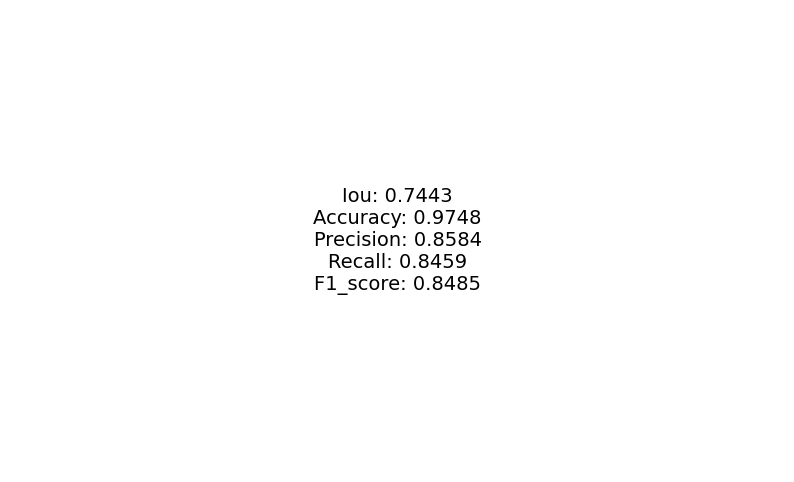

In [99]:
# =====================================================================
# SECTION 11: FONCTION PRINCIPALE (MAIN)
# =====================================================================

if __name__ == "__main__":
    # Cette cellule peut Ãªtre exÃ©cutÃ©e directement dans Colab
    if 'google.colab' in str(get_ipython()):
        # Utiliser l'interface Colab
        create_colab_interface()
    else:
        # ExÃ©cution traditionnelle (hors Colab)
        import argparse

        # Configurer les arguments de ligne de commande
        parser = argparse.ArgumentParser(description="EntraÃ®nement d'un modÃ¨le U-Net pour la dÃ©tection des trouÃ©es forestiÃ¨res")
        parser.add_argument('--mode', type=str, choices=['test', 'estimate', 'full', 'evaluate'], default='full',
                          help="Mode d'exÃ©cution (test=test rapide, estimate=estimer Ã©poques, full=entraÃ®nement complet, evaluate=Ã©valuation)")
        parser.add_argument('--epochs', type=int, default=30, help="Nombre d'Ã©poques pour l'entraÃ®nement")
        parser.add_argument('--batch-size', type=int, default=None, help="Taille des batchs (si non spÃ©cifiÃ©, utilise la valeur de config)")
        parser.add_argument('--model-type', type=str, default='basic',
                          choices=['basic', 'film', 'cbam', 'droppath', 'film_cbam', 'all'],
                          help="Type de modÃ¨le U-Net Ã  utiliser")
        parser.add_argument('--train-tiles', type=int, default=20, help="Nombre de tuiles d'entraÃ®nement en mode test")
        parser.add_argument('--val-tiles', type=int, default=5, help="Nombre de tuiles de validation en mode test")
        parser.add_argument('--test-tiles', type=int, default=5, help="Nombre de tuiles de test en mode test")
        parser.add_argument('--model-path', type=str, default=None, help="Chemin vers un modÃ¨le Ã  Ã©valuer (mode evaluate)")
        parser.add_argument('--save-dir', type=str, default=None, help="RÃ©pertoire personnalisÃ© pour sauvegarder les rÃ©sultats")
        args = parser.parse_args()

        # Choix interactif si pas d'arguments spÃ©cifiÃ©s
        if len(sys.argv) == 1:
            print("=" * 80)
            print("DÃ‰TECTION DES TROUÃ‰ES FORESTIÃˆRES - MODÃˆLE U-NET")
            print("=" * 80)
            print("\nAucun argument fourni. Utilisation du mode interactif.")

            mode_options = {
                '1': ('test', "Test rapide"),
                '2': ('estimate', "Estimer le nombre optimal d'Ã©poques"),
                '3': ('full', "EntraÃ®nement complet"),
                '4': ('evaluate', "Ã‰valuation uniquement")  # Correction ici: full_with_estimate -> evaluate
            }

            model_options = {
                '1': ('basic', "U-Net standard"),
                '2': ('film', "U-Net avec FiLM"),
                '3': ('cbam', "U-Net avec CBAM"),
                '4': ('droppath', "U-Net avec DropPath"),
                '5': ('film_cbam', "U-Net avec FiLM+CBAM"),
                '6': ('all', "U-Net avec FiLM+CBAM+DropPath")
            }

            # Demander le mode
            print("\nChoisissez un mode:")
            for key, (_, desc) in mode_options.items():
                print(f"{key}. {desc}")

            mode_choice = input("Votre choix (1-4): ")
            while mode_choice not in mode_options:
                mode_choice = input("Choix invalide. RÃ©essayez (1-4): ")

            mode = mode_options[mode_choice][0]

            # Demander le type de modÃ¨le
            print("\nChoisissez un type de modÃ¨le:")
            for key, (_, desc) in model_options.items():
                print(f"{key}. {desc}")

            model_choice = input("Votre choix (1-6): ")
            while model_choice not in model_options:
                model_choice = input("Choix invalide. RÃ©essayez (1-6): ")

            model_type = model_options[model_choice][0]

            # Demander le nombre d'Ã©poques
            epochs = input("\nNombre d'Ã©poques (dÃ©faut: 2 pour test, 30 pour entraÃ®nement): ")
            epochs = int(epochs) if epochs.isdigit() else (2 if mode == 'test' else 30)

            # Demander la taille des batchs
            batch_size = input("\nTaille des batchs (dÃ©faut: 32): ")
            batch_size = int(batch_size) if batch_size.isdigit() else 32

            # ParamÃ¨tres supplÃ©mentaires pour le mode test
            if mode == 'test':
                train_tiles = input("\nNombre de tuiles d'entraÃ®nement en mode test (dÃ©faut: 20): ")
                train_tiles = int(train_tiles) if train_tiles.isdigit() else 20

                val_tiles = input("Nombre de tuiles de validation en mode test (dÃ©faut: 5): ")
                val_tiles = int(val_tiles) if val_tiles.isdigit() else 5

                test_tiles = input("Nombre de tuiles de test en mode test (dÃ©faut: 5): ")
                test_tiles = int(test_tiles) if test_tiles.isdigit() else 5
            else:
                train_tiles, val_tiles, test_tiles = 20, 5, 5

            # Demander le chemin du modÃ¨le pour l'Ã©valuation
            model_path = None
            if mode == 'evaluate':
                model_path = input("\nChemin vers le modÃ¨le Ã  Ã©valuer (laisser vide pour utiliser le meilleur modÃ¨le): ")
                model_path = model_path if model_path else None

            # ExÃ©cuter avec les paramÃ¨tres choisis
            print("\nExÃ©cution avec les paramÃ¨tres suivants:")
            print(f"Mode: {mode_options[mode_choice][1]}")
            print(f"Type de modÃ¨le: {model_options[model_choice][1]}")
            print(f"Nombre d'Ã©poques: {epochs}")
            print(f"Taille des batchs: {batch_size}")
            if mode == 'test':
                print(f"Nombre de tuiles d'entraÃ®nement: {train_tiles}")
                print(f"Nombre de tuiles de validation: {val_tiles}")
                print(f"Nombre de tuiles de test: {test_tiles}")
            if mode == 'evaluate' and model_path:
                print(f"Chemin du modÃ¨le: {model_path}")

            try:
                results = run_workflow_colab(
                    mode=mode,
                    custom_epochs=epochs,
                    model_type=model_type,
                    batch_size=batch_size,
                    max_train_tiles=train_tiles,
                    max_val_tiles=val_tiles,
                    max_test_tiles=test_tiles,
                    model_path=model_path
                )
                print("\nExÃ©cution terminÃ©e avec succÃ¨s!")
            except Exception as e:
                print(f"\nErreur pendant l'exÃ©cution: {str(e)}")
                print(traceback.format_exc())
                sys.exit(1)

            sys.exit(0)

        try:
            print("=" * 80)
            print("DÃ‰TECTION DES TROUÃ‰ES FORESTIÃˆRES - MODÃˆLE U-NET")
            print("=" * 80)

            # ExÃ©cuter avec les paramÃ¨tres des arguments de ligne de commande
            results = run_workflow_colab(
                mode=args.mode,
                custom_epochs=args.epochs,
                model_type=args.model_type,
                batch_size=args.batch_size,
                max_train_tiles=args.train_tiles,
                max_val_tiles=args.val_tiles,
                max_test_tiles=args.test_tiles,
                model_path=args.model_path
            )
            print("\nExÃ©cution terminÃ©e avec succÃ¨s!")

        except Exception as e:
            print("\n" + "!" * 80)
            print(f"ERREUR: {str(e)}")
            print(traceback.format_exc())
            print("!" * 80)
            sys.exit(1)
